# Downsample all datasets to the same depth

In [27]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile
import math

In [28]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load peaks

In [29]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

In [30]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

/tmp/ipykernel_754410/386494431.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab10')


In [31]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df


def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    if len(df_sicer) == 0:
        df_sicer = load_peaks(os.path.join(path, 'sicer'), '.scoreisland', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [32]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_peaks = pd.concat([df_encode_peaks, df_immune_peaks]).reset_index(drop=True)

# Remove outliers, see 2023 - figures.ipynb
OUTLIERS = [('H3K4me3', 'NK', ''),
            ('H3K4me1', 'NK', ''),
            ('H3K27me3', 'TCell', ''),
            ('H3K27me3', 'NHLF', 'rep2'),
            ('H3K27me3', 'GM12878', 'rep1')]

df_peaks = df_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_peaks[['modification', 'cell', 'replicate']].iterrows()]].copy()
df_peaks.sample(3)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/954 [00:00<?, ?it/s]

SPAN 85


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/517 [00:00<?, ?it/s]

SPAN 46


file modification     cell  \
74   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3  GM12878   
225  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...      H3K27ac  GM12878   
69   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me3     NHLF   

    replicate  peaks   tool dataset  
74       rep1   1741  MACS2  ENCODE  
225      rep2  31704  SICER  ENCODE  
69       rep2  31110  MACS2  ENCODE

ENCODE


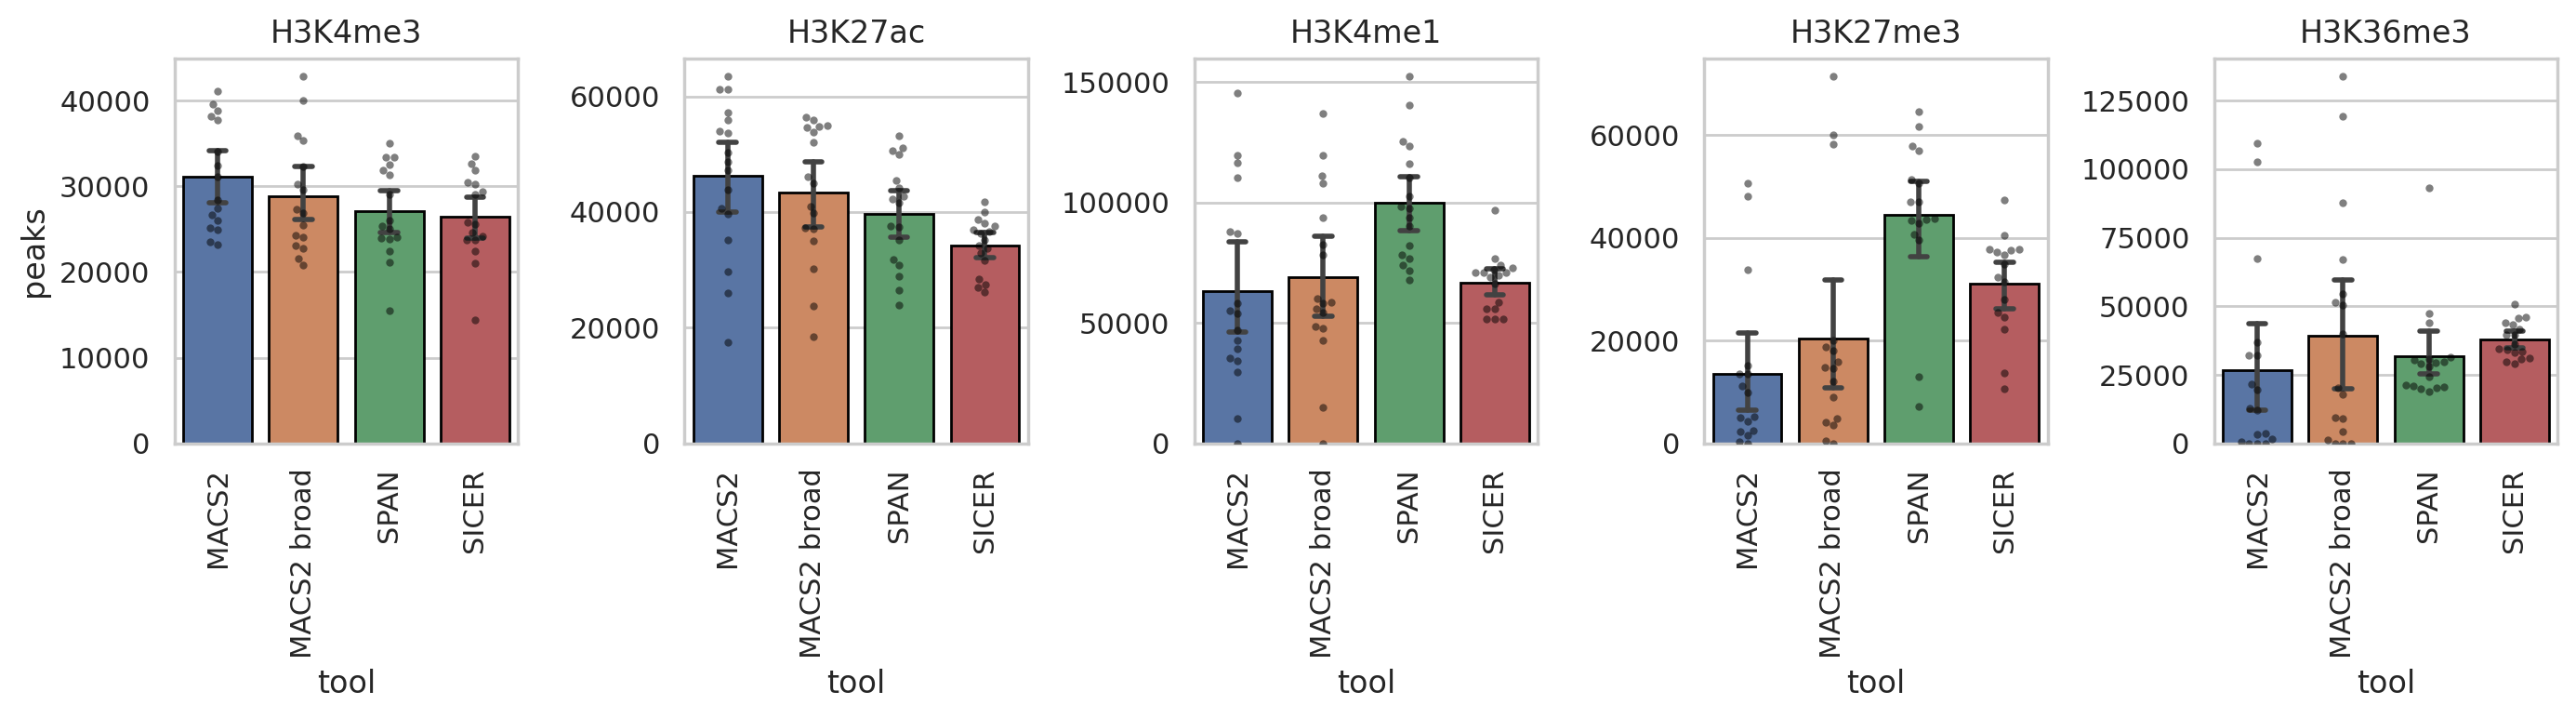

Roadmap


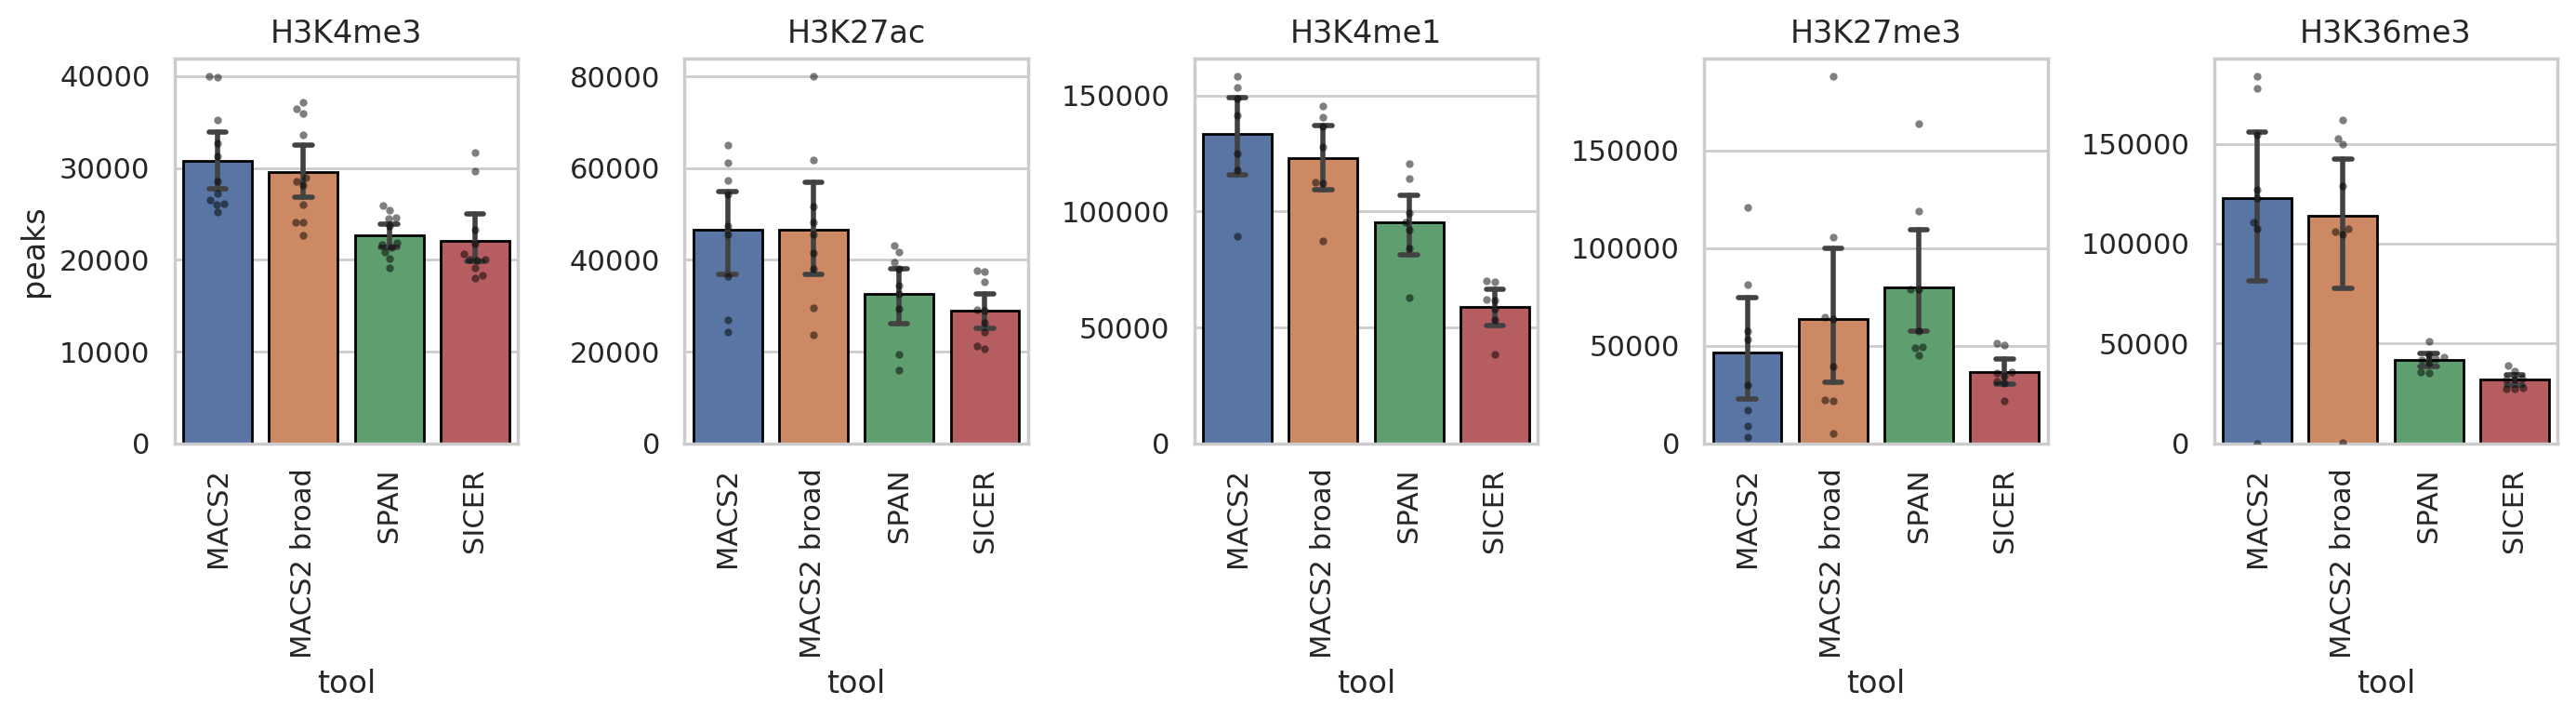

In [33]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(14, 4))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        sns.barplot(data=df_peaks[(df_peaks['dataset'] == ds) &
                                  (df_peaks['modification'] == m)], x='tool', y='peaks',
                    capsize=.2, errwidth=2, edgecolor="black",
                    order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                    ax=ax, )
        sns.swarmplot(data=df_peaks[(df_peaks['dataset'] == ds) &
                                    (df_peaks['modification'] == m)], x='tool', y='peaks',
                      dodge=True, size=3, color="black", alpha=0.5,
                      order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                      ax=ax)

        ax.xaxis.set_tick_params(rotation=90)
        ax.title.set_text(m)
        if i > 0:
            ax.set_ylabel(None)
        else:
            ax.set_ylabel('peaks')

        # ax.set_ylim(0, 1.9e7)
    plt.tight_layout()
    # plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Load BAMs

In [34]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        if cell and mod and rep is not None:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams

In [35]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, 'Control')
df_immune_bams['dataset'] = 'Roadmap'

df_bams = pd.concat([df_encode_bams, df_immune_bams]).reset_index(drop=True)

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

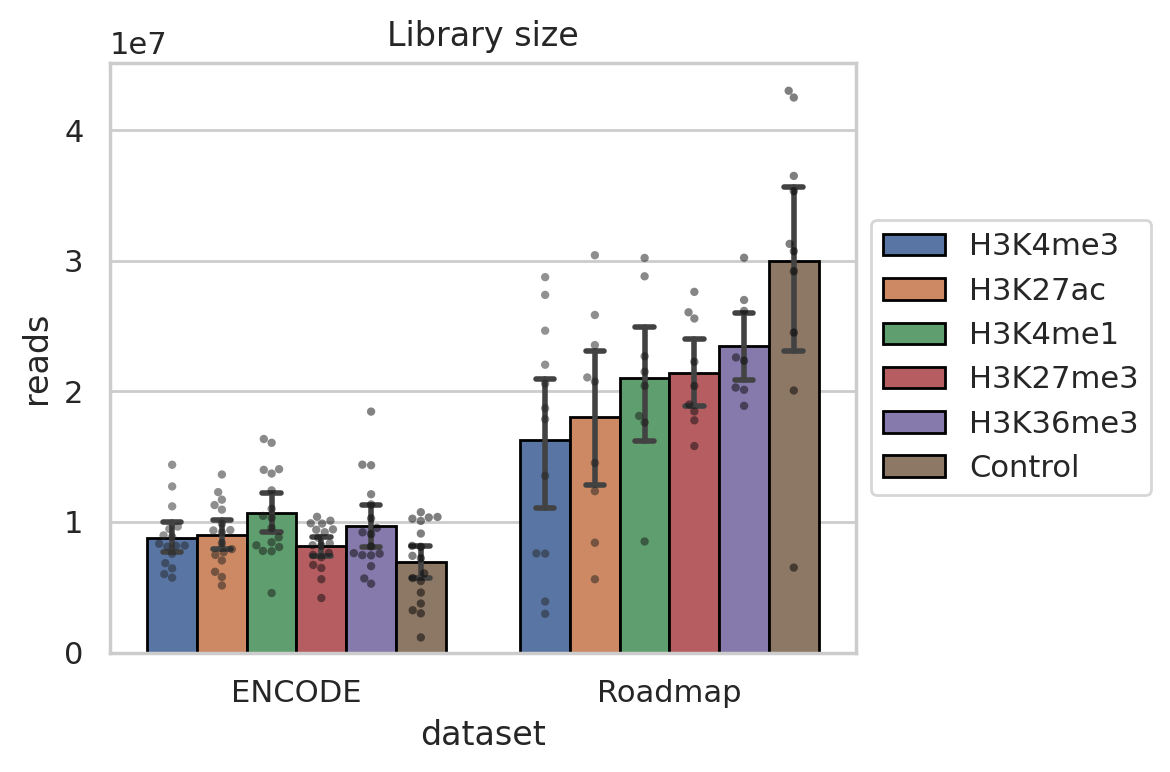

In [36]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
sns.barplot(data=df_bams, hue='modification', x='dataset', y='reads',
            capsize=.05, errwidth=2, edgecolor="black",
            order=['ENCODE', 'Roadmap'],
            hue_order=MODIFICATIONS + ['Control'],
            ax=ax)
sns.swarmplot(data=df_bams, hue='modification', x='dataset', y='reads',
              dodge=True, size=3, palette='dark:black', alpha=0.5, legend=False,
              order=['ENCODE', 'Roadmap'],
              hue_order=MODIFICATIONS + ['Control'],
              ax=ax)
ax.set_title('Library size')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [37]:
rows = []
for _, (ds, m, c, r, f, reads) in tqdm(
        df_bams[(df_bams['modification'] != 'Control')][['dataset', 'modification', 'cell', 'replicate', 'bam_file', 'reads']].iterrows()):
    cr = r
    # Find control
    ct = df_bams[(df_bams['modification'] == 'Control') & (df_bams['cell'] == c) &
                 (df_bams['replicate'] == cr) & (df_bams['dataset'] == ds)]
    if len(ct) == 0:  # Control can be different for Roadmap
        cr = ''
        ct = df_bams[(df_bams['modification'] == 'Control') & (df_bams['cell'] == c) &
                     (df_bams['replicate'] == cr) & (df_bams['dataset'] == ds)]
    if len(ct) == 0:
        continue
    control_file = ct['bam_file'].values[0]
    control_reads = ct['reads'].values[0]
    rows.append((ds, m, c, r, f, reads, cr, control_file, control_reads))
df_controls = pd.DataFrame(rows, columns=['dataset', 'modification', 'cell',
                                          'replicate', 'file', 'reads', 
                                          'control_replicate', 'control_file', 'control_reads'])
df_controls.sample(5)

0it [00:00, ?it/s]

dataset modification   cell replicate  \
41  ENCODE      H3K27ac     H1      rep1   
58  ENCODE      H3K4me1  HepG2      rep1   
17  ENCODE      H3K4me3   HMEC      rep2   
74  ENCODE      H3K27ac   HMEC      rep2   
48  ENCODE      H3K4me1   NHEK      rep1   

                                                 file     reads  \
41  /home/jetbrains/data/2023_GSE26320/bams/GSM646...  13632742   
58  /home/jetbrains/data/2023_GSE26320/bams/GSM646...  13707399   
17  /home/jetbrains/data/2023_GSE26320/bams/GSM646...   8968364   
74  /home/jetbrains/data/2023_GSE26320/bams/GSM646...   9860687   
48  /home/jetbrains/data/2023_GSE26320/bams/GSM646...   8817516   

   control_replicate                                       control_file  \
41              rep1  /home/jetbrains/data/2023_GSE26320/bams/GSM646...   
58              rep1  /home/jetbrains/data/2023_GSE26320/bams/GSM646...   
17              rep2  /home/jetbrains/data/2023_GSE26320/bams/GSM646...   
74              rep2  /home/jetbrains/data/2023_GSE26320/bams/GSM646...   
48              rep1  /home/jetbrains/data/2023_GSE26320/bams/GSM646...   

    control_reads  
41       10076569  
58        9110760  
17       10342115  
74       10342115  
48        8094298

ENCODE


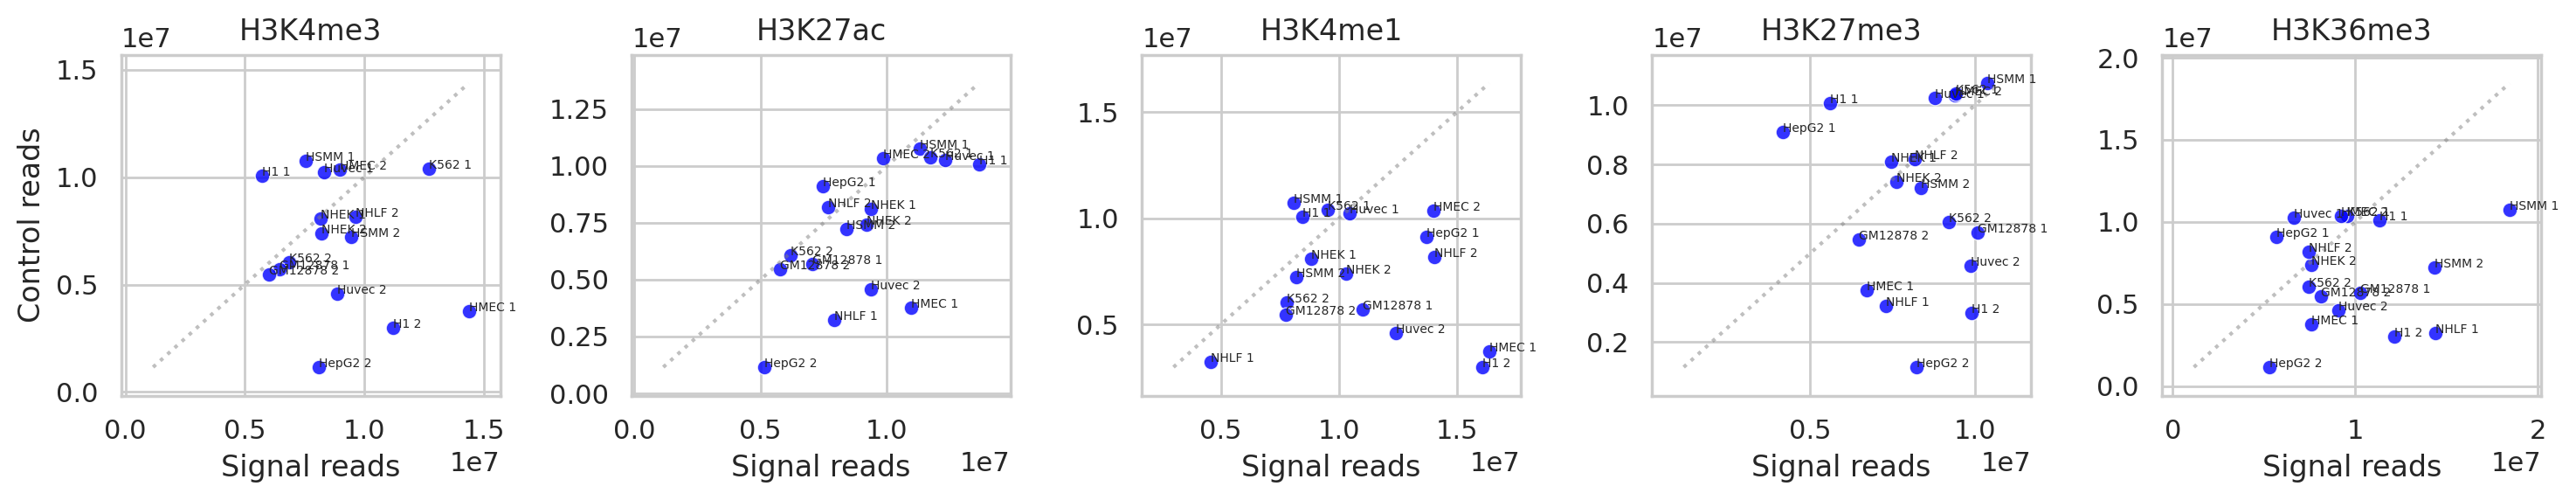

Roadmap


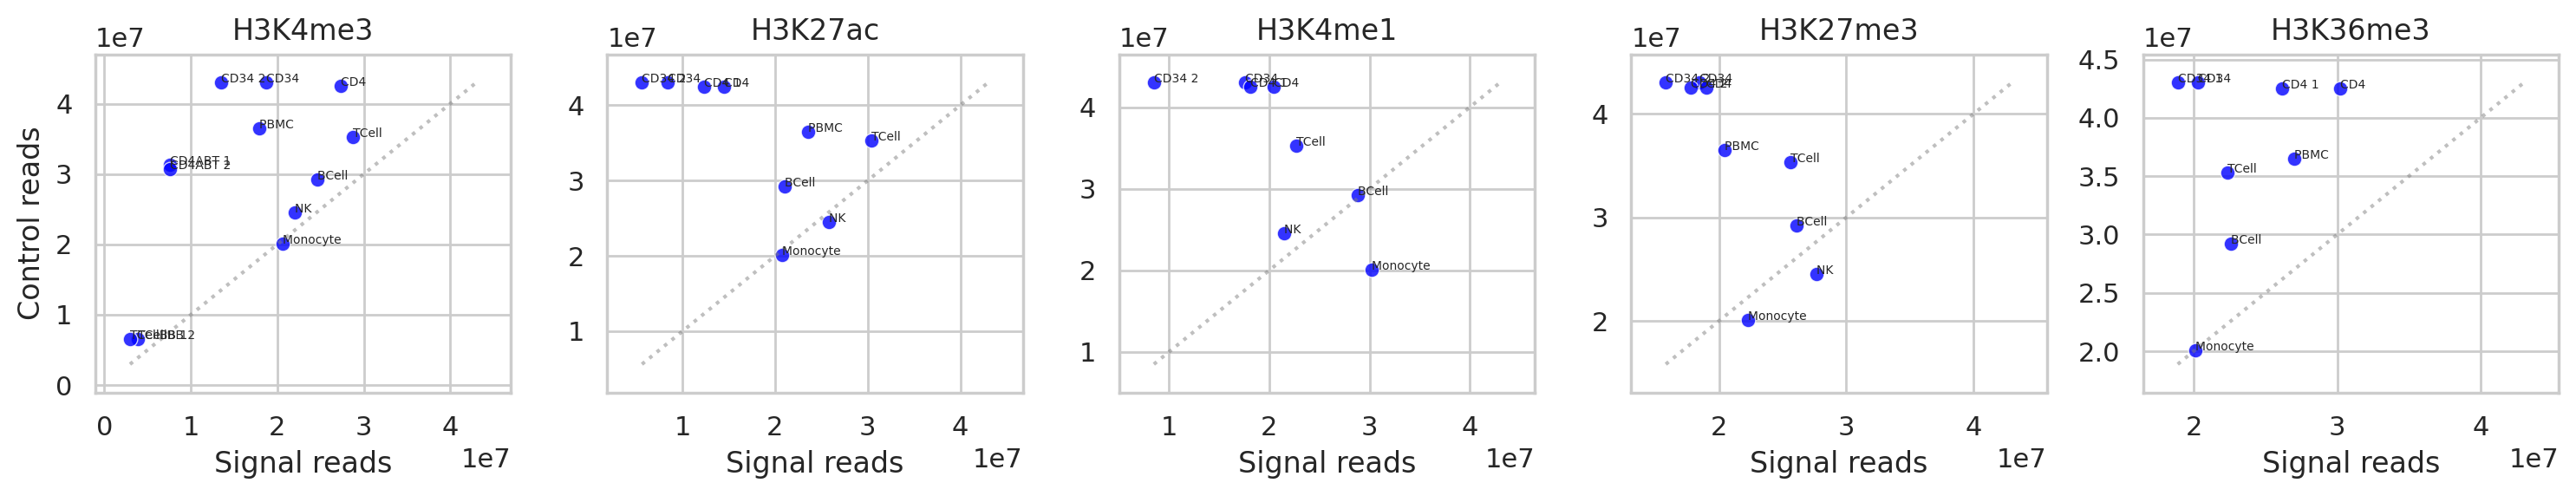

In [38]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(15, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        ax.set_title(m)
        tt = df_controls[(df_controls['dataset'] == ds) & (df_controls['modification'] == m)]
        reads, ctrl_reads = tt['reads'], tt['control_reads']
        minxy = min(np.min(reads), np.min(ctrl_reads))
        maxxy = max(np.max(reads), np.max(ctrl_reads))
        sns.lineplot(x=[minxy, maxxy], y=[minxy, maxxy], color='grey', ax=ax, alpha=0.5, linestyle='dotted')
        sns.scatterplot(x=reads, y=ctrl_reads,
                        alpha=0.8, ax = ax,
                        color='blue')
        for xv, yv, cell, rep in zip(reads, ctrl_reads, tt['cell'], tt['replicate']):
            rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
            ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
        offset = 0.1 * (maxxy - minxy)
        ax.set_xlabel('Signal reads')
        ax.set_ylabel('Control reads')
        ax.set_xlim(minxy - offset, maxxy + offset)
        ax.set_ylim(minxy - offset, maxxy + offset)
        if i > 0:
            ax.set_ylabel(None)
    plt.tight_layout()
    plt.show()

# Downsample

In [39]:
ENCODE_LIM = 5
ROADMAP_LIM = 10

In [40]:
ENCODE_LIM_PATH = os.path.expanduser(f'~/data/2024_GSE26320_{ENCODE_LIM}M')
!mkdir -p {ENCODE_5MLN_PATH}/bams

IMMUNE_LIM_PATH = os.path.expanduser(f'~/data/2024_Immune_{ROADMAP_LIM}M')
!mkdir -p {IMMUNE_20MLN_PATH}/bams

In [41]:
# for ds, lim, dir in [('ENCODE', ENCODE_LIM, ENCODE_LIM_PATH), ('Roadmap', ROADMAP_LIM, IMMUNE_LIM_PATH)]:
#     print(ds, lim, dir)
#     ! mkdir -p {dir}/bams
#     lim *= 1_000_000
#     for _, row in tqdm(list(df_controls[df_controls['dataset'] == ds].iterrows())):
#         m, c, r, bam_file, reads, control_file, control_reads =\
#             row['modification'], row['cell'], row['replicate'], row['file'], row['reads'], row['control_file'], row['control_reads']
#         print(m, c, r, reads, control_reads)
#         if reads < lim or control_reads < lim:
#             print('Skip')
#             continue
#         for orig_file, orig_reads, ds_file in [(bam_file, reads, f'{dir}/bams/{m}_{c}_{r}.bam'), 
#                                                (control_file, control_reads, f'{dir}/bams/control_{c}_{r}.bam')]:
#             if not os.path.exists(ds_file):
#                 fraction = lim / orig_reads
#                 print(f'Downsampling {orig_file} by {fraction} to {ds_file}')
#                 tf = tempfile.mktemp()
#                 try:
#                     ! samtools view -@ 4 -H {orig_file} > {tf}.sam
#                     ! samtools view -@ 4 -s {fraction} {orig_file} >> {tf}.sam
#                     ! samtools view -S -b {tf}.sam > {tf}.bam
#                     ! ls -lah {tf}.bam
#                     ! samtools sort {tf}.bam -o {ds_file}
#                 except Exception as e:
#                     print('Failed', e)
#                 finally:
#                     ! rm {tf}.sam {tf}.bam    

# Peak calling and visualization

```
conda activate snakemake

for DIR in ~/data/2024_GSE26320_5M ~/data/2024_Immune_20M; do echo $DIR;
cd "${DIR}"; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" span=True sicer=True span_bin=100 span_params="--keep-cache --debug" --rerun-trigger mtime; 
done
```

In [42]:
df_encode_5m_peaks = load_peaks_path(ENCODE_LIM_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_5m_peaks['dataset'] = 'ENCODE'
df_immune_10m_peaks = load_peaks_path(IMMUNE_LIM_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_10m_peaks['dataset'] = 'Roadmap'
df_m_peaks = pd.concat([df_encode_5m_peaks, df_immune_10m_peaks]).reset_index(drop=True)

# Remove outliers, see 2023 - figures.ipynb
OUTLIERS = [('H3K4me3', 'NK', ''),
            ('H3K4me1', 'NK', ''),
            ('H3K27me3', 'TCell', ''),
            ('H3K27me3', 'NHLF', 'rep2'),
            ('H3K27me3', 'GM12878', 'rep1')]

df_m_peaks = df_m_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_m_peaks[['modification', 'cell', 'replicate']].iterrows()]].copy()
df_m_peaks.sample(3)


  0%|          | 0/496 [00:00<?, ?it/s]

MACS2 62


  0%|          | 0/496 [00:00<?, ?it/s]

MACS2 broad 62


  0%|          | 0/62 [00:00<?, ?it/s]

SICER 62


  0%|          | 0/200 [00:00<?, ?it/s]

SPAN 62


  0%|          | 0/312 [00:00<?, ?it/s]

MACS2 39


  0%|          | 0/312 [00:00<?, ?it/s]

MACS2 broad 39


  0%|          | 0/39 [00:00<?, ?it/s]

SICER 39


  0%|          | 0/128 [00:00<?, ?it/s]

SPAN 39


file modification  cell  \
121  /home/jetbrains/data/2024_GSE26320_5M/macs2/H3...     H3K27me3  NHEK   
41   /home/jetbrains/data/2024_GSE26320_5M/macs2/H3...      H3K27ac    H1   
124  /home/jetbrains/data/2024_GSE26320_5M/sicer/H3...      H3K4me3  NHLF   

    replicate  peaks         tool dataset  
121      rep2  33829  MACS2 broad  ENCODE  
41       rep1  13486        MACS2  ENCODE  
124      rep2  21938        SICER  ENCODE

In [43]:
print('Number of replicates')
df_m_peaks[df_m_peaks['tool']=='MACS2'][['dataset', 'modification', 'cell', 'replicate']].groupby(
    ['dataset', 'modification', 'cell']).count().groupby(['dataset', 'modification']).count()

Number of replicates


replicate
dataset modification           
ENCODE  H3K27ac               9
        H3K27me3              7
        H3K36me3              9
        H3K4me1               9
        H3K4me3               8
Roadmap H3K27ac               6
        H3K27me3              6
        H3K36me3              6
        H3K4me1               5
        H3K4me3               6

ENCODE


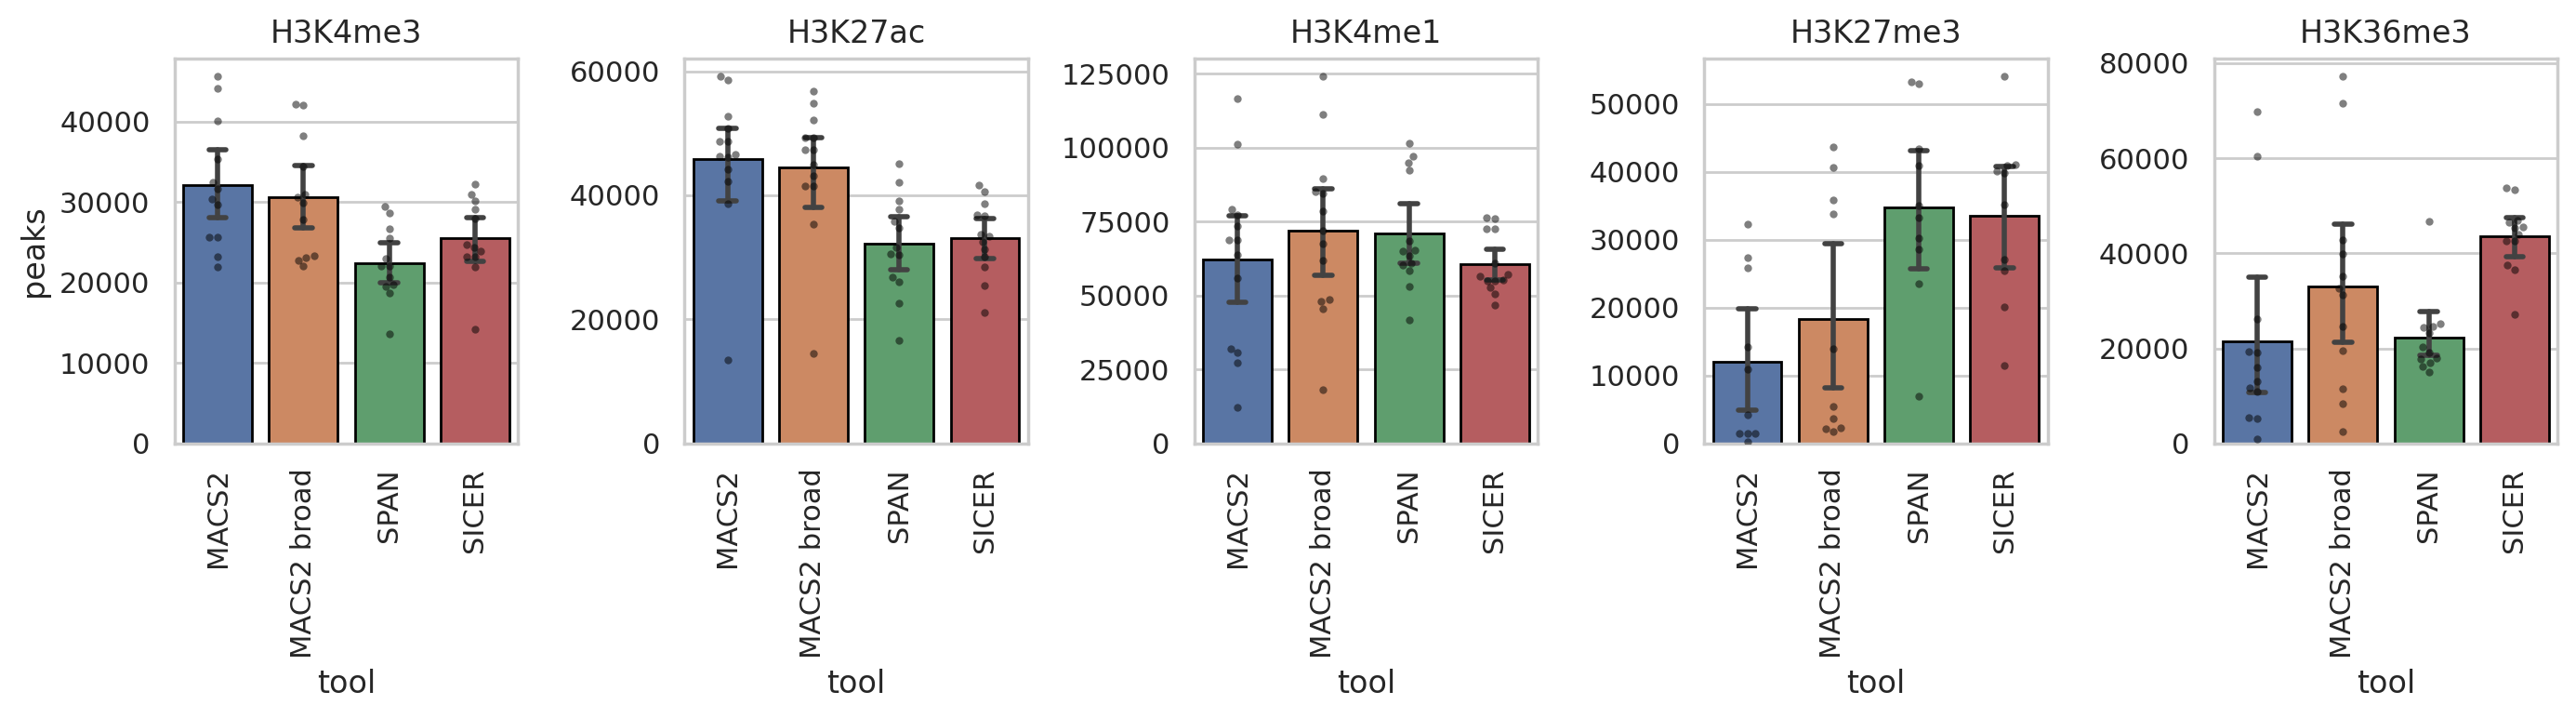

Roadmap


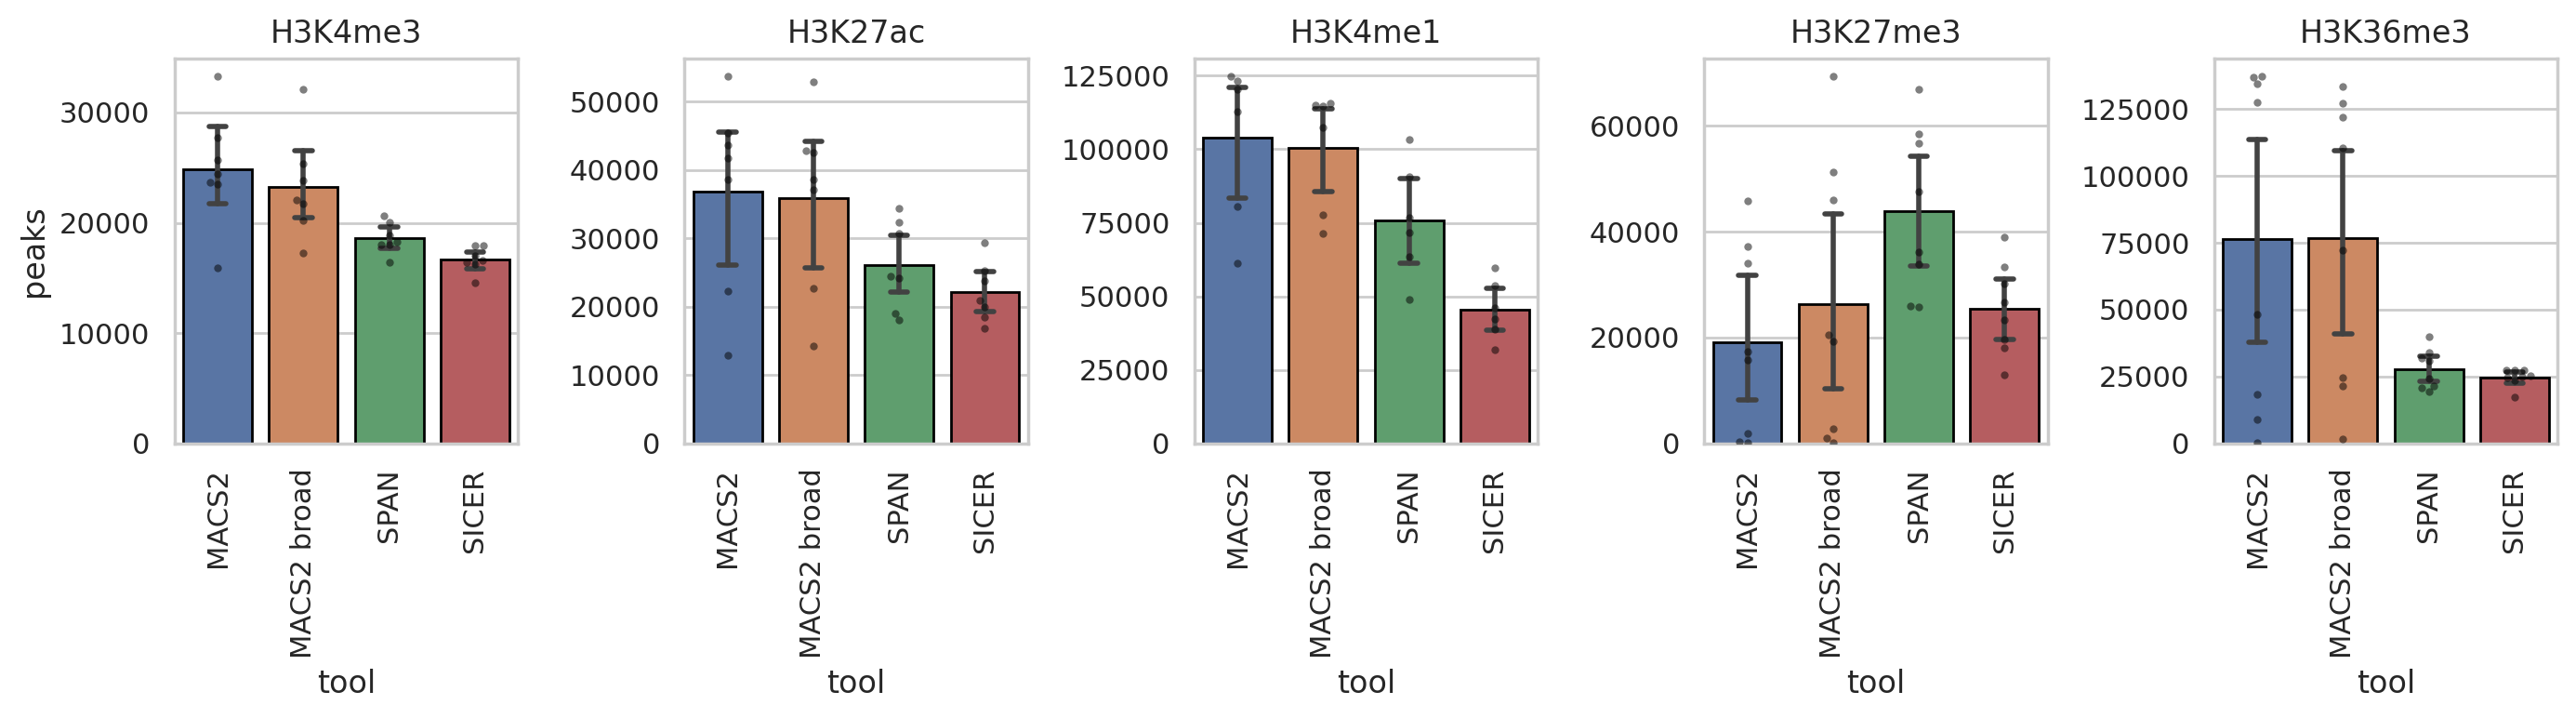

In [44]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(14, 4))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        t = df_m_peaks[(df_m_peaks['dataset'] == ds) & (df_m_peaks['modification'] == m)]
        sns.barplot(data=t, x='tool', y='peaks',
                    capsize=.2, errwidth=2, edgecolor="black",
                    order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                    ax=ax, )
        sns.swarmplot(data=t, x='tool', y='peaks',
                      dodge=True, size=3, color="black", alpha=0.5,
                      order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                      ax=ax)

        ax.xaxis.set_tick_params(rotation=90)
        ax.title.set_text(m)
        if i > 0:
            ax.set_ylabel(None)
        else:
            ax.set_ylabel('peaks')

        # ax.set_ylim(0, 1.9e7)
    plt.tight_layout()
    # plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
    plt.show()

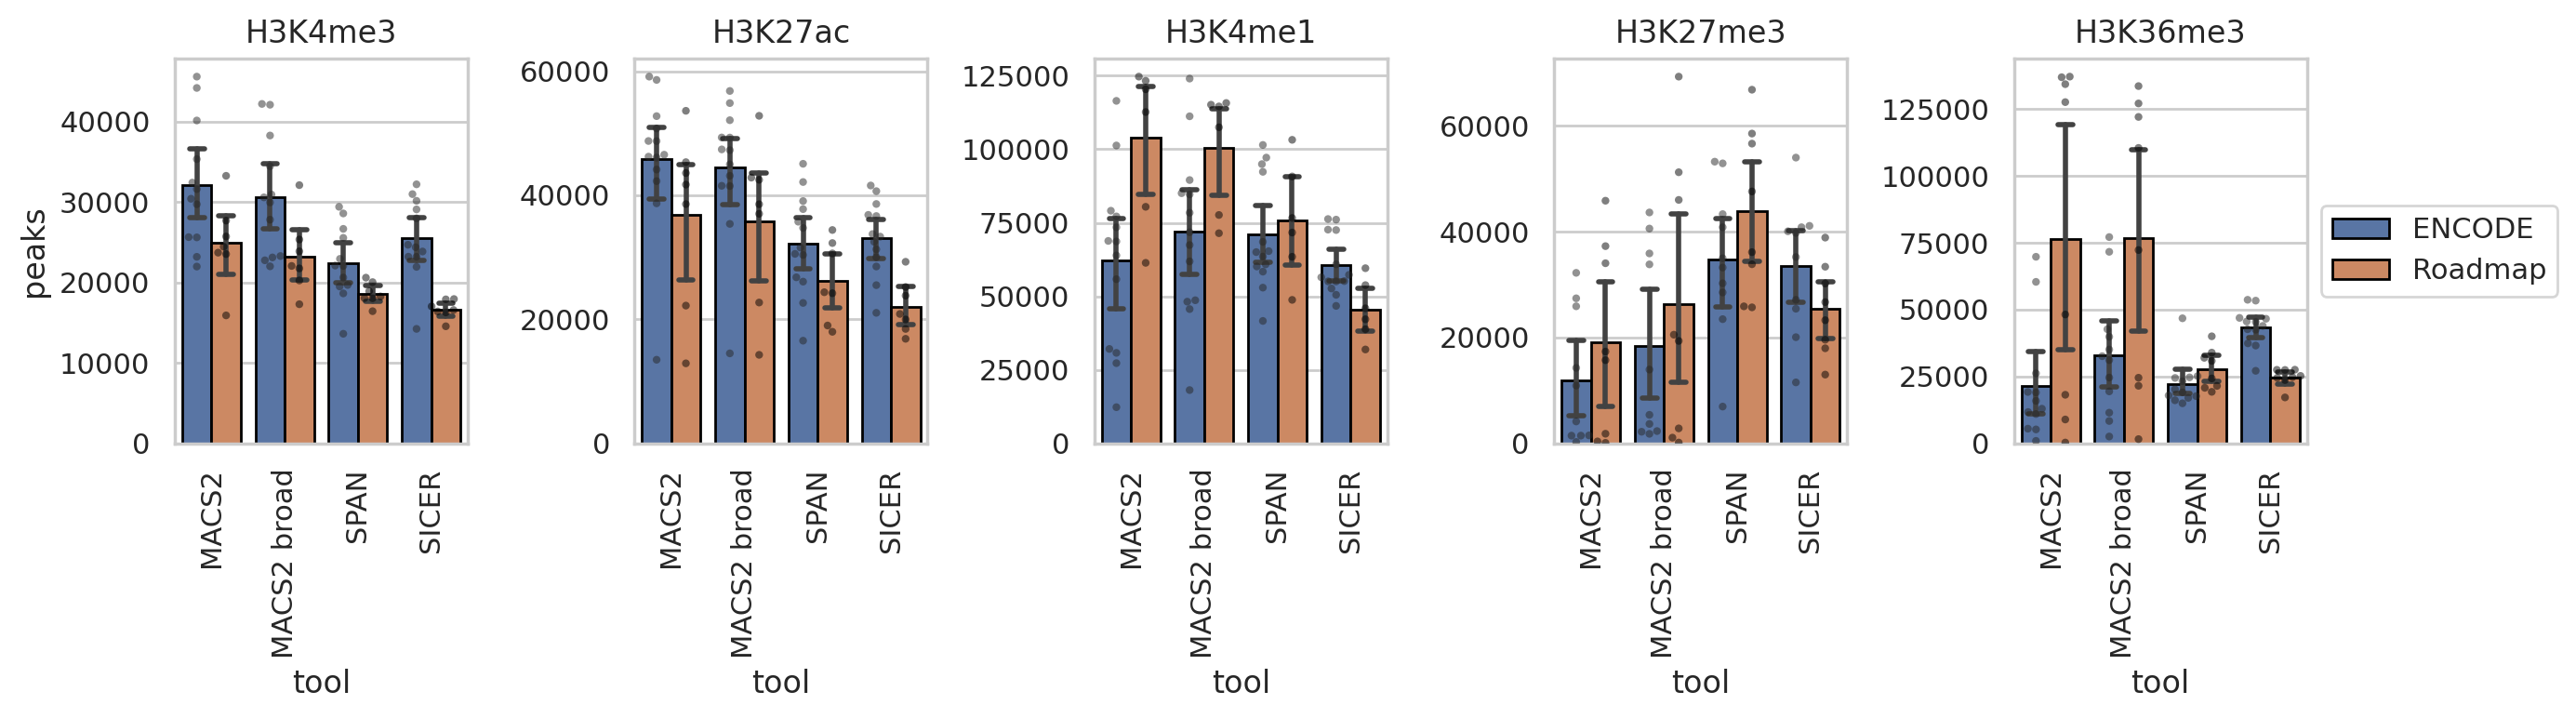

In [45]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    t = df_m_peaks[df_m_peaks['modification'] == m]
    sns.barplot(data=t, x='tool', y='peaks', hue='dataset',
                capsize=.2, errwidth=2, edgecolor="black",
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax, )
    sns.swarmplot(data=t, x='tool', y='peaks', hue='dataset',
                  dodge=True, size=3, palette="dark:black", alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                  ax=ax)

    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < len(axs) -1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Lengths

In [46]:
print('Load lengths')
ts = []
for ds, mod, cell, rep, tool, file  in tqdm(zip(
        df_m_peaks['dataset'], df_m_peaks['modification'], df_m_peaks['cell'], df_m_peaks['replicate'],
        df_m_peaks['tool'], df_m_peaks['file']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['dataset'] = ds
    t['modification'] = mod
    t['cell'] = cell
    t['replicate'] = rep
    t['tool'] = tool
    t['footprint'] = sum(lengths)
    ts.append(t)
df_lens = pd.concat(ts).reset_index(drop=True)
del ts, t
df_lens.sample(10)

Load lengths


0it [00:00, ?it/s]

length  dataset modification     cell replicate         tool  \
822391      291   ENCODE     H3K36me3    HepG2      rep1  MACS2 broad   
3247307    4799  Roadmap     H3K27me3     CD34                  SICER   
714907      328   ENCODE      H3K27ac  GM12878      rep2  MACS2 broad   
441898      213   ENCODE      H3K4me1     K562      rep1        MACS2   
2387848     654  Roadmap      H3K4me1      CD4      rep1        MACS2   
101383     1710   ENCODE      H3K4me1    Huvec      rep1        MACS2   
1759710     650   ENCODE      H3K4me3  GM12878      rep2         SPAN   
544806     1473   ENCODE     H3K36me3     K562      rep2  MACS2 broad   
1289039    4399   ENCODE     H3K27me3  GM12878      rep2        SICER   
2305650     348  Roadmap      H3K27ac      CD4                  MACS2   

         footprint  
822391     5197300  
3247307  169603324  
714907    52319346  
441898    30462377  
2387848   41238043  
101383    47220543  
1759710   50444520  
544806    18170215  
1289039   67971269  
2305650   50073489

ENCODE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


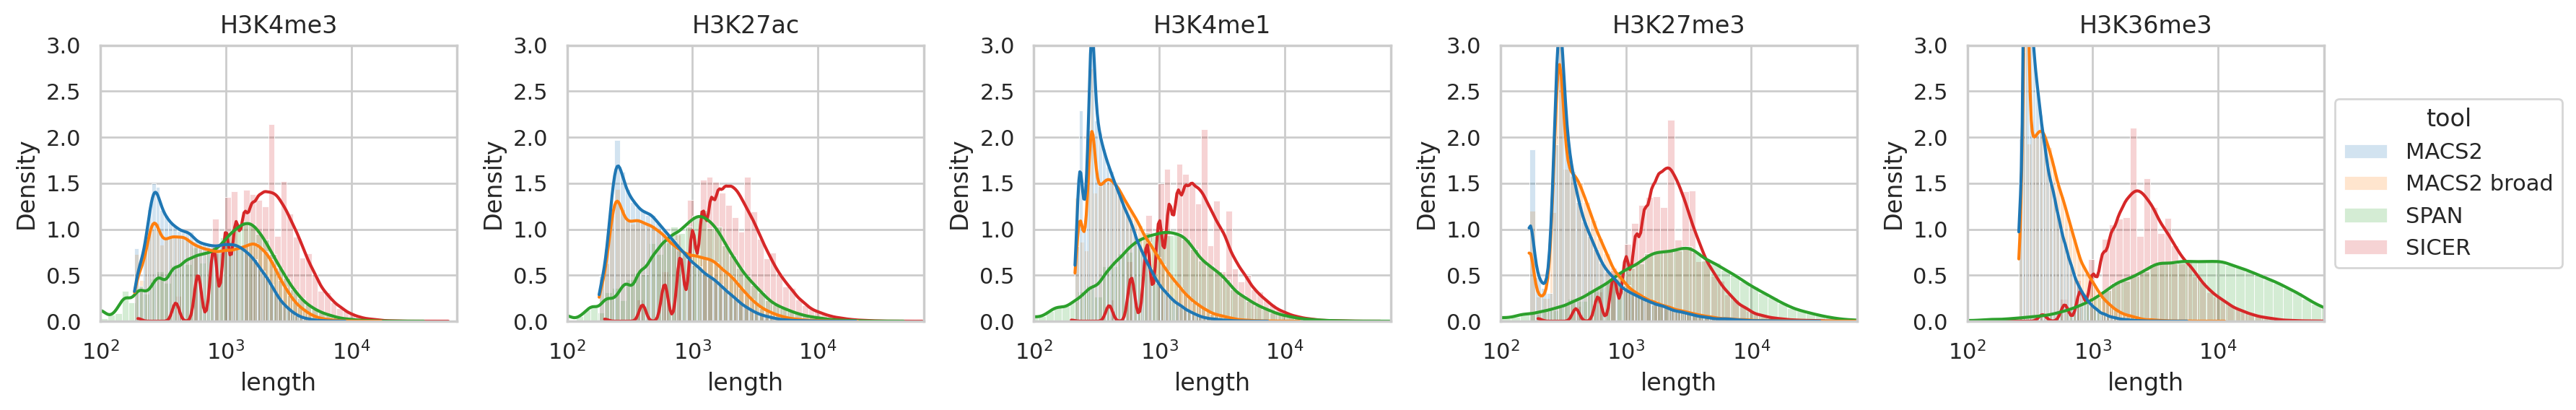

Roadmap


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


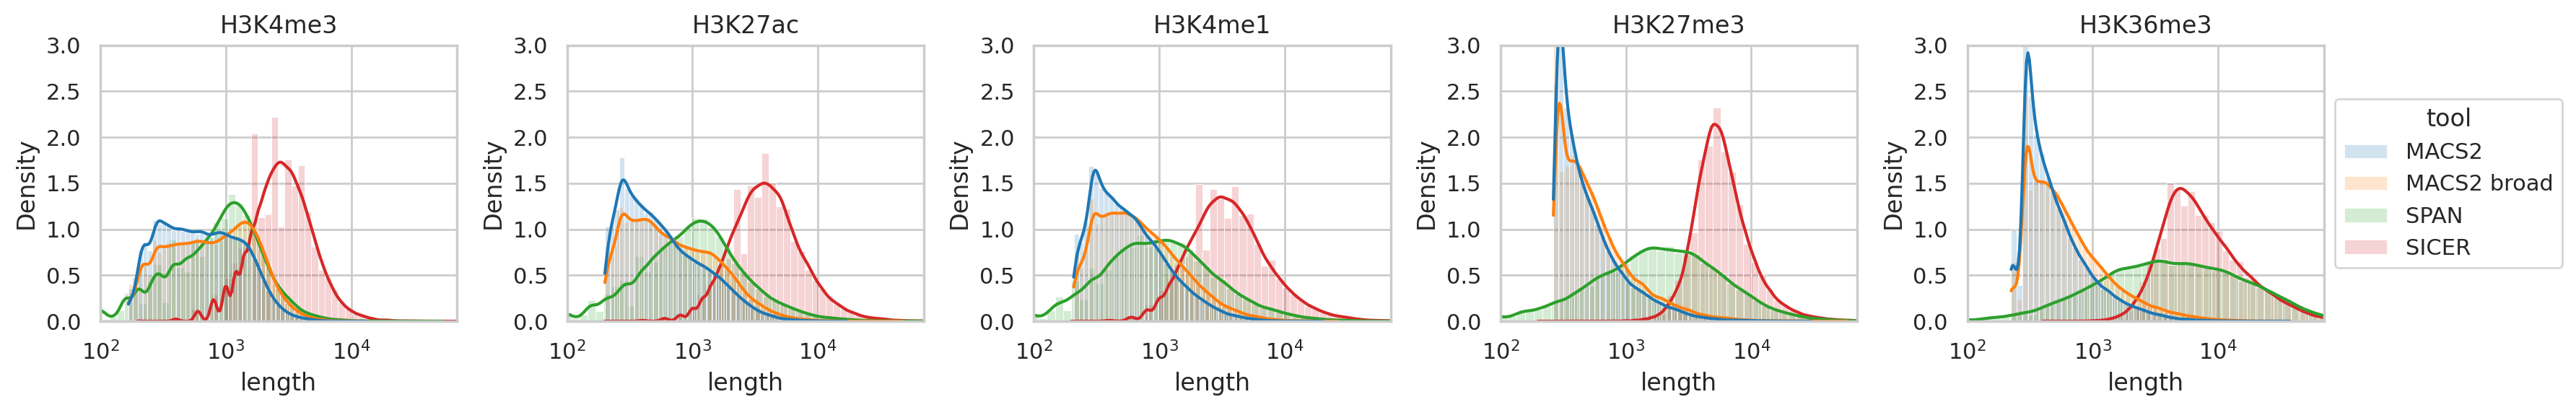

In [47]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(18, 3))    
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        g_results = sns.histplot(data=df_lens[(df_lens['dataset'] == ds) & (df_lens['modification'] == m)], 
                                 x='length', hue='tool', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=50, kde=True, log_scale=True, alpha=0.2,
                                 palette=TOOLS_PALETTE,
                                 hue_order=TOOLS)
        g_results.set(xscale='log')
        g_results.set_ylim(0, 3)
        g_results.set_xlim(1e2, 7e4)
        ax.title.set_text(m)
        if i < len(axs) - 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()  

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


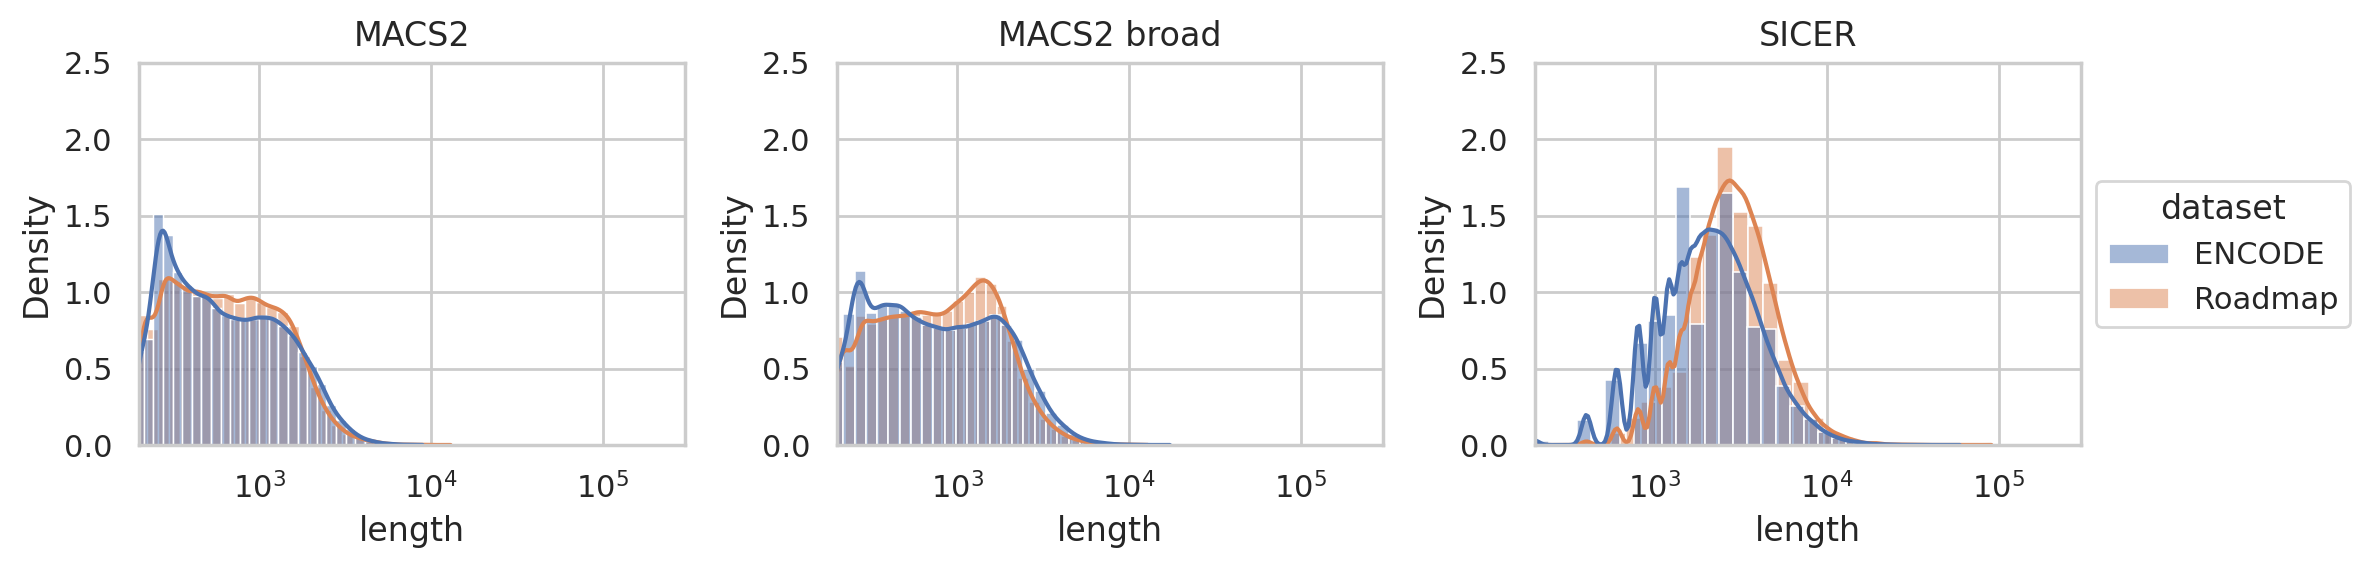

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


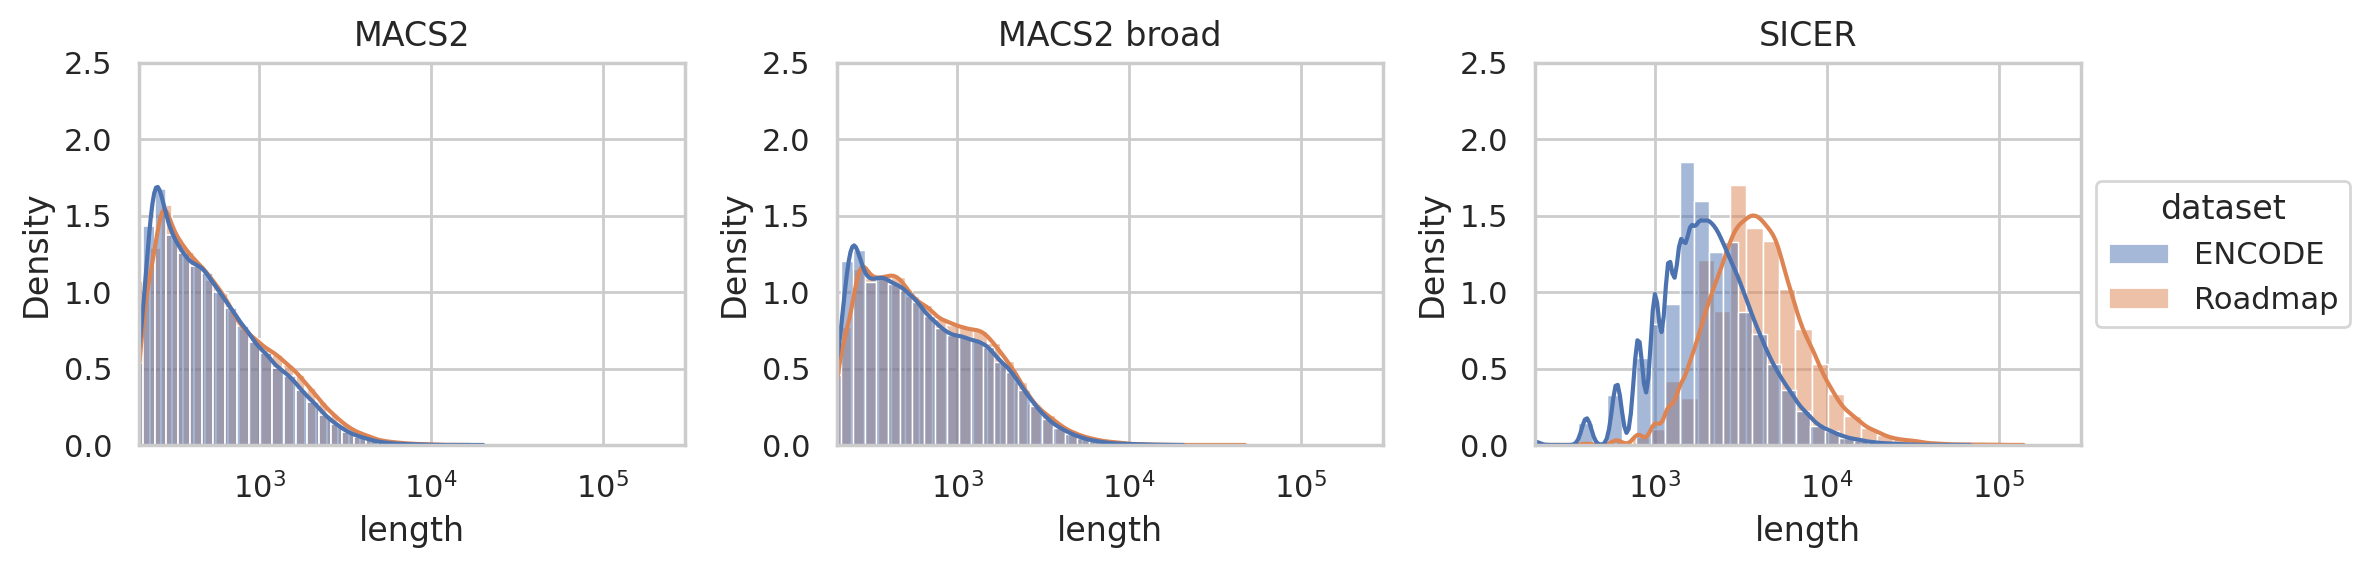

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


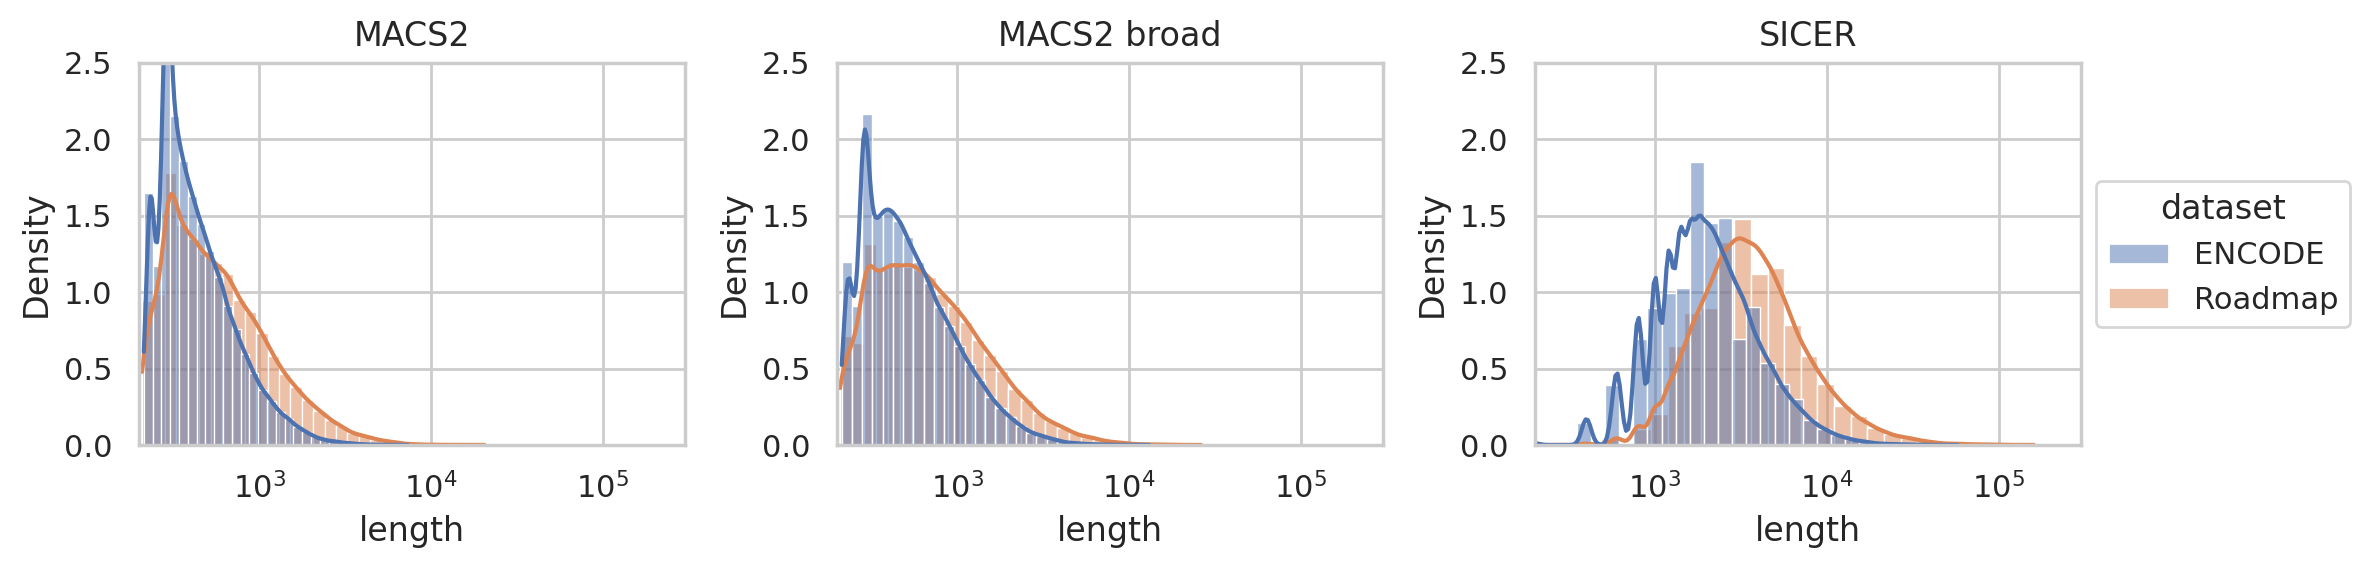

H3K27me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


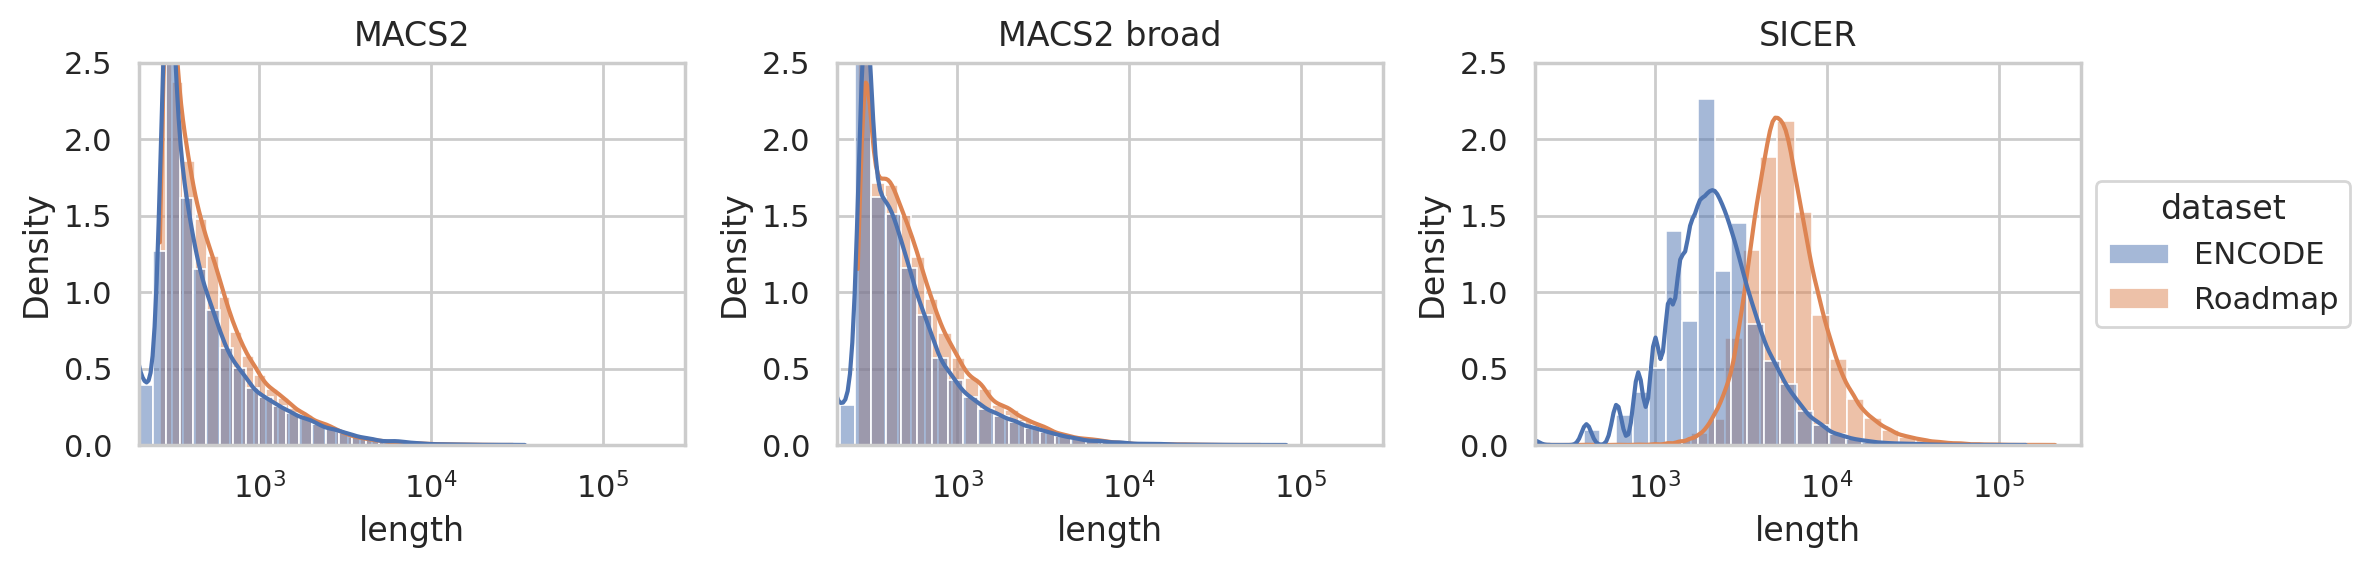

H3K36me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


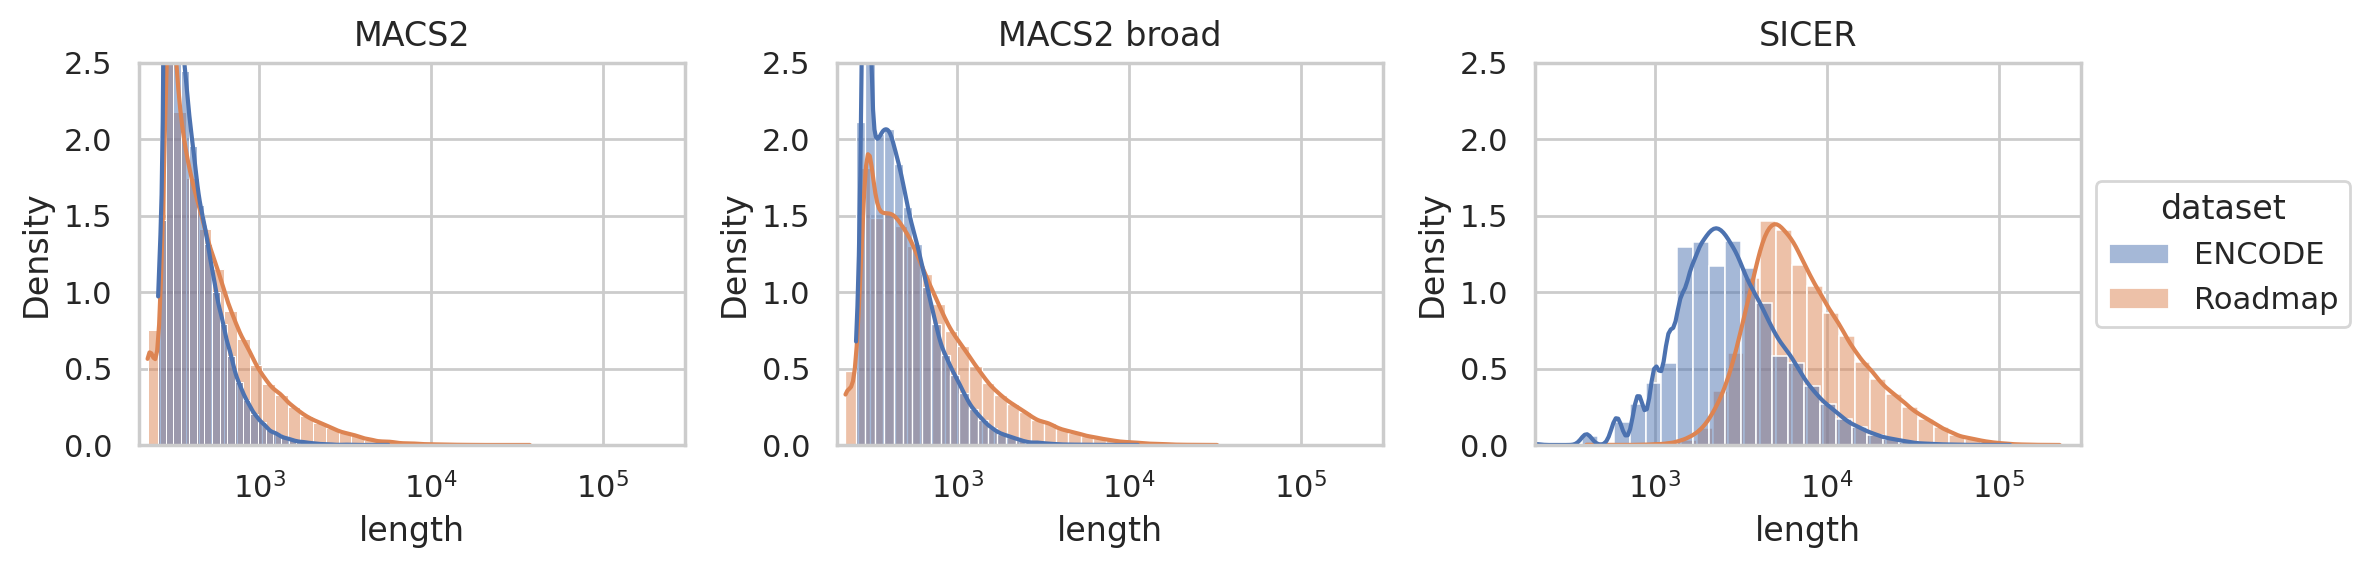

In [48]:
for m in ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']:
    print(m)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=df_lens[(df_lens['modification'] == m) & (df_lens['tool'] == tool)],
                                 x='length', hue='dataset', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 # palette=TOOLS_PALETTE,
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 3e5)
        ax.title.set_text(f'{tool}')
        if i < len(axs) - 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K36me3


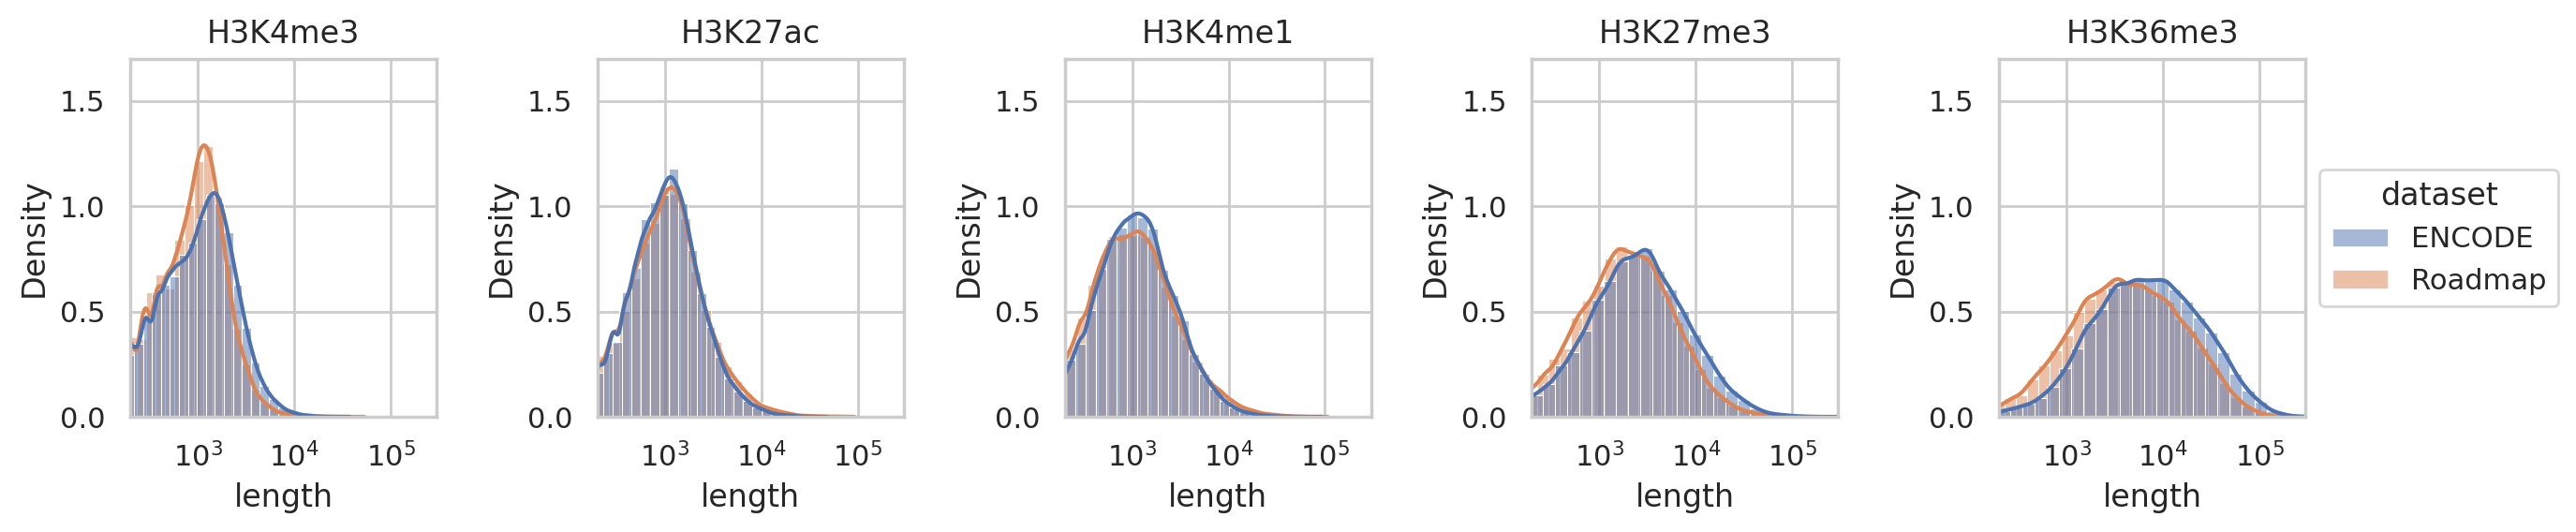

In [49]:
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=df_lens[(df_lens['modification'] == m) & (df_lens['tool'] == 'SPAN')],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             # palette=TOOLS_PALETTE,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 1.7)
    g_results.set_xlim(200, 3e5)
    ax.title.set_text(m)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


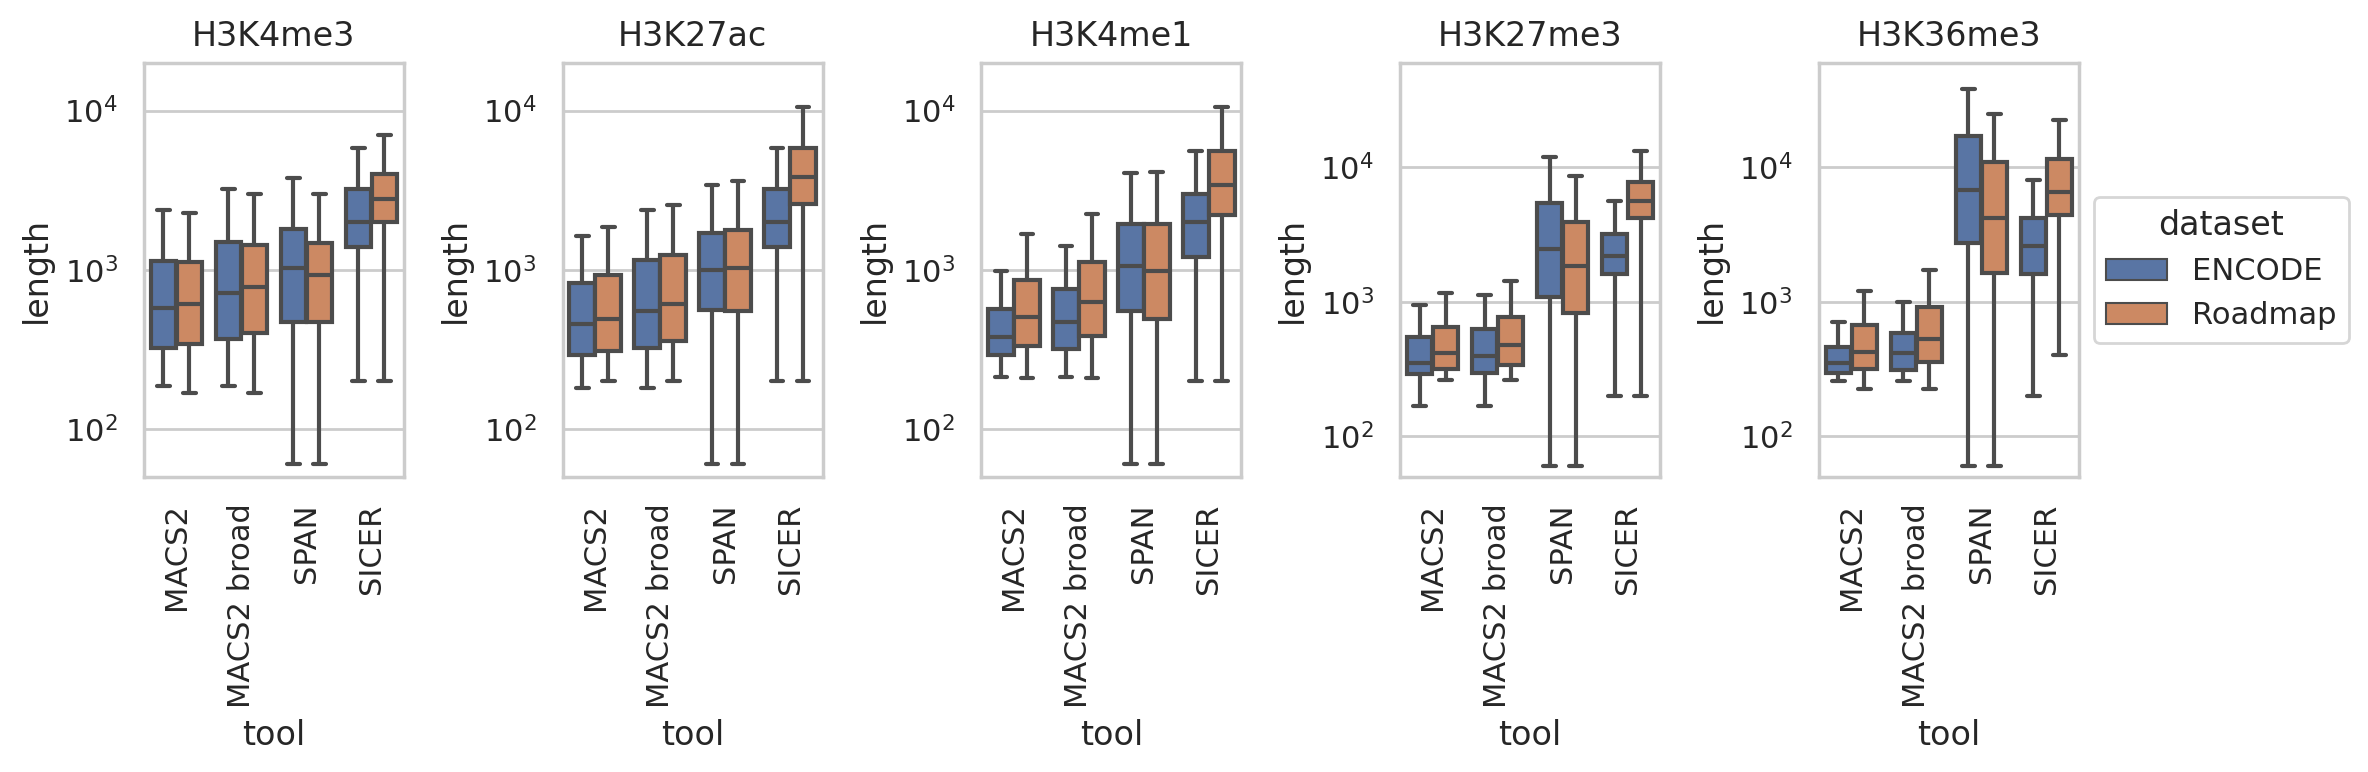

In [50]:
plt.figure(figsize=(12, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    t = df_lens[df_lens['modification'] == m]
    sns.boxplot(data=t, x='tool', y='length', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                hue_order=['ENCODE', 'Roadmap'],
                ax=ax)
    # sns.swarmplot(data=t, x='tool', y='length', hue='dataset',
    #               dodge=True, size=1.5, palette='dark:black', alpha=0.8, legend=False,
    #               order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
    #               hue_order=['ENCODE', 'Roadmap'],
    #               ax=ax)
    ax.title.set_text(m)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if m not in ['H3K27me3', 'H3K36me3']:
        ax.set_ylim(bottom=50, top=2e4)
    else:
        ax.set_ylim(bottom=50, top=6e4)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [51]:
df_lens_aggr = df_lens[
    ['dataset', 'modification', 'cell', 'replicate', 'tool', 'length', 'footprint']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']).agg('mean').reset_index().drop_duplicates()
df_lens_aggr.sample(3)

dataset modification   cell replicate   tool     length    footprint
186  ENCODE      H3K4me1   NHEK      rep2  SICER  2196.2200  166991725.0
152  ENCODE      H3K4me1   HMEC      rep2  MACS2   482.3643   55330378.0
166  ENCODE      H3K4me1  HepG2      rep1  SICER  2675.2000  154954091.0

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


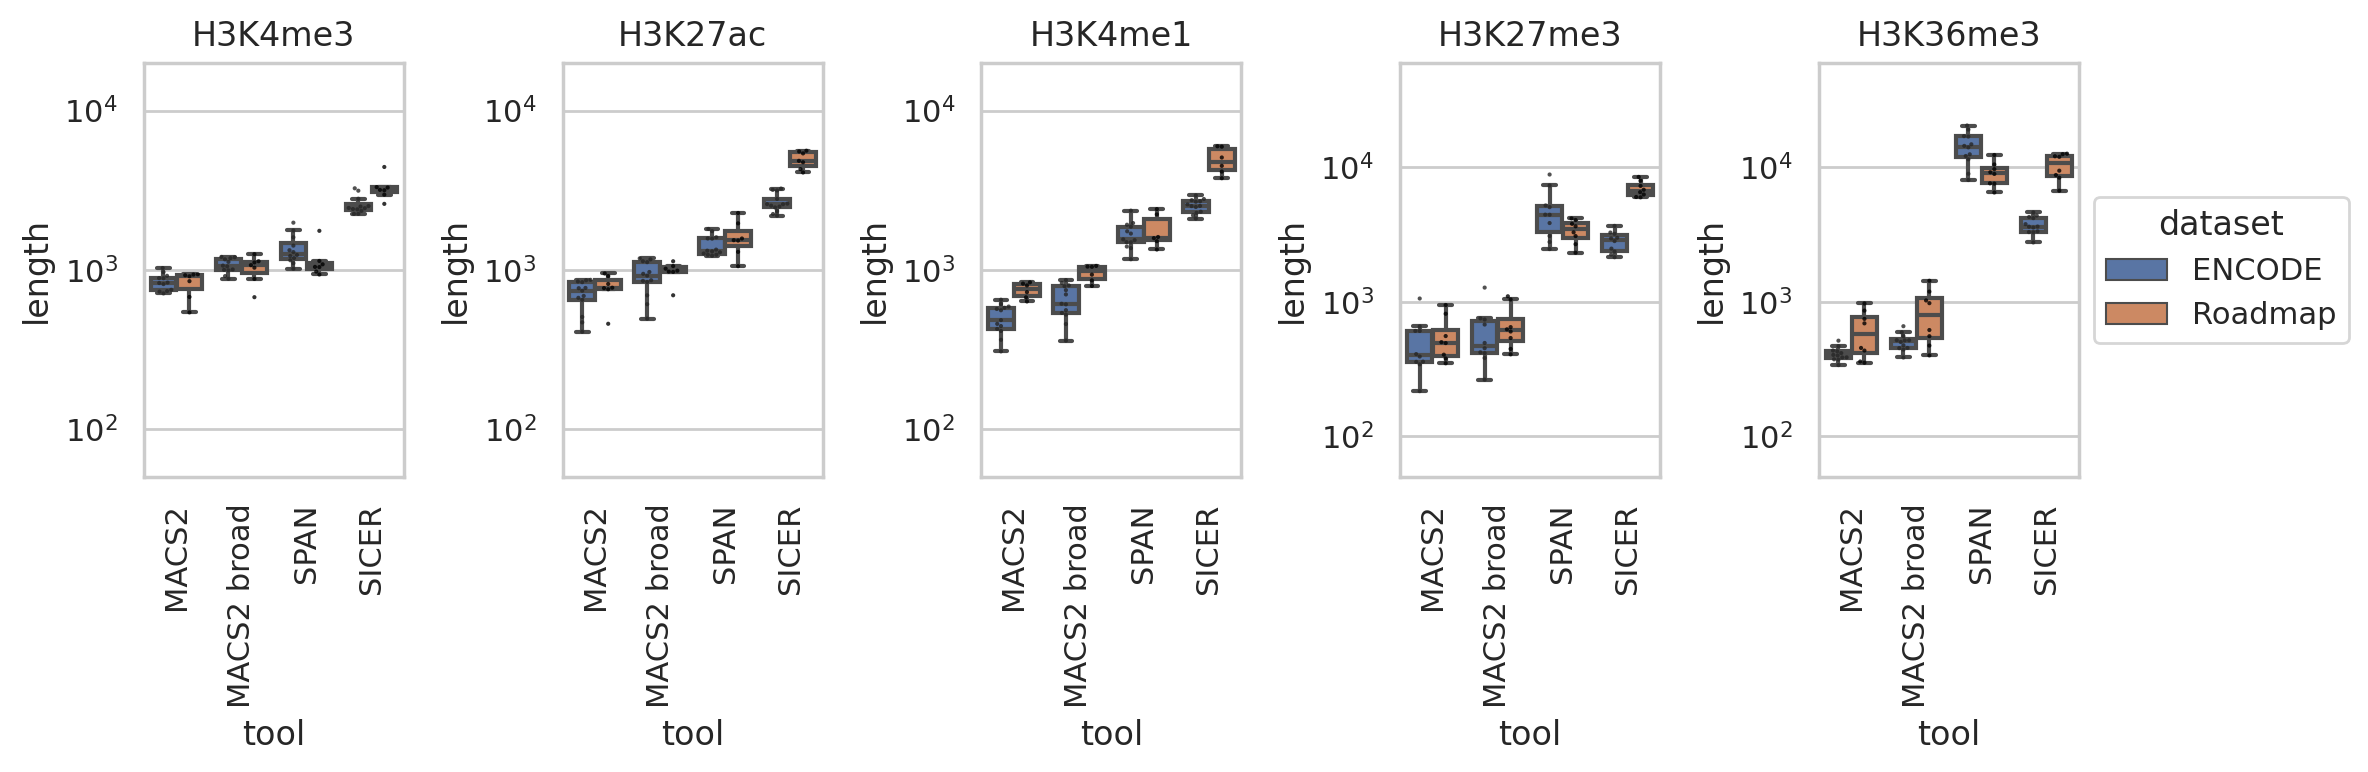

In [52]:
plt.figure(figsize=(12, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    t = df_lens_aggr[df_lens_aggr['modification'] == m].copy()
    sns.boxplot(data=t, x='tool', y='length', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                hue_order=['ENCODE', 'Roadmap'],
                ax=ax)
    sns.swarmplot(data=t, x='tool', y='length', hue='dataset',
                  dodge=True, size=1.5, palette='dark:black', alpha=0.8, legend=False,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  hue_order=['ENCODE', 'Roadmap'],
                  ax=ax)
    ax.title.set_text(m)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if m not in ['H3K27me3', 'H3K36me3']:
        ax.set_ylim(bottom=50, top=2e4)
    else:
        ax.set_ylim(bottom=50, top=6e4)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


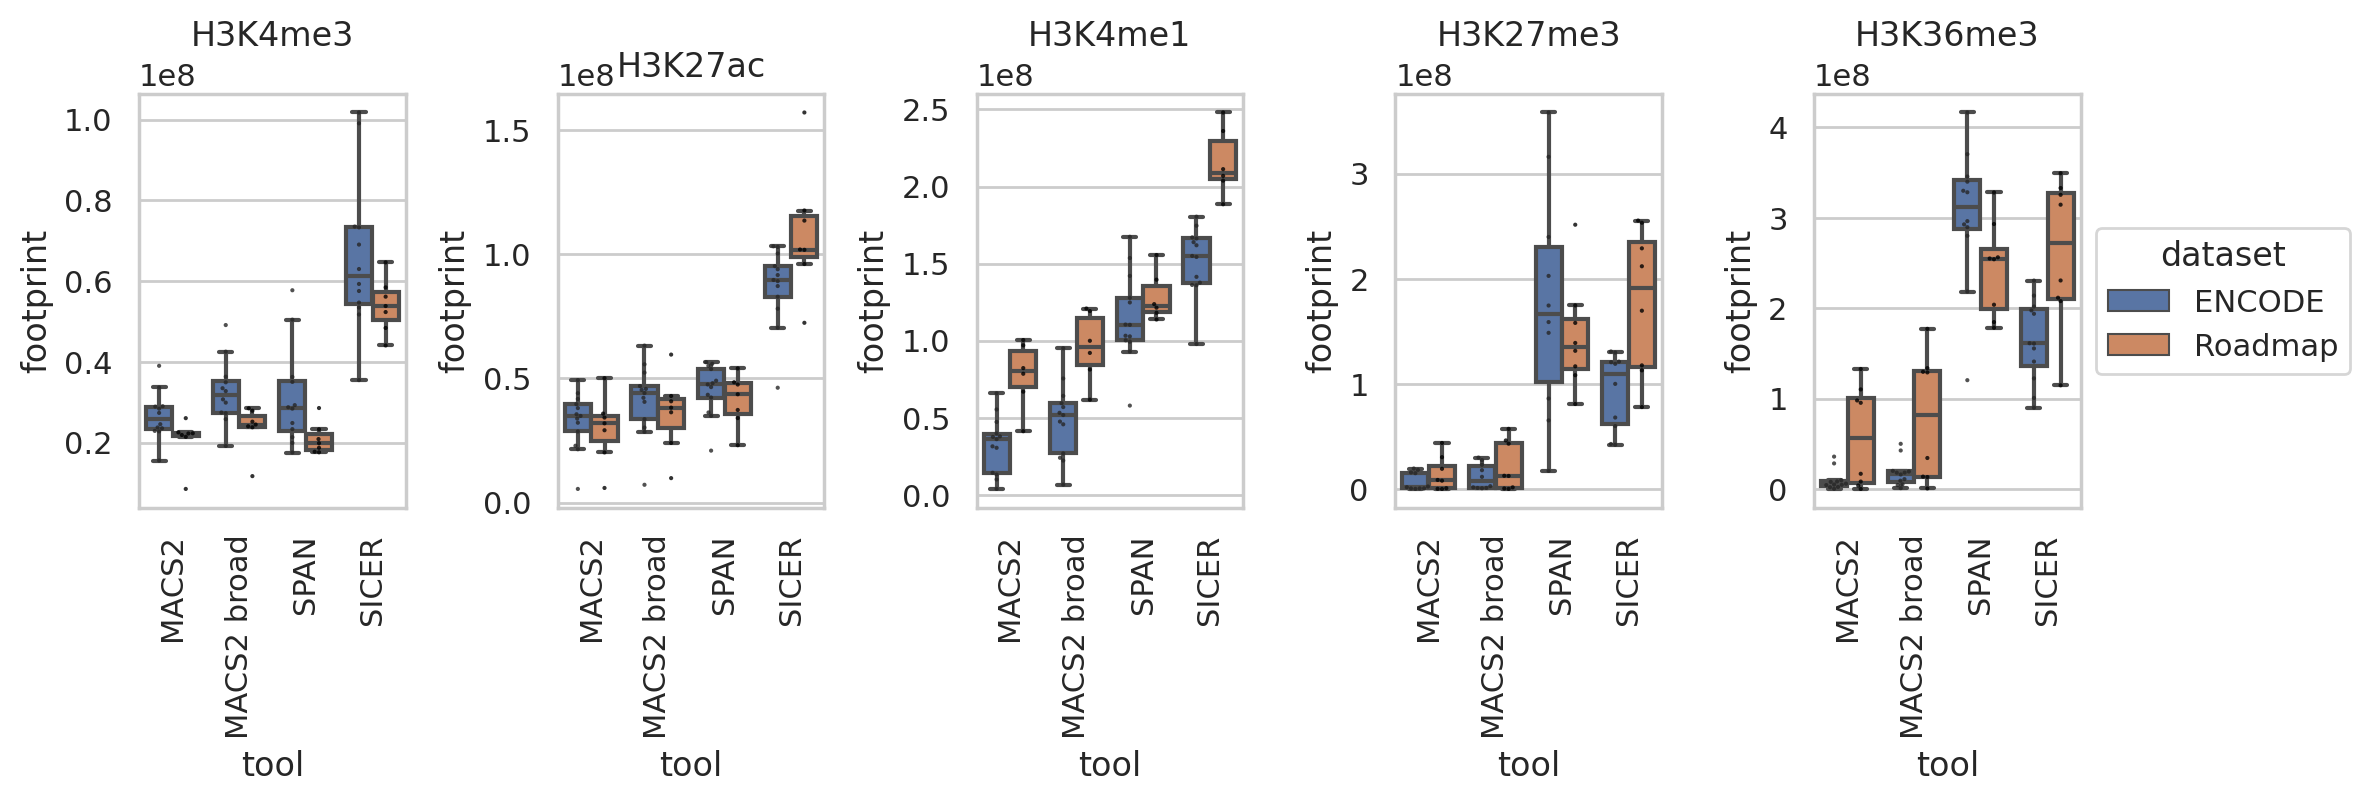

In [53]:
plt.figure(figsize=(12, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_lens_aggr[df_lens_aggr['modification'] == m], x='tool', y='footprint', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                hue_order=['ENCODE', 'Roadmap'],
                ax=ax)
    sns.swarmplot(data=df_lens_aggr[df_lens_aggr['modification'] == m], x='tool', y='footprint', hue='dataset',
                  dodge=True, size=1.5, palette='dark:black', alpha=0.8, legend=False,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  hue_order=['ENCODE', 'Roadmap'],
                  ax=ax)
    ax.title.set_text(m)
    # ax.set(yscale='log')

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # if m not in ['H3K27me3', 'H3K36me3']:
    #     ax.set_ylim(1, 4e3)
    # else:
    #     ax.set_ylim(1, 1.7e4)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K36me3


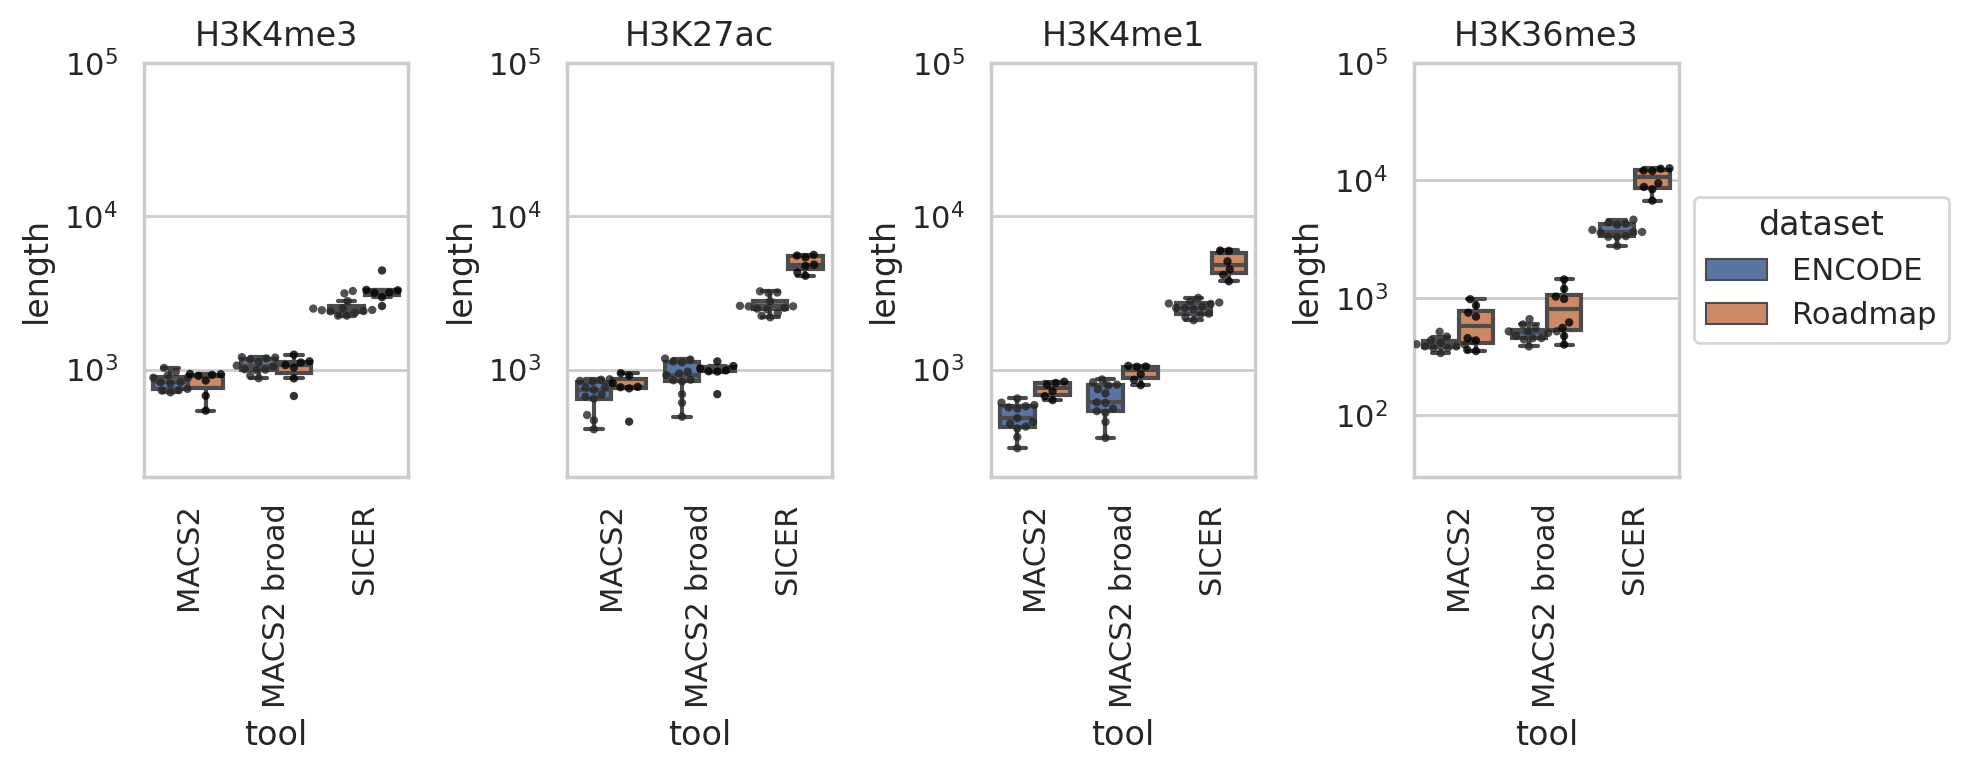

In [54]:
plt.figure(figsize=(10, 4))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_lens_aggr[df_lens_aggr['modification'] == m], x='tool', y='length', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SICER'],
                hue_order=['ENCODE', 'Roadmap'],
                ax=ax)
    sns.swarmplot(data=df_lens_aggr[df_lens_aggr['modification'] == m], x='tool', y='length', hue='dataset',
                  dodge=True, size=3,
                  palette='dark:black', alpha=0.8, legend=False,
                  order=['MACS2', 'MACS2 broad', 'SICER'],
                  hue_order=['ENCODE', 'Roadmap'],
                  ax=ax)
    ax.title.set_text(m)
    # ax.set(yscale='log')

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if m not in ['H3K27me3', 'H3K36me3']:
        ax.set_ylim(bottom=200, top=1e5)
    else:
        ax.set_ylim(bottom=30, top=1e5)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

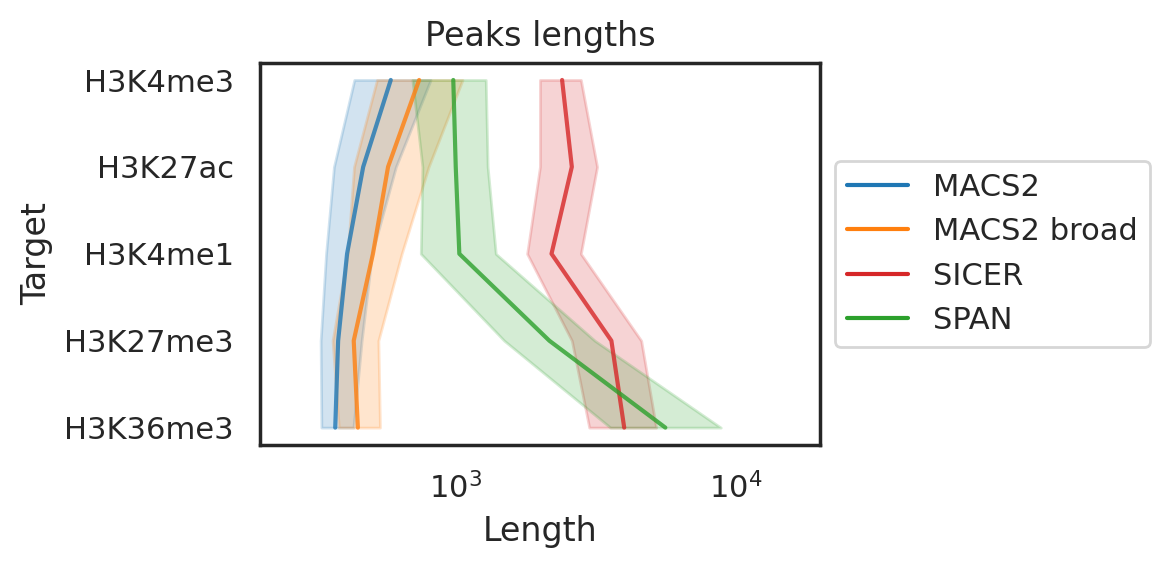

In [55]:
sns.set_theme(style="white")
df_lens['mindex'] = 0
for i, m in enumerate(reversed(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'])):
    df_lens.loc[df_lens['modification'] == m, 'mindex'] = i
plt.figure(figsize=(6, 3))
g_results = sns.lineplot(data=df_lens.sort_values(by=['mindex', 'tool', 'length']),
                         x='length', y='mindex', hue='tool', orient='y', estimator='median',
                         alpha=0.8,
                         palette=TOOLS_PALETTE,
                         errorbar=('pi', 25),
                         # marker='o', markersize=1
                         )
g_results.axes.set_yticks(range(5), minor=False)
g_results.axes.set_yticklabels(reversed(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']))
g_results.axes.set_ylabel('Target')
g_results.axes.set_xlabel('Length')
g_results.set(xscale='log')
g_results.set_xlim(200, 2e4)
g_results.axes.title.set_text(f'Peaks lengths')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(f'{ENCODE_REPROCESSED_PATH}/pics/lengths_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

## ATAC-seq, CTCF

In [56]:
def simple_load_peaks(path, suffix):
    df = pd.DataFrame(columns=['file', 'peaks'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        file = os.path.join(path, f)
        ps = lines(file)
        df.loc[len(df)] = (file, ps)
    return df


def simple_load_peaks_path(path):
    df_macs2 = simple_load_peaks(os.path.join(path, 'macs2'), '.narrowPeak')
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2_broad = simple_load_peaks(os.path.join(path, 'macs2'), '.broadPeak')
    df_macs2_broad['tool'] = 'MACS2 broad'
    print('MACS2', len(df_macs2_broad))

    df_sicer = simple_load_peaks(os.path.join(path, 'sicer'), '.scoreisland')
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = simple_load_peaks(os.path.join(path, 'span'), '.peak')
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2_broad, df_sicer, df_span]).reset_index(drop=True)

In [58]:
ATAC_PATH = os.path.expanduser('~/data/2024_Immgen')
dfa = simple_load_peaks_path(ATAC_PATH)
# Pick ATAC-seq file without ATAC-seq clusters
# dfa = dfa[dfa['file'].str.contains('brain_Microglia')]
dfa.sample(3)

  0%|          | 0/64 [00:00<?, ?it/s]

MACS2 8


  0%|          | 0/64 [00:00<?, ?it/s]

MACS2 8


  0%|          | 0/6 [00:00<?, ?it/s]

SICER 6


  0%|          | 0/89 [00:00<?, ?it/s]

SPAN 8


file  peaks   tool
28  /home/jetbrains/data/2024_Immgen/span/SRR57995...  49610   SPAN
27  /home/jetbrains/data/2024_Immgen/span/SRR57994...  35167   SPAN
17  /home/jetbrains/data/2024_Immgen/sicer/SRR5799...  31889  SICER

In [59]:
ts = []
for tool, file in tqdm(zip(dfa['tool'], dfa['file'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t.sort_values(by=['length'], inplace=True)
    # t = t.iloc[int(len(t) * 0.1):int(len(t) * 0.9)].copy()
    t = t.sample(min(len(t), 20_000)).copy()
    t['tool'] = tool
    ts.append(t)
dfa_lens = pd.concat(ts).reset_index(drop=True)
del ts
dfa_lens.sample(10)

0it [00:00, ?it/s]

length         tool
293102     516  MACS2 broad
338605    3599        SICER
491007     170         SPAN
521039     130         SPAN
152502     304        MACS2
67344       96        MACS2
187917     350  MACS2 broad
361929    1799        SICER
17975      198        MACS2
378096    1199        SICER

In [60]:
CTCF_PATH = os.path.expanduser('~/data/2024_TFs')
df_ctcf = simple_load_peaks_path(CTCF_PATH)
df_ctcf

  0%|          | 0/8 [00:00<?, ?it/s]

MACS2 1


  0%|          | 0/8 [00:00<?, ?it/s]

MACS2 1


  0%|          | 0/1 [00:00<?, ?it/s]

SICER 1


  0%|          | 0/12 [00:00<?, ?it/s]

SPAN 1


file   peaks         tool
0  /home/jetbrains/data/2024_TFs/macs2/H1_CTCF_hg...   95602        MACS2
1  /home/jetbrains/data/2024_TFs/macs2/H1_CTCF_hg...   98214  MACS2 broad
2  /home/jetbrains/data/2024_TFs/sicer/H1_CTCF_hg...   69006        SICER
3  /home/jetbrains/data/2024_TFs/span/H1_CTCF_hg3...  100322         SPAN

In [61]:
ts = []
for tool, file in tqdm(zip(df_ctcf['tool'], df_ctcf['file'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['tool'] = tool
    ts.append(t)
dfa_ctcf_lens = pd.concat(ts).reset_index(drop=True)
del ts
dfa_ctcf_lens.sample(10)

0it [00:00, ?it/s]

length         tool
7484      216        MACS2
7775      297        MACS2
23589    3199        SICER
10805     157  MACS2 broad
22506     399        SICER
3816      418        MACS2
20393     799        SICER
23599     399        SICER
22476    4599        SICER
12372     199  MACS2 broad

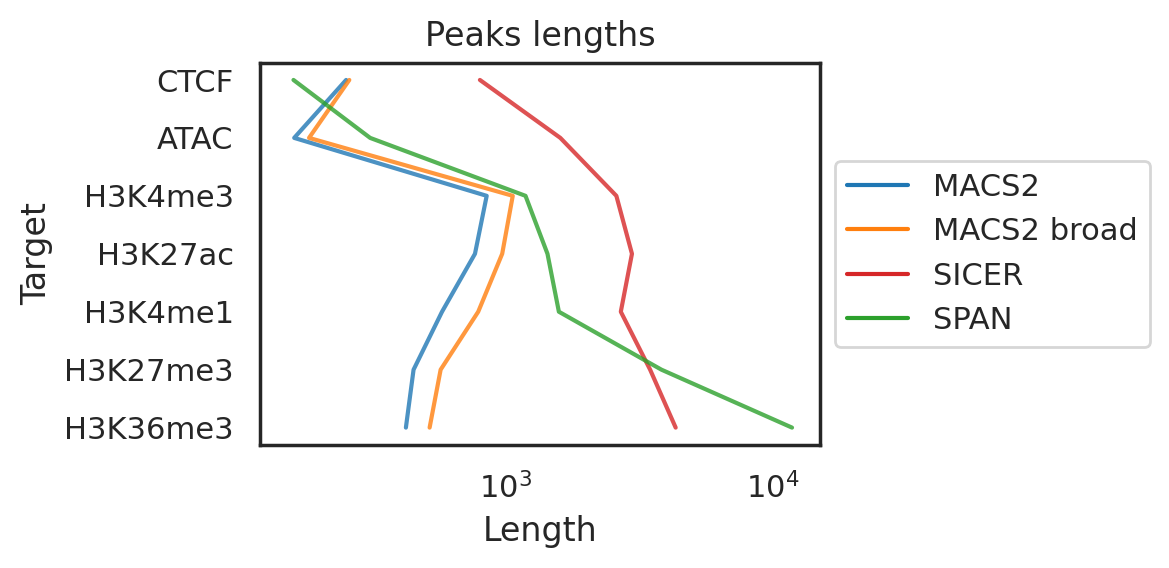

In [76]:
dfa_lens['modification'] = 'ATAC'
dfa_ctcf_lens['modification'] = 'CTCF'
t = pd.concat([dfa_ctcf_lens, df_lens_aggr, dfa_lens]).reset_index(drop=True)

sns.set_theme(style="white")
t['mindex'] = 0
for i, m in enumerate(reversed(['CTCF', 'ATAC', 'H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'])):
    t.loc[t['modification'] == m, 'mindex'] = i
plt.figure(figsize=(6, 3))
g_results = sns.lineplot(data=t.sort_values(by=['mindex', 'tool', 'length']),
                         x='length', y='mindex', hue='tool', orient='y', estimator='median',
                         alpha=0.8,
                         palette=TOOLS_PALETTE,
                         errorbar=None,
                         # marker='o', markersize=1
                         )
g_results.axes.set_yticks(range(7), minor=False)
g_results.axes.set_yticklabels(reversed(['CTCF', 'ATAC', 'H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']))
g_results.axes.set_ylabel('Target')
g_results.axes.set_xlabel('Length')
g_results.set(xscale='log')
g_results.set_xlim(120, 1.5e4)
g_results.axes.title.set_text(f'Peaks lengths')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(f'{ENCODE_REPROCESSED_PATH}/pics/lengths_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Difference

In [63]:
def compute_diffs(df, modifications, cells, replicates):
    tools = df['tool'].unique()
    rows = []
    tf = tempfile.mktemp()
    for m, c, r in tqdm(list(product(modifications, cells, replicates))):
        print(m, c, r)
        t = df[(df['modification'] == m) & (df['cell'] == c) & (df['replicate'] == r) & (df['tool'] == 'SPAN')]
        if len(t) != 1:
            continue
        span_file = sorted_file(t['file'].values[0])
        # Processing single tools information
        for tool in tools:
            if tool == 'SPAN':
                continue
            t = df[(df['modification'] == m) & (df['cell'] == c) & (df['replicate'] == r) & (df['tool'] == tool)]
            if len(t) != 1:
                continue
            peaks_file = sorted_file(t['file'].values[0])
            for name, args in [
                (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
                (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
                !bedtools intersect {args} -wa -v > {tf}
                peaks = lines(tf)
                rows.append((m, c, r, name, peaks))

    return pd.DataFrame(rows, columns=['modification', 'cell', 'replicate', 'name', 'peaks'])

In [64]:
df_encode_5m_diff = compute_diffs(df_encode_5m_peaks, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_5m_diff.sample(5)

  0%|          | 0/90 [00:00<?, ?it/s]

H3K4me3 GM12878 rep1
H3K4me3 GM12878 rep2
H3K4me3 HMEC rep1
H3K4me3 HMEC rep2
H3K4me3 HSMM rep1
H3K4me3 HSMM rep2
H3K4me3 K562 rep1
H3K4me3 K562 rep2
H3K4me3 NHEK rep1
H3K4me3 NHEK rep2
H3K4me3 NHLF rep1
H3K4me3 NHLF rep2
H3K4me3 H1 rep1
H3K4me3 H1 rep2
H3K4me3 Huvec rep1
H3K4me3 Huvec rep2
H3K4me3 HepG2 rep1
H3K4me3 HepG2 rep2
H3K27ac GM12878 rep1
H3K27ac GM12878 rep2
H3K27ac HMEC rep1
H3K27ac HMEC rep2
H3K27ac HSMM rep1
H3K27ac HSMM rep2
H3K27ac K562 rep1
H3K27ac K562 rep2
H3K27ac NHEK rep1
H3K27ac NHEK rep2
H3K27ac NHLF rep1
H3K27ac NHLF rep2
H3K27ac H1 rep1
H3K27ac H1 rep2
H3K27ac Huvec rep1
H3K27ac Huvec rep2
H3K27ac HepG2 rep1
H3K27ac HepG2 rep2
H3K4me1 GM12878 rep1
H3K4me1 GM12878 rep2
H3K4me1 HMEC rep1
H3K4me1 HMEC rep2
H3K4me1 HSMM rep1
H3K4me1 HSMM rep2
H3K4me1 K562 rep1
H3K4me1 K562 rep2
H3K4me1 NHEK rep1
H3K4me1 NHEK rep2
H3K4me1 NHLF rep1
H3K4me1 NHLF rep2
H3K4me1 H1 rep1
H3K4me1 H1 rep2
H3K4me1 Huvec rep1
H3K4me1 Huvec rep2
H3K4me1 HepG2 rep1
H3K4me1 HepG2 rep2
H3K27me3 G

modification   cell replicate                name  peaks
144      H3K27ac  HepG2      rep1        SPAN - MACS2   4664
174      H3K4me1   HSMM      rep2        SPAN - MACS2  84613
13       H3K4me3   HMEC      rep2        MACS2 - SPAN   2041
224      H3K4me1  HepG2      rep1  SPAN - MACS2 broad  14681
243     H3K27me3   HMEC      rep2  MACS2 broad - SPAN     92

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


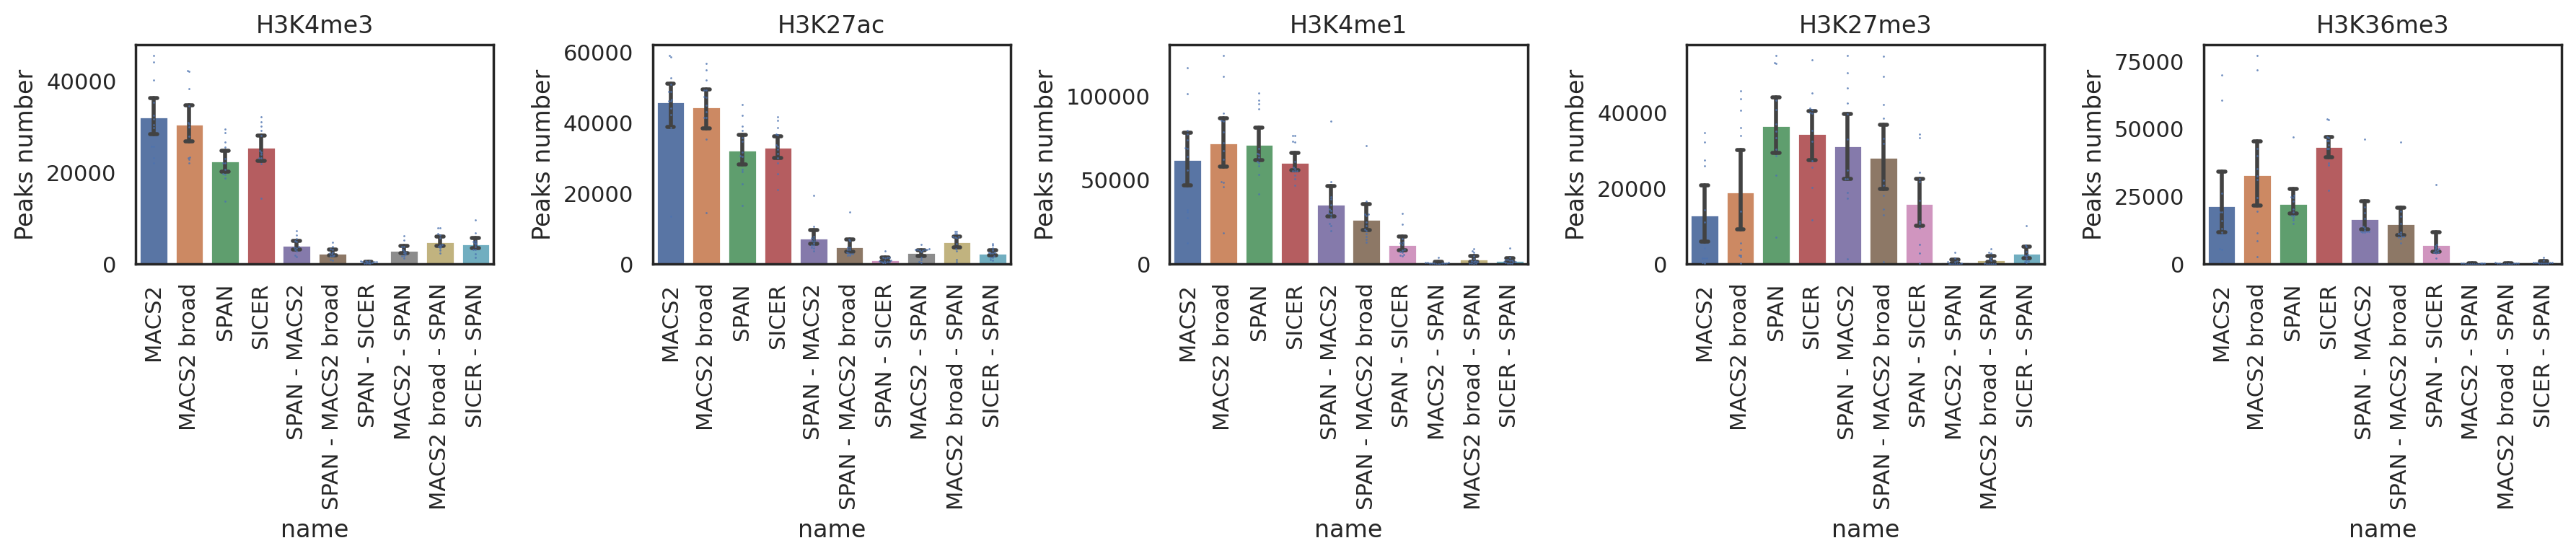

In [65]:
t = df_encode_5m_peaks[['modification', 'cell', 'replicate', 'tool', 'peaks']].copy()
t.rename({'tool': 'name'}, axis=1, inplace=True)
t = pd.concat([t, df_encode_5m_diff]).reset_index(drop=True)

plt.figure(figsize=(18, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]

for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    print(m)
    ax.title.set_text(m)
    sns.barplot(data=t[t['modification'] == m], x='name', y='peaks',
                capsize=.2, errwidth=2,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ],
                ax=ax)
    sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',
                  dodge=True, size=1, alpha=0.8,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                         'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                         'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                         ],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.show()

In [66]:
t = df_encode_5m_diff[(df_encode_5m_diff['modification'] == 'H3K4me3') & 
                      (df_encode_5m_diff['name'] == 'MACS2 broad - SPAN')].copy()
# t.sort_values(['peaks'], ascending=False, inplace=True)
t.head()


modification     cell replicate                name  peaks
3       H3K4me3  GM12878      rep1  MACS2 broad - SPAN   2918
9       H3K4me3  GM12878      rep2  MACS2 broad - SPAN   7910
15      H3K4me3     HMEC      rep2  MACS2 broad - SPAN   4091
21      H3K4me3     HSMM      rep1  MACS2 broad - SPAN   3744
27      H3K4me3     HSMM      rep2  MACS2 broad - SPAN   3386

In [67]:
df_immune_10m_diff = compute_diffs(df_immune_10m_peaks, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_10m_diff.sample(5)

  0%|          | 0/180 [00:00<?, ?it/s]

H3K4me3 CD4ABT rep1
H3K4me3 CD4ABT rep2
H3K4me3 CD4ABT rep3
H3K4me3 CD4ABT 
H3K4me3 TCellBB rep1
H3K4me3 TCellBB rep2
H3K4me3 TCellBB rep3
H3K4me3 TCellBB 
H3K4me3 BCell rep1
H3K4me3 BCell rep2
H3K4me3 BCell rep3
H3K4me3 BCell 
H3K4me3 TCell rep1
H3K4me3 TCell rep2
H3K4me3 TCell rep3
H3K4me3 TCell 
H3K4me3 Monocyte rep1
H3K4me3 Monocyte rep2
H3K4me3 Monocyte rep3
H3K4me3 Monocyte 
H3K4me3 PBMC rep1
H3K4me3 PBMC rep2
H3K4me3 PBMC rep3
H3K4me3 PBMC 
H3K4me3 NK rep1
H3K4me3 NK rep2
H3K4me3 NK rep3
H3K4me3 NK 
H3K4me3 CD34 rep1
H3K4me3 CD34 rep2
H3K4me3 CD34 rep3
H3K4me3 CD34 
H3K4me3 CD4 rep1
H3K4me3 CD4 rep2
H3K4me3 CD4 rep3
H3K4me3 CD4 
H3K27ac CD4ABT rep1
H3K27ac CD4ABT rep2
H3K27ac CD4ABT rep3
H3K27ac CD4ABT 
H3K27ac TCellBB rep1
H3K27ac TCellBB rep2
H3K27ac TCellBB rep3
H3K27ac TCellBB 
H3K27ac BCell rep1
H3K27ac BCell rep2
H3K27ac BCell rep3
H3K27ac BCell 
H3K27ac TCell rep1
H3K27ac TCell rep2
H3K27ac TCell rep3
H3K27ac TCell 
H3K27ac Monocyte rep1
H3K27ac Monocyte rep2
H3K27ac Mono

modification      cell replicate                name  peaks
88       H3K27ac       CD4                  SPAN - SICER   3166
11       H3K4me3     TCell                  SICER - SPAN    286
167     H3K27me3      CD34      rep2        SICER - SPAN   4893
134     H3K27me3     BCell            SPAN - MACS2 broad  26896
106      H3K4me1  Monocyte                  SPAN - SICER  20222

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


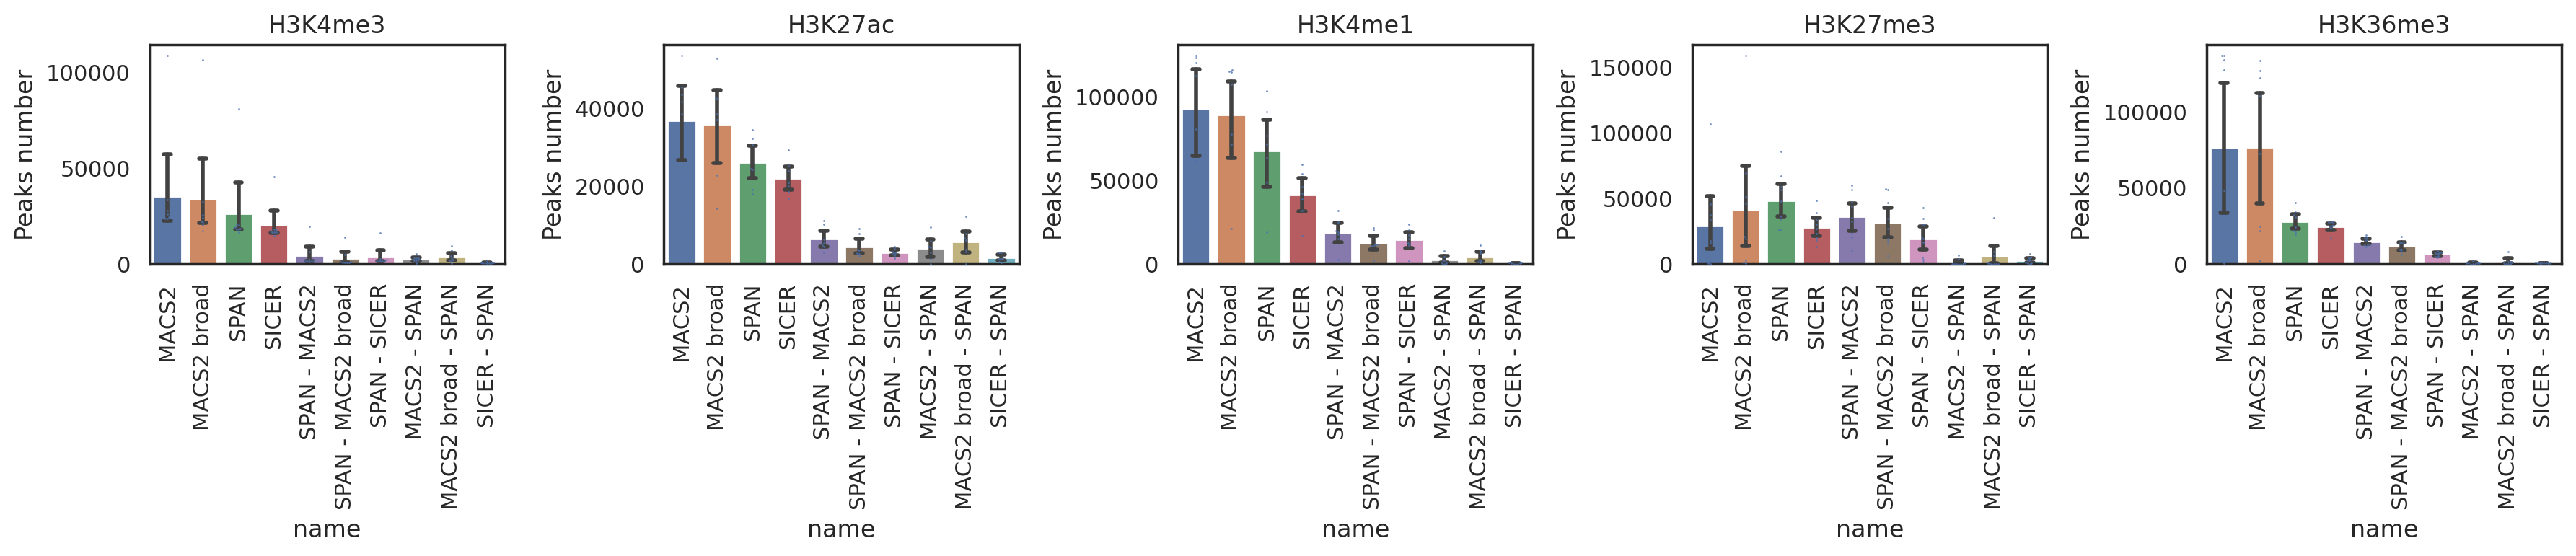

In [68]:
t = df_immune_10m_peaks[['modification', 'cell', 'replicate', 'tool', 'peaks']].copy()
t.rename({'tool': 'name'}, axis=1, inplace=True)
t = pd.concat([t, df_immune_10m_diff]).reset_index(drop=True)

plt.figure(figsize=(18, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]

for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    print(m)
    ax.title.set_text(m)
    sns.barplot(data=t[t['modification'] == m], x='name', y='peaks',
                capsize=.2, errwidth=2,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ],
                ax=ax)
    sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',
                  dodge=True, size=1, alpha=0.8,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                         'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                         'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                         ],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.show()

# Replicates

In [69]:
def compute_reps_overlap(df_peaks):
    reps_overlap = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2',
                                         'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                         'peaks1_overlap', 'peaks2_overlap', 'peaks_overlap_len'], dtype=object)

    tf = tempfile.mktemp()

    
    for (m, c, t), group in df_peaks.groupby(['modification', 'cell', 'tool']):
        if len(group) != 2:
            continue
        print(m, c, t)
        reps = list(sorted(set(group['replicate'])))
        for i in range(len(reps)):
            for j in range(i + 1, len(reps)):
                rep1, rep2 = reps[i], reps[j]
                t1 = group[group['replicate'] == rep1]
                t2 = group[group['replicate'] == rep2]
                if len(t1) == 0 or len(t2) == 0:
                    continue
                file1 = sorted_file(t1['file'].values[0])
                file2 = sorted_file(t2['file'].values[0])
                peaks1 = t1['peaks'].values[0]
                peaks1_len = int(bedl(file1).sum())
                peaks2 = t2['peaks'].values[0]
                peaks2_len = int(bedl(file2).sum())
                !bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
                overlap1 = lines(tf)
                !bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
                overlap2 = lines(tf)
                !bedtools intersect -a {file1} -b {file2} -wo > {tf}
                overlap_len = int(last_col(tf).sum())

                reps_overlap.loc[len(reps_overlap)] = \
                    (m, c, t, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                     overlap1, overlap2, overlap_len)
    reps_overlap['jaccard'] = [
        d(lo, l1 + l2 - lo)
        for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks_overlap_len'])
    ]
    return reps_overlap

In [70]:
df_encode_reps = compute_reps_overlap(df_encode_5m_peaks)
df_encode_reps.sample(5)

H3K27ac GM12878 MACS2
H3K27ac GM12878 MACS2 broad
H3K27ac GM12878 SICER
H3K27ac GM12878 SPAN
H3K27ac HSMM MACS2
H3K27ac HSMM MACS2 broad
H3K27ac HSMM SICER
H3K27ac HSMM SPAN
H3K27ac K562 MACS2
H3K27ac K562 MACS2 broad
H3K27ac K562 SICER
H3K27ac K562 SPAN
H3K27ac NHEK MACS2
H3K27ac NHEK MACS2 broad
H3K27ac NHEK SICER
H3K27ac NHEK SPAN
H3K27me3 GM12878 MACS2
H3K27me3 GM12878 MACS2 broad
H3K27me3 GM12878 SICER
H3K27me3 GM12878 SPAN
H3K27me3 HSMM MACS2
H3K27me3 HSMM MACS2 broad
H3K27me3 HSMM SICER
H3K27me3 HSMM SPAN
H3K27me3 K562 MACS2
H3K27me3 K562 MACS2 broad
H3K27me3 K562 SICER
H3K27me3 K562 SPAN
H3K27me3 NHEK MACS2
H3K27me3 NHEK MACS2 broad
H3K27me3 NHEK SICER
H3K27me3 NHEK SPAN
H3K36me3 GM12878 MACS2
H3K36me3 GM12878 MACS2 broad
H3K36me3 GM12878 SICER
H3K36me3 GM12878 SPAN
H3K36me3 HSMM MACS2
H3K36me3 HSMM MACS2 broad
H3K36me3 HSMM SICER
H3K36me3 HSMM SPAN
H3K36me3 K562 MACS2
H3K36me3 K562 MACS2 broad
H3K36me3 K562 SICER
H3K36me3 K562 SPAN
H3K4me1 GM12878 MACS2
H3K4me1 GM12878 MACS2 b

modification  cell         tool  rep1  rep2  peaks1  peaks1_len  peaks2  \
29     H3K27me3  NHEK  MACS2 broad  rep1  rep2   40596    29849317   33829   
40     H3K36me3  K562        MACS2  rep1  rep2   26194     9718266   19047   
28     H3K27me3  NHEK        MACS2  rep1  rep2   32229    19428101   25909   
9       H3K27ac  K562  MACS2 broad  rep1  rep2   41530    28445491   35389   
22     H3K27me3  HSMM        SICER  rep1  rep2   25448    59827952   39777   

    peaks2_len  peaks1_overlap  peaks2_overlap  peaks_overlap_len   jaccard  
29    23005220           14421           15509           12419422  0.307144  
40     7932625            5315            5262            1471215  0.090930  
28    15706456           12302           12586            8542807  0.321258  
9     33568702           28412           24868           21074748  0.514779  
22   119066423           16026           14821           32183238  0.219365

ENCODE 5M


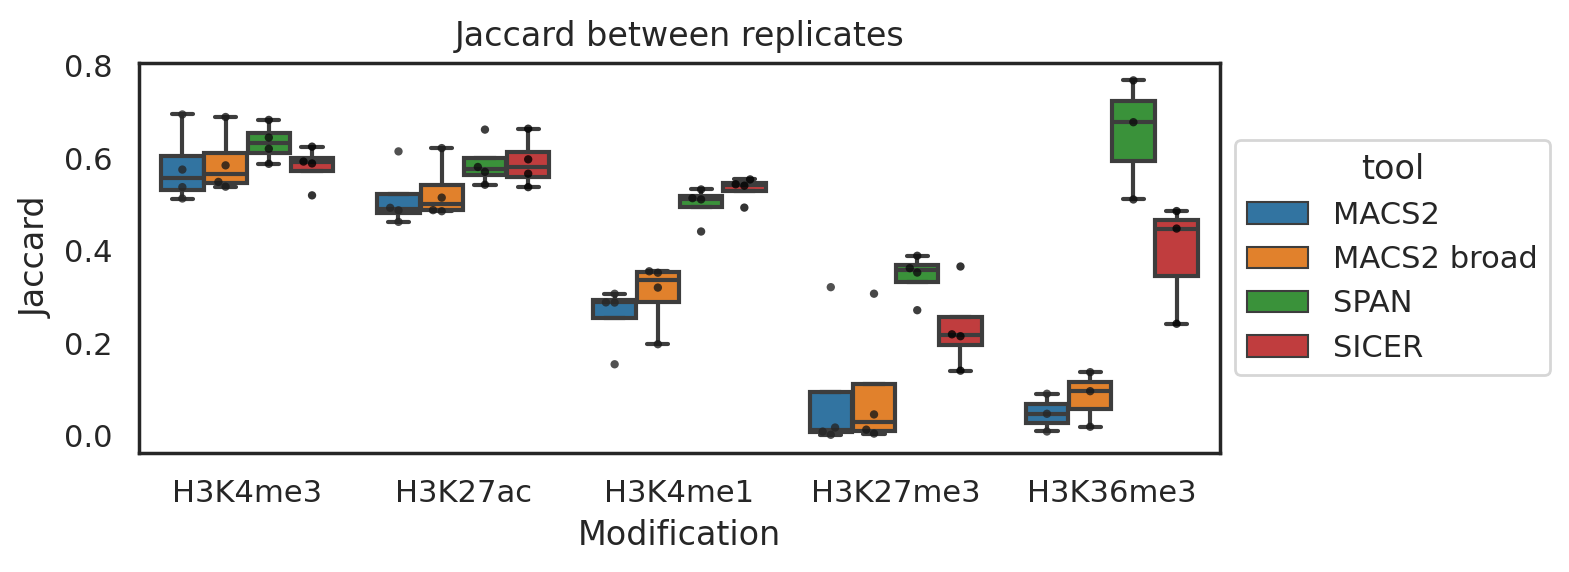

In [71]:
print('ENCODE 5M')
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_encode_reps, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_encode_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [72]:
df_immune_reps = compute_reps_overlap(df_immune_10m_peaks)
df_immune_reps.sample(3)

H3K27ac CD4 MACS2
H3K27ac CD4 MACS2 broad
H3K27ac CD4 SICER
H3K27ac CD4 SPAN
H3K27me3 CD34 MACS2
H3K27me3 CD34 MACS2 broad
H3K27me3 CD34 SICER
H3K27me3 CD34 SPAN
H3K27me3 CD4 MACS2
H3K27me3 CD4 MACS2 broad
H3K27me3 CD4 SICER
H3K27me3 CD4 SPAN
H3K36me3 CD34 MACS2
H3K36me3 CD34 MACS2 broad
H3K36me3 CD34 SICER
H3K36me3 CD34 SPAN
H3K36me3 CD4 MACS2
H3K36me3 CD4 MACS2 broad
H3K36me3 CD4 SICER
H3K36me3 CD4 SPAN
H3K4me1 CD4 MACS2
H3K4me1 CD4 MACS2 broad
H3K4me1 CD4 SICER
H3K4me1 CD4 SPAN
H3K4me3 CD34 MACS2
H3K4me3 CD34 MACS2 broad
H3K4me3 CD34 SICER
H3K4me3 CD34 SPAN


modification  cell         tool rep1  rep2  peaks1  peaks1_len  peaks2  \
17     H3K36me3   CD4  MACS2 broad       rep1   24558    13699417    1604   
4      H3K27me3  CD34        MACS2       rep2   17350     8572435   37274   
21      H3K4me1   CD4  MACS2 broad       rep1   77653    81271571   71458   

    peaks2_len  peaks1_overlap  peaks2_overlap  peaks_overlap_len   jaccard  
17      640478            1066            1076             364382  0.026073  
4     30249341           15675           10928            7449550  0.237457  
21    61693905           50790           58221           49051686  0.522305

Immune 10M


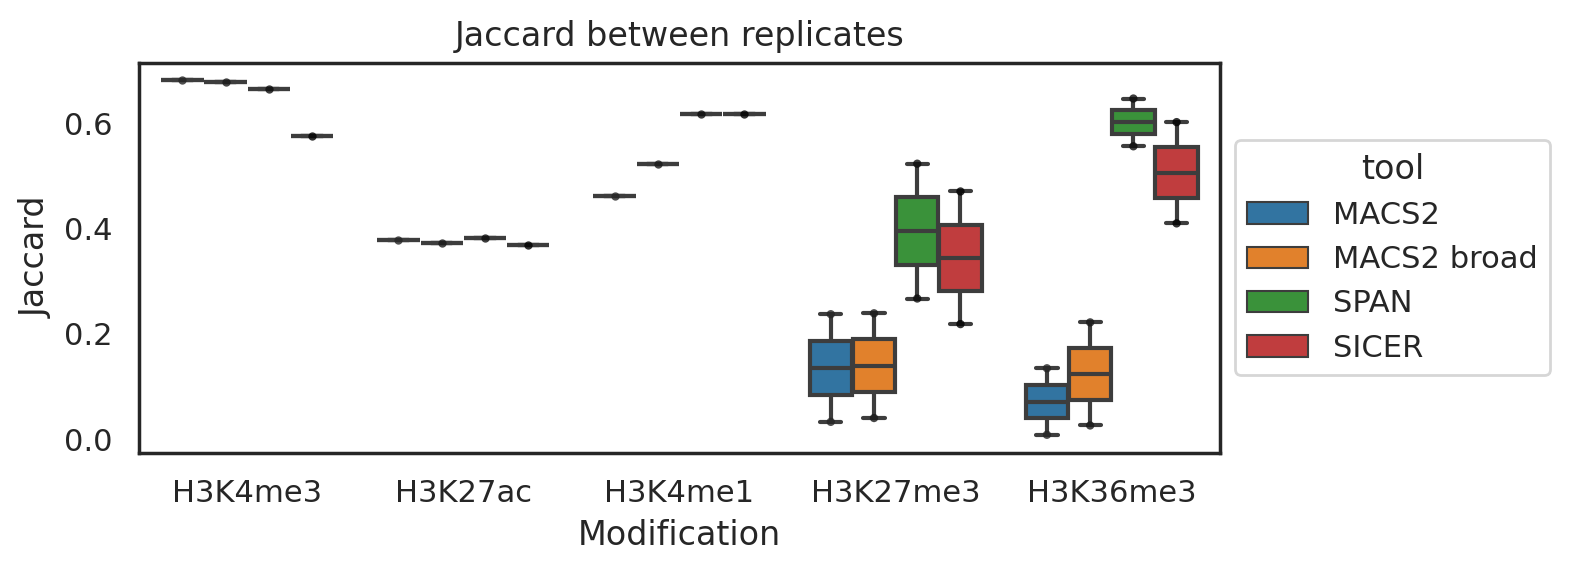

In [73]:
print('Immune 10M')
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_immune_reps, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_immune_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

ENCODE + Roadmap


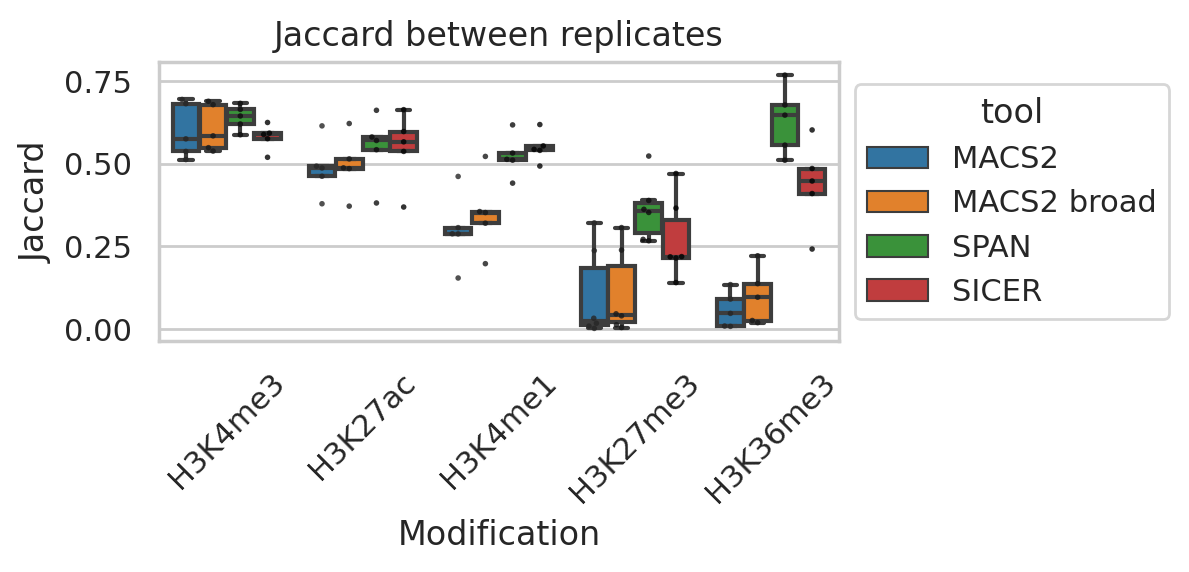

In [74]:
sns.set_style("whitegrid")
t = pd.concat([df_encode_reps, df_immune_reps]).reset_index(drop=True)
print('ENCODE + Roadmap')
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            order=MODIFICATIONS,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t, x='modification', hue='tool', y='jaccard',
              dodge=True, size=2, palette='dark:black', alpha=0.8,
              order=MODIFICATIONS,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False,
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
ax.xaxis.set_tick_params(rotation=45)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Bigwig

In [77]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}


def load_bws(path, modification, cells, replicates, control='Input'):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        mod = next((m for m in modification if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        if mod and cell and rep is not None:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), mod, cell, rep)
    return df_bws



In [78]:
encode_bws = load_bws(ENCODE_LIM_PATH + '/bw', MODIFICATIONS + ['control'], GSE26320_CELLS, GSE26320_REPS, 'control')
encode_bws['dataset'] = 'ENCODE'

immune_bws = load_bws(IMMUNE_LIM_PATH + '/bw', MODIFICATIONS + ['control'], IMMUNE_CELLS, IMMUNE_REPS, 'control')
immune_bws['dataset'] = 'Roadmap'

all_bws = pd.concat([encode_bws, immune_bws]).reset_index(drop=False)
display(all_bws.sample(3))

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

index                                               file modification  \
23      23  /home/jetbrains/data/2024_GSE26320_5M/bw/contr...      control   
118     43  /home/jetbrains/data/2024_Immune_10M/bw/contro...      control   
2        2  /home/jetbrains/data/2024_GSE26320_5M/bw/H3K4m...      H3K4me3   

      cell replicate  dataset  
23    NHLF      rep2   ENCODE  
118    CD4      rep2  Roadmap  
2    Huvec      rep1   ENCODE

In [79]:
import pyBigWig

total_coverages = {}
ts = []
for _, (ds, m, c, r) in tqdm(list(all_bws[['dataset', 'modification', 'cell', 'replicate']].iterrows())):
    print(ds, m, c, r)
    t = all_bws[(all_bws['modification'] == m) &
                (all_bws['cell'] == c) &
                (all_bws['replicate'] == r) &
                (all_bws['dataset'] == ds)]
    if len(t) == 0:
        continue
    bw_path = t['file'].values[0]
    # print(bw_path)

    try:
        with pyBigWig.open(bw_path) as bw:
            total_coverage = sum(
                bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr)
            print('Total coverage', total_coverage)
            # Multiplier to align BAM coverage with BigWig estimation
            total_coverage *= 1.1e-2
            total_coverages[(ds, m, c, r)] = total_coverage
    except Exception:
        pass
        # print('ERROR')

total_coverages_df = pd.DataFrame([(ds, m, c, r, n) for (ds, m, c, r), n in total_coverages.items()],
                                  columns=['dataset', 'modification', 'cell', 'replicate', 'reads'])
total_coverages_df.sample(5)

  0%|          | 0/125 [00:00<?, ?it/s]

ENCODE H3K4me1 NHLF rep2
Total coverage 412932888.0
ENCODE H3K27ac H1 rep1
Total coverage 414927238.0
ENCODE H3K4me3 Huvec rep1
Total coverage 477370150.0
ENCODE H3K27ac Huvec rep1
Total coverage 471691400.0
ENCODE H3K4me1 HMEC rep2
Total coverage 414767150.0
ENCODE H3K27ac K562 rep2
Total coverage 346068350.0
ENCODE H3K36me3 GM12878 rep1
Total coverage 477247319.0
ENCODE H3K27me3 K562 rep1
Total coverage 486295669.0
ENCODE H3K36me3 HMEC rep2
Total coverage 419067000.0
ENCODE H3K36me3 HSMM rep2
Total coverage 419590119.0
ENCODE H3K27me3 Huvec rep1
Total coverage 477590800.0
ENCODE control GM12878 rep2
Total coverage 493627635.0
ENCODE H3K4me3 NHLF rep2
Total coverage 405291800.0
ENCODE H3K4me1 NHEK rep2
Total coverage 420174700.0
ENCODE H3K27ac NHLF rep2
Total coverage 404089400.0
ENCODE H3K27me3 K562 rep2
Total coverage 390096238.0
ENCODE H3K36me3 HSMM rep1
Total coverage 417496950.0
ENCODE H3K27me3 NHLF rep2
Total coverage 409022700.0
ENCODE H3K4me3 H1 rep1
Total coverage 410392800.0

dataset modification      cell replicate        reads
97   Roadmap      H3K4me3     TCell            9340340.559
121  Roadmap      H3K4me3       CD4            9328596.618
75   Roadmap      control      CD34      rep2  9332913.458
51    ENCODE      H3K27ac      HSMM      rep1  4438373.159
92   Roadmap     H3K27me3  Monocyte            9339784.718

In [80]:
WD = os.path.expanduser('~/data/2023_wiggle')
BLACKLIST_PATH = WD + '/hg38-blacklist.v2.bed'
blacklist_df = pd.read_csv(BLACKLIST_PATH, sep='\t', header=None)
blacklist_df.rename({0: 'chr', 1: 'start', 2: 'end'}, axis=1, inplace=True)
blacklist_df

chr     start       end                   3
0    chr10         0     45700     Low Mappability
1    chr10  38481300  38596500  High Signal Region
2    chr10  38782600  38967900  High Signal Region
3    chr10  39901300  41712900  High Signal Region
4    chr10  41838900  42107300  High Signal Region
..     ...       ...       ...                 ...
631   chrY   4343800   4345800  High Signal Region
632   chrY  10246200  11041200  High Signal Region
633   chrY  11072100  11335300  High Signal Region
634   chrY  11486600  11757800  High Signal Region
635   chrY  26637300  57227400  High Signal Region

[636 rows x 4 columns]

# BigWig stats

In [81]:
def collect_bw_stats(bw_path, control_bw_path, chrom_sizes, blacklist, region, top_regions, work_regions, resolution):
    print('Prepare chromosome indexes')
    chr_indx = {}
    indx = 0
    for chr, chr_size in chrom_sizes.items():
        if '_' in chr:
            continue
        bins = int(math.floor(chr_size / region))
        chr_indx[chr] = (indx, indx + bins)
        indx += bins
    chromosomes = list(chr_indx.keys())

    print('Compute coverage in regions')
    region_coverages = np.zeros(indx)
    with pyBigWig.open(bw_path) as bw:
        for chr, (istart, iend) in chr_indx.items():
            region_coverages[istart: iend] = \
                np.array(
                    [x or 0 for x in bw.stats(chr, 1, CHROM_SIZES[chr], nBins=iend - istart, exact=True, type='sum')])

    print('Processing blacklisted regions')
    blacklist_marked = 0
    for chr, start, end in zip(blacklist['chr'], blacklist['start'], blacklist['end']):
        if chr not in chr_indx:
            continue
        offset = chr_indx[chr][0]
        for x in range(int(math.floor(start / region)), int(math.ceil(end / region)) + 1):
            region_coverages[min(x - offset, len(region_coverages) - 1)] = 0
            blacklist_marked += 1
    print(f'Marked {blacklist_marked} / {len(region_coverages)} bins as blacklist')

    if top_regions > len(region_coverages):
        raise Exception(f'Too many top regions {top_regions} > {len(region_coverages)}')

    print('Split by chromosomes')
    chr_xs = [[] for _ in range(len(chr_indx))]  # Create new array for each chromosome index
    ichr = 0
    for x in np.sort(np.argpartition(region_coverages, -top_regions)[-top_regions:]):
        while chr_indx[chromosomes[ichr]][1] < x:
            ichr += 1
        chr_xs[ichr].append(x)

    print('Collect final regions')
    peaks = []
    for ichr, xs in enumerate(chr_xs):
        chr = chromosomes[ichr]
        offset = chr_indx[chr][0]
        for i, x in enumerate(xs):
            peaks.append((chr, (x - offset) * region, (x + 1 - offset) * region))
    df = pd.DataFrame(peaks, columns=['chromosome', 'start', 'end'])
    if len(df) > work_regions:
        print(f'Pick {work_regions} / {top_regions} uniform regions for computation speedup')
        step = int(math.ceil(len(df) / float(work_regions)))
        df = df.iloc[range(0, len(df), step)].copy()

    print('Collecting bigwig stats')
    sums, means, stds, control_sums, control_means, control_stds = [], [], [], [], [], []
    with pyBigWig.open(bw_path) as bw:
        with pyBigWig.open(control_bw_path) as cbw:
            for _, (chr, start, end) in df.iterrows():
                stats = np.array(bw.stats(
                    chr, start, end, nBins=int(math.ceil((end - start) / resolution)), exact=True, type='sum'))
                sums.append(np.sum(stats))
                means.append(np.mean(stats))
                stds.append(np.std(stats))
                control_stats = np.array(cbw.stats(
                    chr, start, end, nBins=int(math.ceil((end - start) / resolution)), exact=True, type='sum'))
                control_sums.append(np.sum(control_stats))
                control_means.append(np.mean(control_stats))
                control_stds.append(np.std(control_stats))
    df['sum'] = sums
    df['mean'] = means
    df['std'] = stds
    df['control_sum'] = control_sums
    df['control_mean'] = control_means
    df['control_std'] = control_stds
    return df

In [84]:
REGION = 10_000
TOP_REGIONS = 10_000
WORK_REGIONS = 200
RESOLUTION = 100

# Compute on top chromosomes for speed
chrom_sizes_part = {f'chr{i + 1}': CHROM_SIZES[f'chr{i + 1}'] for i in range(3)}

ts = []
for _, (bw_path, ds, m, c, r) in tqdm(
        list(all_bws[['file', 'dataset', 'modification', 'cell', 'replicate']].iterrows())):
    print(bw_path, ds, m, c, r)
    if m == 'control':
        continue
    cr = r
    ct = all_bws[(all_bws['modification'] == 'control') &
                 (all_bws['cell'] == c) &
                 (all_bws['replicate'] == cr) &
                 (all_bws['dataset'] == ds)]
    # Control can be different for Roadmap
    if len(ct) == 0:
        cr = ''
        ct = all_bws[(all_bws['modification'] == 'control') &
                     (all_bws['cell'] == c) &
                     (all_bws['replicate'] == cr) &
                     (all_bws['dataset'] == ds)]
    if len(ct) == 0:
        continue
    print(ds, m, c, r, bw_path)
    cbw_path = ct['file'].values[0]
    print(bw_path, cbw_path)
    df = collect_bw_stats(bw_path, cbw_path, chrom_sizes_part, blacklist_df, 
                          REGION, TOP_REGIONS, WORK_REGIONS,
                          RESOLUTION)
    df['dataset'] = ds
    df['modification'] = m
    df['cell'] = c
    df['replicate'] = r
    df['control_replicate'] = cr
    df['rpkm'] = df['sum'] / ((REGION / 1e3) * ((total_coverages[(ds, m, c, r)]) / 1e6))
    df['control_reads'] = total_coverages[(ds, 'control', c, cr)]
    df['control_rpkm'] = df['control_sum'] / ((REGION / 1e3) * ((total_coverages[(ds, 'control', c, cr)]) / 1e6))
    df['signal_to_control'] = [d(s, c) for s, c in zip(df['rpkm'], df['control_rpkm'])]
    ts.append(df)
df_bw_stats = pd.concat(ts).reset_index(drop=True)
df_bw_stats.sample(5)

  0%|          | 0/125 [00:00<?, ?it/s]

/home/jetbrains/data/2024_GSE26320_5M/bw/H3K4me1_NHLF_rep2.bw ENCODE H3K4me1 NHLF rep2
ENCODE H3K4me1 NHLF rep2 /home/jetbrains/data/2024_GSE26320_5M/bw/H3K4me1_NHLF_rep2.bw
/home/jetbrains/data/2024_GSE26320_5M/bw/H3K4me1_NHLF_rep2.bw /home/jetbrains/data/2024_GSE26320_5M/bw/control_NHLF_rep2.bw
Prepare chromosome indexes
Compute coverage in regions
Processing blacklisted regions
Marked 3864 / 68943 bins as blacklist
Split by chromosomes
Collect final regions
Pick 200 / 10000 uniform regions for computation speedup
/home/jetbrains/data/2024_GSE26320_5M/bw/H3K27ac_H1_rep1.bw ENCODE H3K27ac H1 rep1
ENCODE H3K27ac H1 rep1 /home/jetbrains/data/2024_GSE26320_5M/bw/H3K27ac_H1_rep1.bw
/home/jetbrains/data/2024_GSE26320_5M/bw/H3K27ac_H1_rep1.bw /home/jetbrains/data/2024_GSE26320_5M/bw/control_H1_rep1.bw
Prepare chromosome indexes
Compute coverage in regions
Processing blacklisted regions
Marked 3864 / 68943 bins as blacklist
Split by chromosomes
Collect final regions
Pick 200 / 10000 uniform 

chromosome      start        end      sum   mean         std  \
9973        chr3   71500000   71510000   4250.0   42.5   88.423696   
2353        chr3   15420000   15430000  36100.0  361.0  722.827089   
14900       chr2   58160000   58170000   5900.0   59.0   69.778220   
11318       chr2  143160000  143170000   2200.0   22.0   46.000000   
2597        chr3  190250000  190260000    850.0    8.5   26.509432   

       control_sum  control_mean  control_std  dataset modification     cell  \
9973        1250.0          12.5    30.310889   ENCODE      H3K4me1     K562   
2353        1000.0          10.0    27.386128   ENCODE      H3K4me3     NHLF   
14900       4300.0          43.0    52.924474  Roadmap      H3K27ac     PBMC   
11318       2800.0          28.0    51.146847   ENCODE      H3K27ac  GM12878   
2597        2700.0          27.0    54.046276   ENCODE      H3K4me1     NHEK   

      replicate control_replicate        rpkm  control_reads  control_rpkm  \
9973       rep1              rep1   92.929823   5.383410e+06     23.219485   
2353       rep2              rep2  809.742063   4.569814e+06     21.882730   
14900                               43.286868   1.361275e+07     31.588028   
11318      rep2              rep2   41.127929   5.429904e+06     51.566289   
2597       rep2              rep2   18.390619   4.604661e+06     58.636234   

       signal_to_control  
9973            4.002234  
2353           37.003703  
14900           1.370357  
11318           0.797574  
2597            0.313639

In [85]:
df_bw_stats['std_mean'] = [d(std, mean) for std, mean in zip(df_bw_stats['std'], df_bw_stats['mean'])]
df_bw_stats['control_std_mean'] = \
    [d(std, mean) for std, mean in zip(df_bw_stats['control_std'], df_bw_stats['control_mean'])]
df_bw_stats['signal_to_control_std_mean'] = \
    [d(std, cstd) for std, cstd in zip(df_bw_stats['std_mean'], df_bw_stats['control_std_mean'])]

In [86]:
print('Assign groups by coverage percentiles individually in each track')
ts = []
for (ds, m, c, r), group in df_bw_stats.groupby(['dataset', 'modification', 'cell', 'replicate']):
    group = group.sort_values(by=['mean'], ascending=False)
    group['percentile'] = [10 * int(10.0 * i / len(group)) for i in range(len(group))]
    total_coverage = df_bams[(df_bams['dataset'] == ds) &
                             (df_bams['modification'] == m) &
                             (df_bams['cell'] == c) &
                             (df_bams['replicate'] == r)]['reads'].values[0]
    ts.append(group)
df_bw_stats_perc = pd.concat(ts).reset_index(drop=True)
del ts
df_bw_stats_perc.sample(5)

Assign groups by coverage percentiles individually in each track


chromosome      start        end      sum   mean         std  \
5889        chr2  169940000  169950000   3850.0   38.5   48.915744   
17979       chr2  159610000  159620000   3950.0   39.5   54.449518   
1886        chr1   27660000   27670000   2800.0   28.0   48.641546   
5973        chr2  191920000  191930000   2850.0   28.5   43.734997   
17243       chr1  229270000  229280000  15800.0  158.0  223.687282   

       control_sum  control_mean  control_std  dataset  ... replicate  \
5889        1650.0          16.5    40.034360   ENCODE  ...      rep1   
17979       4250.0          42.5    53.091901  Roadmap  ...      rep1   
1886        4100.0          41.0    64.953830   ENCODE  ...      rep2   
5973        1800.0          18.0    47.707442   ENCODE  ...      rep1   
17243       3550.0          35.5    48.628695  Roadmap  ...             

      control_replicate        rpkm control_reads  control_rpkm  \
5889               rep1   83.832948   4620156.321     35.713077   
17979              rep1   42.300982   9334559.322     45.529734   
1886               rep2   73.553520   5389090.476     76.079628   
5973               rep1   62.058156   4620156.321     38.959721   
17243                    169.123068   9338307.858     38.015453   

       signal_to_control  std_mean  control_std_mean  \
5889            2.347402  1.270539          2.426325   
17979           0.929085  1.378469          1.249221   
1886            0.966797  1.737198          1.584240   
5973            1.592880  1.534561          2.650413   
17243           4.448798  1.415742          1.369822   

       signal_to_control_std_mean  percentile  
5889                     0.523647          40  
17979                    1.103463          80  
1886                     1.096550          40  
5973                     0.578989          80  
17243                    1.033523          20  

[5 rows x 22 columns]

In [87]:
print('Compute Signal-to-noise ratio')
t = df_bw_stats_perc[
    ['dataset', 'modification', 'cell', 'replicate', 'percentile', 'mean']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'percentile']).agg('mean').reset_index()
ts = []
for (ds, m, c, r), dt in t.groupby(['dataset', 'modification', 'cell', 'replicate']):
    snr = dt[dt['percentile'] <= 10]['mean'].mean() / dt[dt['percentile'] >= 80]['mean'].mean()
    ts.append((ds, m, c, r, snr))
df_snr = pd.DataFrame(ts, columns=['dataset', 'modification', 'cell', 'replicate', 'signal_to_noise'])
df_snr.sample(3)

Compute Signal-to-noise ratio


dataset modification      cell replicate  signal_to_noise
65  Roadmap      H3K27ac  Monocyte                  15.439812
42   ENCODE      H3K4me1      HSMM      rep2         4.345020
20   ENCODE     H3K27me3      K562      rep1         2.528261

In [88]:
print('Pick only top covered regions, where most of the peaks are located')
df_bw_stats_signal_aggr = df_bw_stats_perc[df_bw_stats_perc['percentile'] <= 10][
    ['dataset', 'modification', 'cell', 'replicate', 'sum', 'mean', 'std', 'rpkm', 'std_mean', 'signal_to_control',
     'control_reads', 'control_sum', 'control_mean', 'control_std', 'control_rpkm', 'control_std_mean',
     'signal_to_control_std_mean']
].groupby(['dataset', 'modification', 'cell', 'replicate']).agg('mean').reset_index()
df_bw_stats_signal_aggr.sample(3)

Pick only top covered regions, where most of the peaks are located


dataset modification   cell replicate       sum      mean         std  \
95  Roadmap      H3K4me3   CD34      rep2  16871.25  168.7125  338.650670   
54   ENCODE      H3K4me3   HSMM      rep1  16481.25  164.8125  305.568550   
31   ENCODE     H3K36me3  HepG2      rep1   8818.75   88.1875   85.525369   

          rpkm  std_mean  signal_to_control  control_reads  control_sum  \
95  180.727020  2.006475           5.851911    9332913.458       3377.5   
54  367.829977  1.961718           8.458947    4620156.321       2115.0   
31  191.916510  0.992299           4.085875    4540966.452       2272.5   

    control_mean  control_std  control_rpkm  control_std_mean  \
95        33.775    52.485244     36.189128          1.616897   
54        21.150    39.178740     45.777672          1.920366   
31        22.725    40.677649     50.044413          1.866904   

    signal_to_control_std_mean  
95                    1.265510  
54                    1.050748  
31                    0.544704

In [89]:
df_bw_stats_signal_snr_aggr = pd.merge(df_snr,
                                       df_bw_stats_signal_aggr,
                                       on=['dataset', 'modification', 'cell', 'replicate'], how='inner')
df_bw_stats_signal_snr_aggr.sample(5)

dataset modification  cell replicate  signal_to_noise       sum      mean  \
84  Roadmap     H3K36me3  PBMC                   2.905550  17342.50  173.4250   
95  Roadmap      H3K4me3  CD34      rep2         6.523441  16871.25  168.7125   
94  Roadmap      H3K4me3  CD34                   8.779093  22255.00  222.5500   
2    ENCODE      H3K27ac    H1      rep1         4.152886   6655.00   66.5500   
96  Roadmap      H3K4me3   CD4                   2.709780   8485.00   84.8500   

           std        rpkm  std_mean  signal_to_control  control_reads  \
84  126.611581  127.294548  0.738364           3.687371   1.361275e+07   
95  338.650670  180.727020  2.006475           5.851911   9.332913e+06   
94  392.862430  238.493212  1.873213           7.214869   9.332913e+06   
2   117.702591  145.808697  1.749287           3.598725   4.563794e+06   
96  106.476517   90.956875  1.288433           2.342566   9.334559e+06   

    control_sum  control_mean  control_std  control_rpkm  control_std_mean  \
84      4861.25       48.6125    62.946507     35.711000          1.317388   
95      3377.50       33.7750    52.485244     36.189128          1.616897   
94      3206.25       32.0625    48.669167     34.354224          1.554765   
2       1917.50       19.1750    37.271606     42.015479          1.989579   
96      3798.75       37.9875    51.562142     40.695547          1.396648   

    signal_to_control_std_mean  
84                    0.568736  
95                    1.265510  
94                    1.221000  
2                     0.893509  
96                    0.927512

ENCODE


/tmp/ipykernel_754410/1958819393.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=tt, x='modification', y=y,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_754410/1958819393.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=tt, x='modification', y=y,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_754410/1958819393.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=tt, x='modification', y=y,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_754410/1958819393.py:17: FutureWar

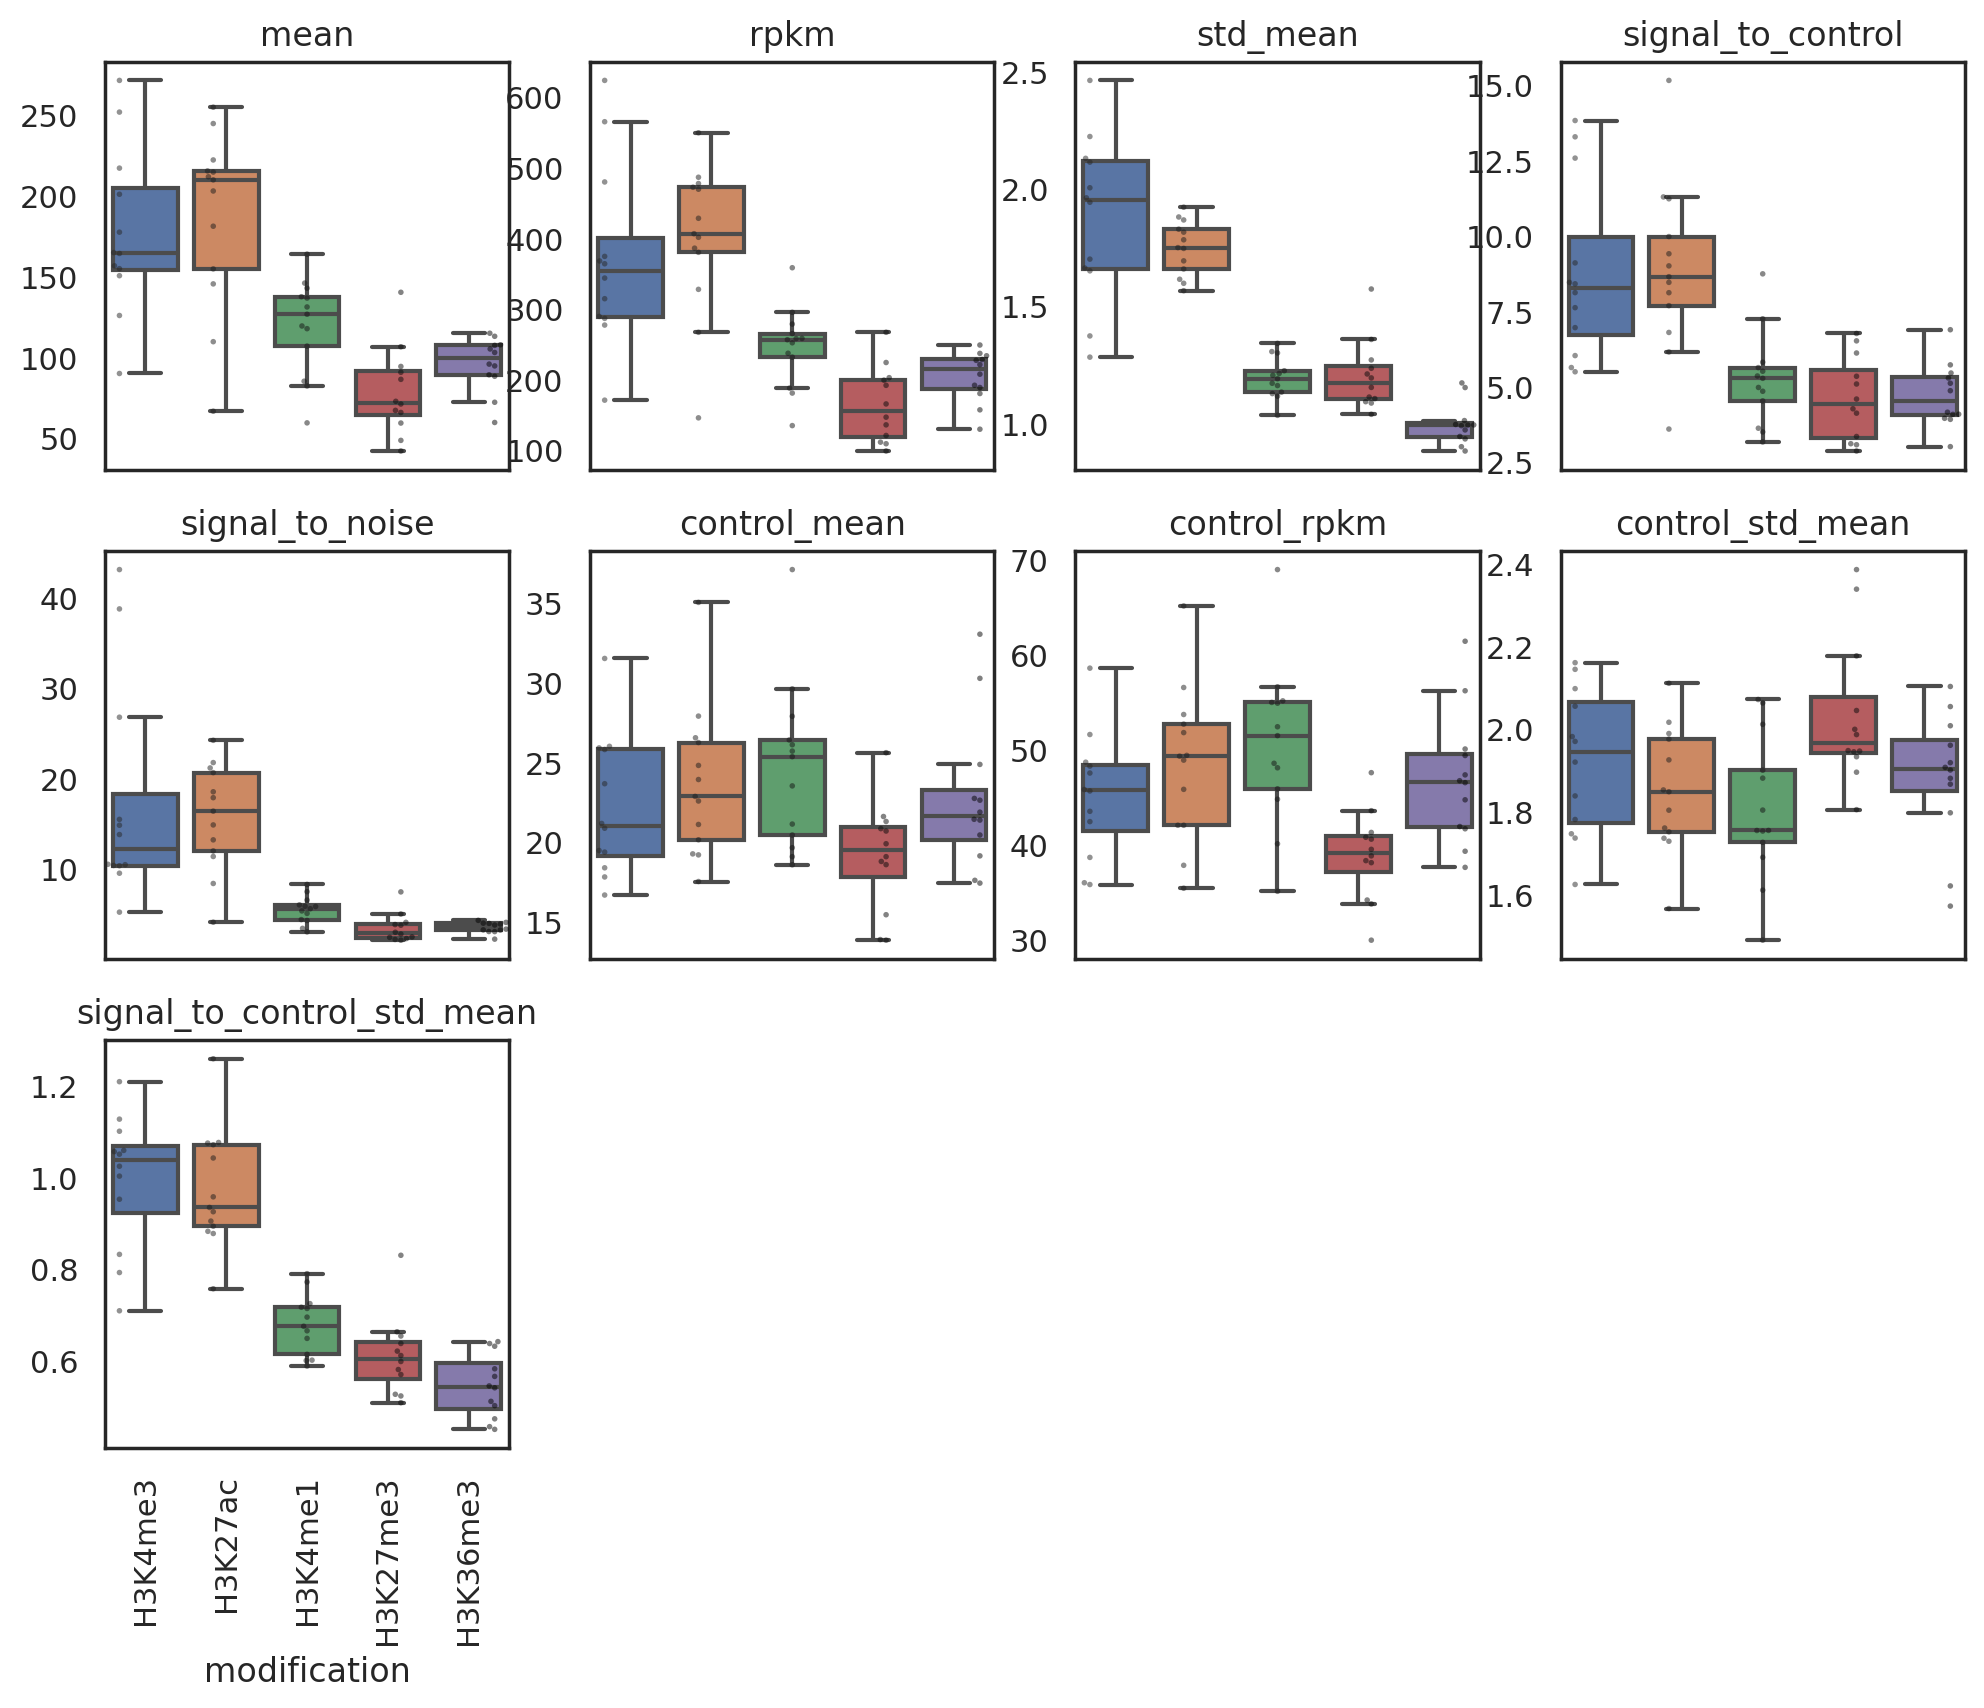

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

Roadmap


/tmp/ipykernel_754410/1958819393.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=tt, x='modification', y=y,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_754410/1958819393.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=tt, x='modification', y=y,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_754410/1958819393.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=tt, x='modification', y=y,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_754410/1958819393.py:17: FutureWar

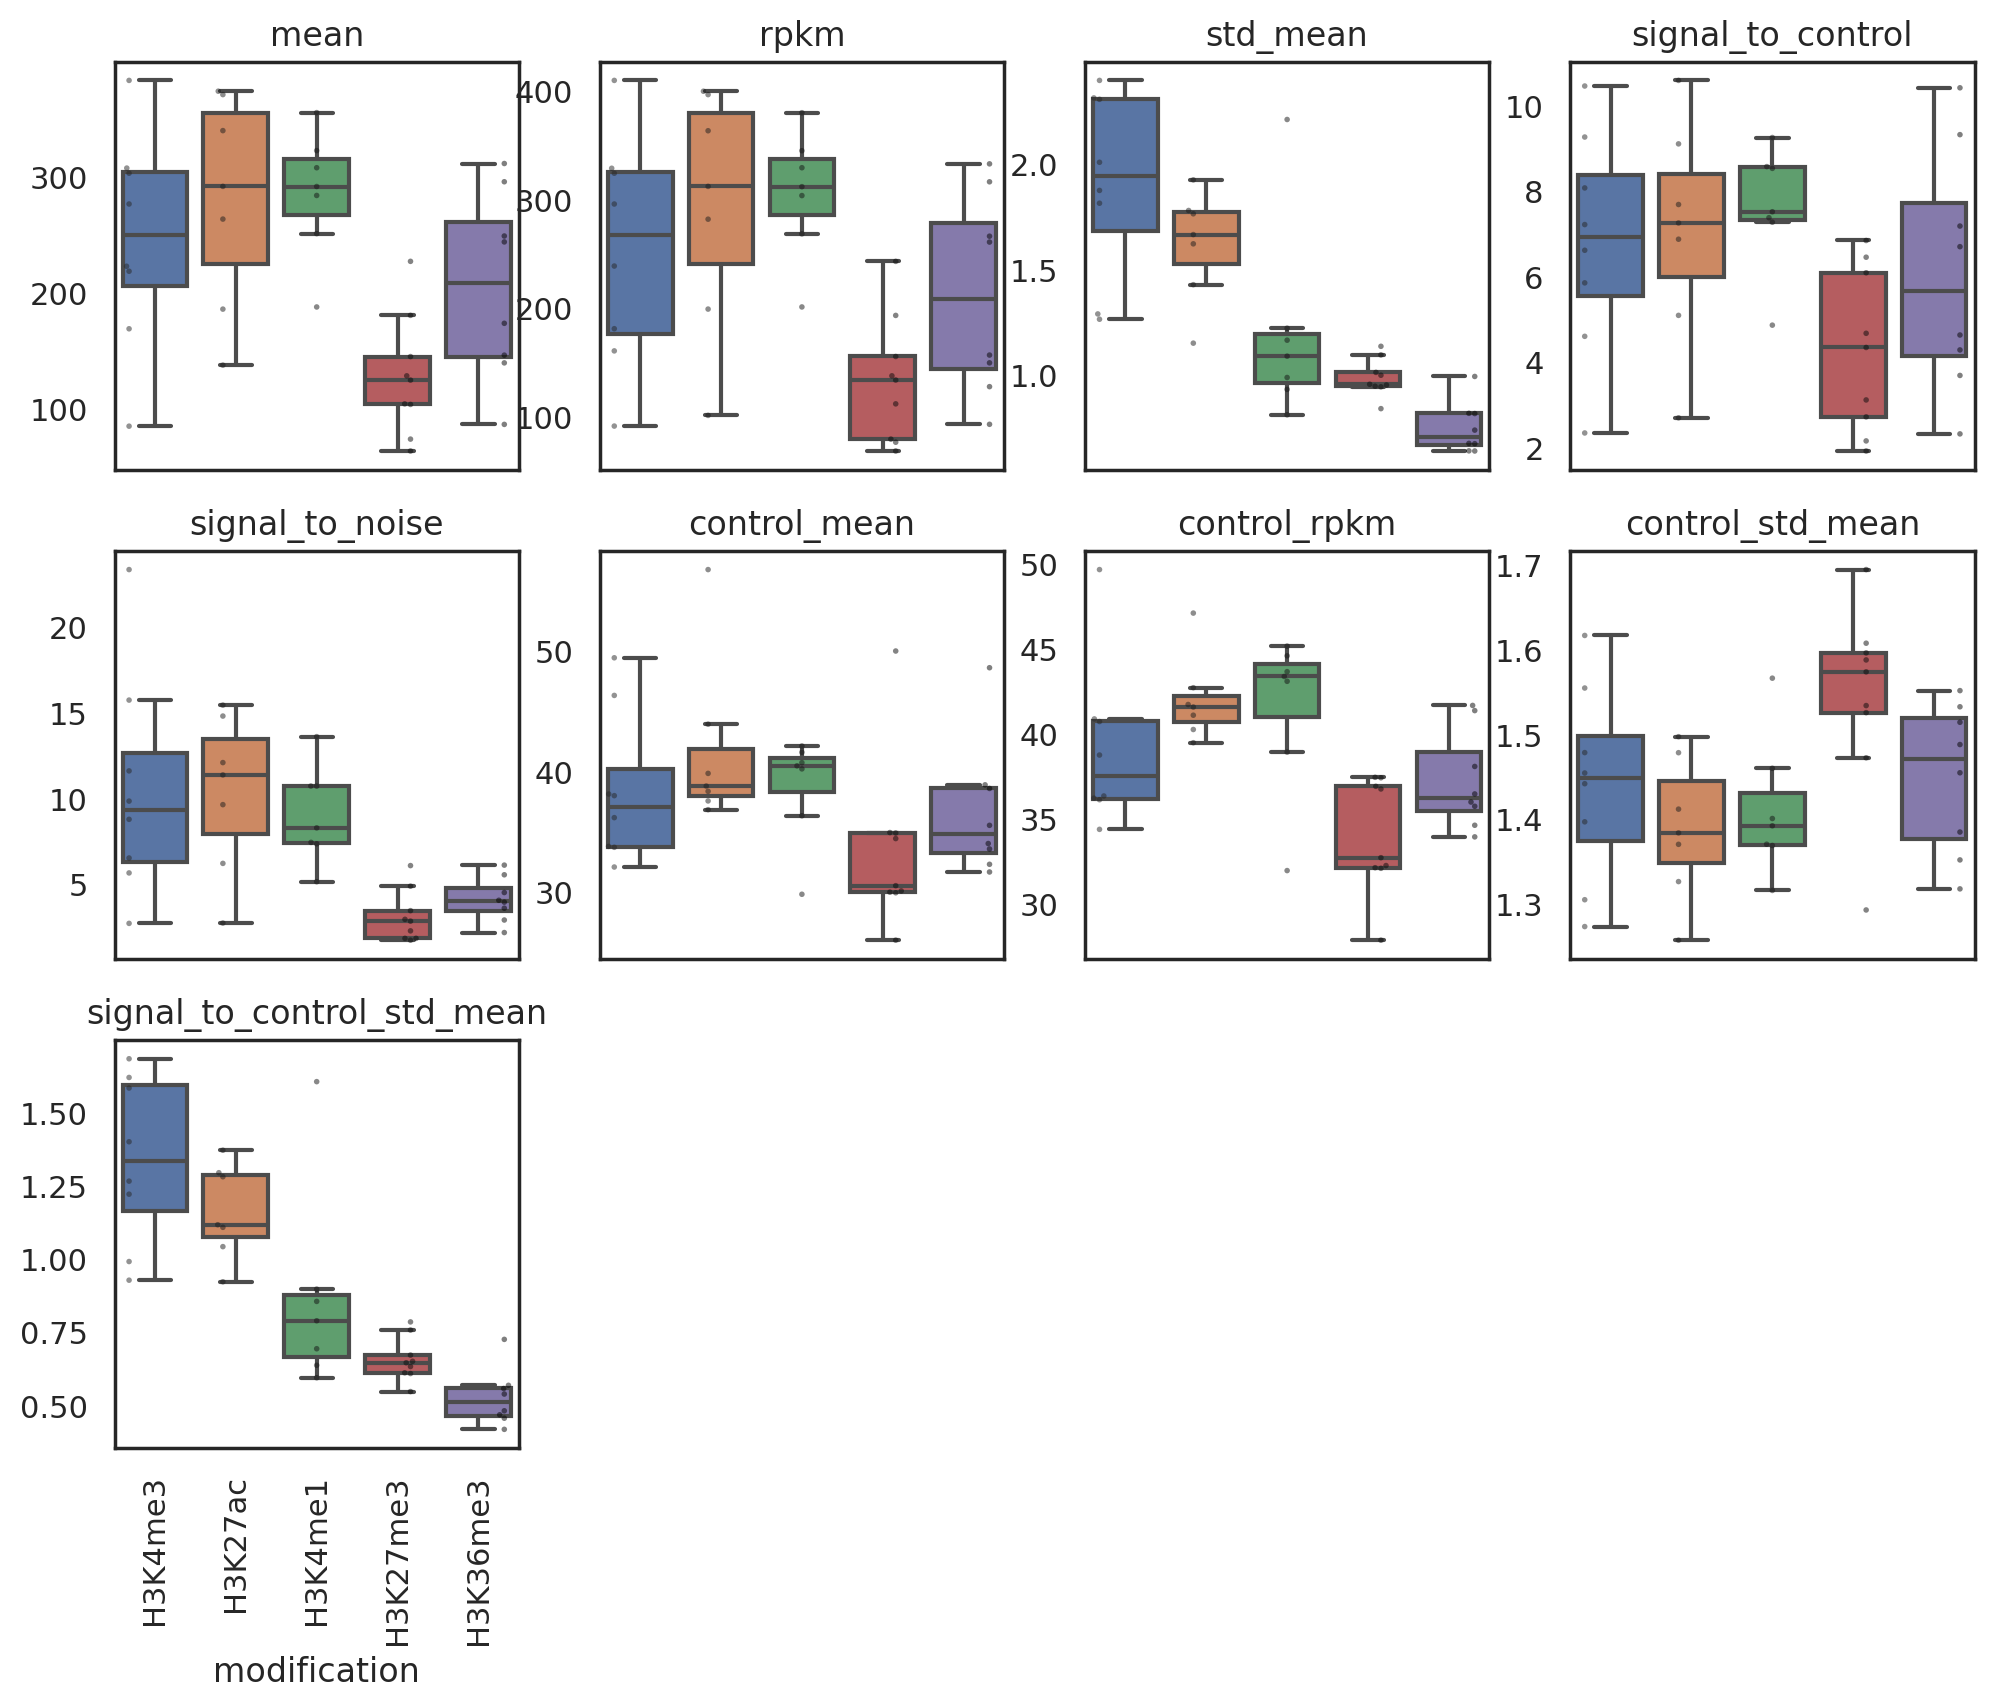

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

<Figure size 400x300 with 0 Axes>

In [90]:
features = ['mean', 'rpkm', 'std_mean', 'signal_to_control', 'signal_to_noise',
            'control_mean', 'control_rpkm', 'control_std_mean', 'signal_to_control_std_mean']
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    ncols = int(math.ceil(math.sqrt(len(features) + 3)))
    nrows = int(math.ceil(len(features) / ncols))
    plt.figure(figsize=(3 * ncols, 3 * nrows))
    axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(features))]
    for i, y in enumerate(features):
        ax = axs[i]
        plt.figure(figsize=(4, 3))
        tt = df_bw_stats_signal_snr_aggr[(df_bw_stats_signal_snr_aggr['dataset'] == ds)]
        sns.boxplot(data=tt, x='modification', y=y,
                    order=MODIFICATIONS,
                    showfliers=False,
                    ax=ax)
        sns.swarmplot(data=tt, x='modification', y=y,
                      dodge=True, size=2, alpha=0.5, palette='dark:black', legend=False,
                      order=MODIFICATIONS,
                      ax=ax)
        ax.title.set_text(y)
        ax.set_ylabel(None)
        if i / ncols < nrows - 1:
            ax.set_xlabel(None)
            ax.set_xticks([], minor=False)
            ax.set_xticklabels([])
        ax.xaxis.set_tick_params(rotation=90)
        if i % nrows == -1:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)

    plt.tight_layout()
    plt.show()

# Aggregate with peaks

In [91]:
# Analyze vs peaks number / length
df_aggr = pd.merge(df_bw_stats_signal_snr_aggr,
                   df_lens_aggr,
                   on=['dataset', 'modification', 'cell', 'replicate'], how='inner').groupby(
    ['dataset', 'modification', 'cell', 'replicate']).mean()
df_aggr = pd.merge(df_aggr,
                   df_m_peaks[['dataset', 'modification', 'cell', 'replicate', 'tool',  'peaks']],
                   on=['dataset', 'modification', 'cell', 'replicate'], how='inner')

df_aggr.sample(3)

/tmp/ipykernel_754410/1297261560.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ['dataset', 'modification', 'cell', 'replicate']).mean()


dataset modification   cell replicate  signal_to_noise       sum  \
104   ENCODE     H3K36me3   HMEC      rep2         4.356421  10771.25   
307  Roadmap     H3K36me3   CD34                   5.543895  31101.25   
123   ENCODE     H3K36me3  Huvec      rep1         3.842950   9573.75   

         mean         std        rpkm  std_mean  ...  control_sum  \
104  107.7125   98.214016  233.663005  0.933117  ...      1740.00   
307  311.0125  192.999872  332.706212  0.640163  ...      3165.00   
123   95.7375   92.134715  188.742741  0.994786  ...      2486.25   

     control_mean  control_std  control_rpkm  control_std_mean  \
104       17.4000    34.622677     37.581116          2.103404   
307       31.6500    47.527624     33.912240          1.551702   
123       24.8625    43.625235     46.705758          1.797639   

     signal_to_control_std_mean       length     footprint   tool  peaks  
104                    0.455780  4457.101800  1.402274e+08  MACS2  60412  
307                    0.418521  5129.335075  2.059977e+08   SPAN  40055  
123                    0.565469  4106.107100  9.178110e+07   SPAN  17945  

[3 rows x 22 columns]

In [92]:
df_aggr[['dataset', 'modification', 'cell', 'replicate']].drop_duplicates().groupby(['dataset', 'modification']).size()

dataset  modification
ENCODE   H3K27ac         13
         H3K27me3        10
         H3K36me3        12
         H3K4me1         13
         H3K4me3         12
Roadmap  H3K27ac          7
         H3K27me3         8
         H3K36me3         8
         H3K4me1          6
         H3K4me3          7
dtype: int64

H3K4me1 MACS2 broad


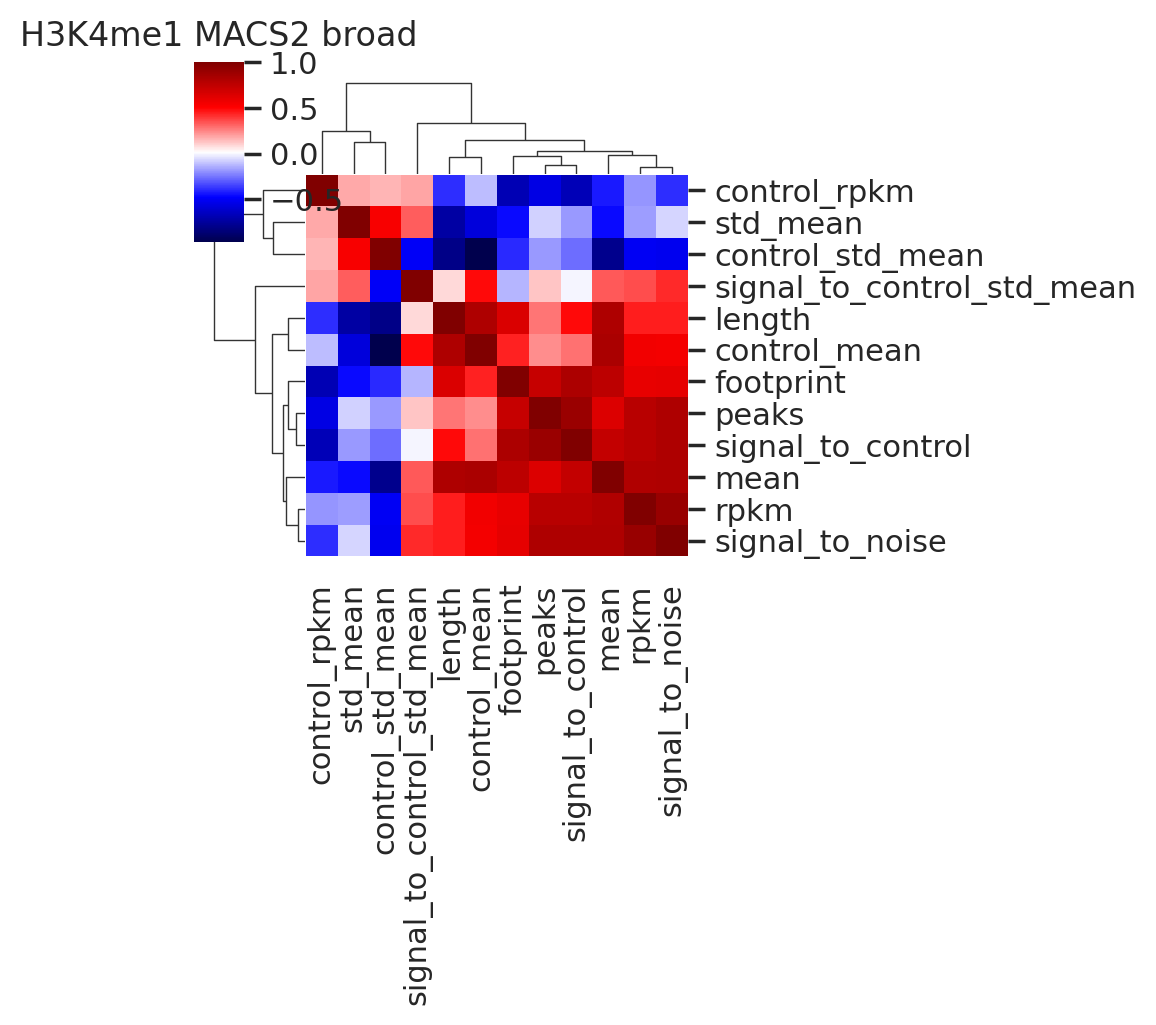

In [93]:
for m, tool in product(['H3K4me1'], ['MACS2 broad']):
    print(m, tool)
    tt = df_aggr[(df_aggr['modification'] == m) & (df_aggr['tool'] == tool)]
    features = ['peaks', 'length', 'footprint',
                'mean', 'rpkm', 'std_mean',
                'control_mean', 'control_rpkm', 'control_std_mean',
                'signal_to_noise', 'signal_to_control', 'signal_to_control_std_mean']
    sns.clustermap(tt[features].corr(method='spearman'),
                   col_cluster=True, row_cluster=True,
                   figsize=(5, 5),
                   cmap=plt.cm.seismic)
    plt.title(f'{m} {tool}')
    plt.show()

# All modifications / tools

MACS2


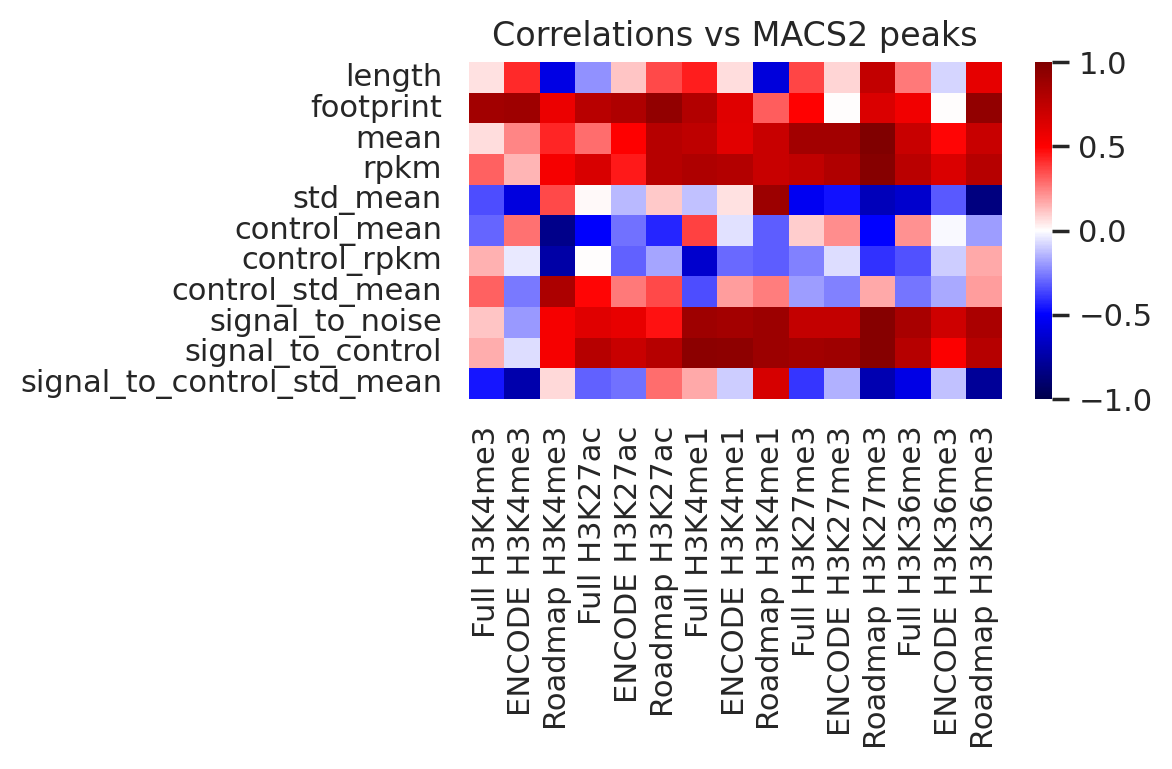

MACS2 broad


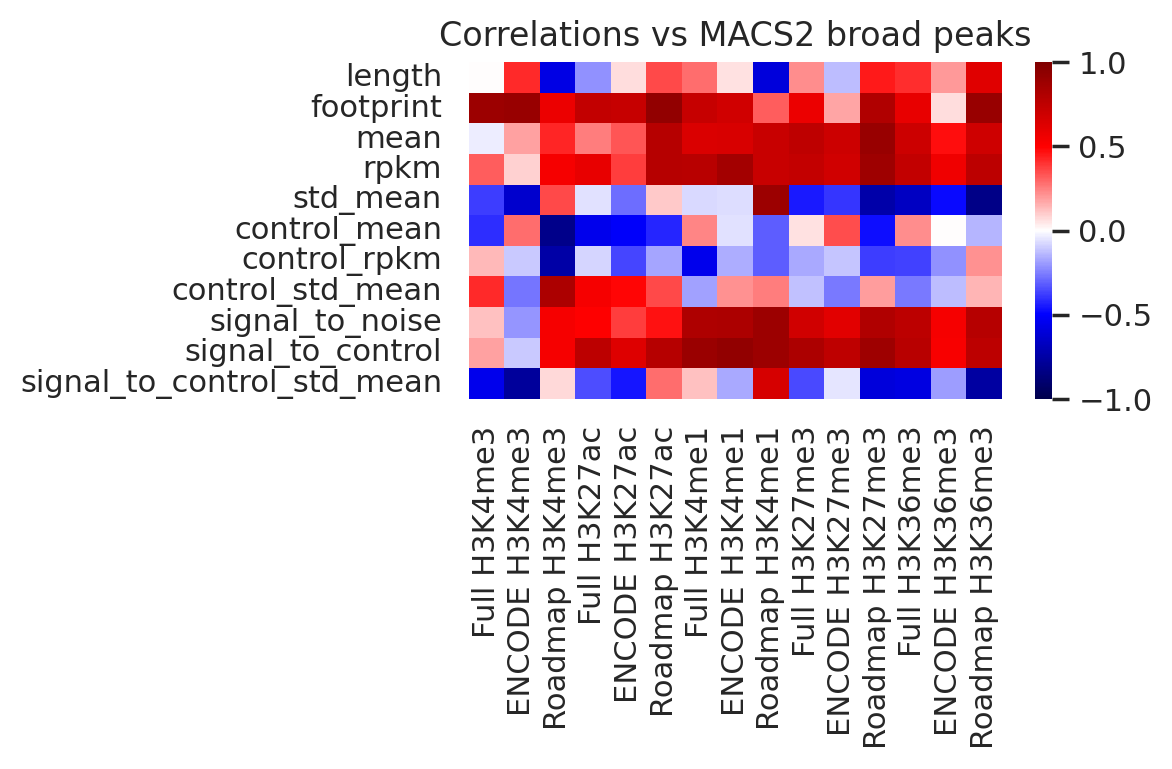

SPAN


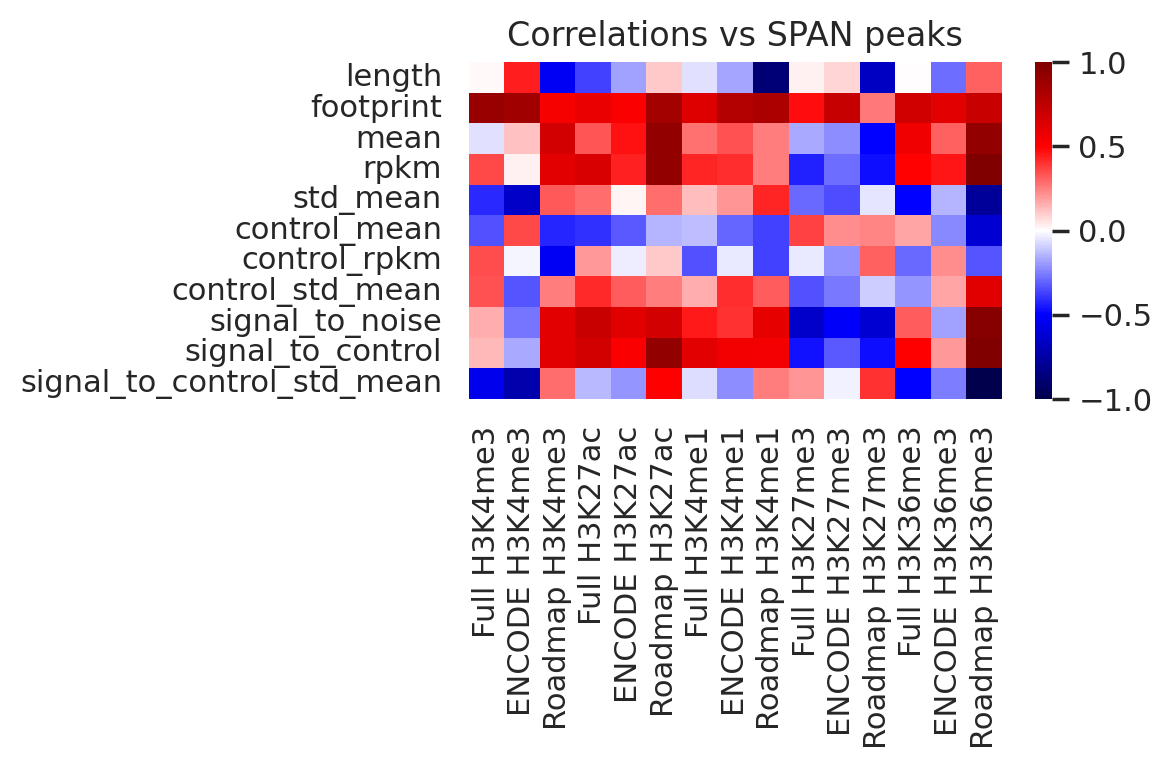

SICER


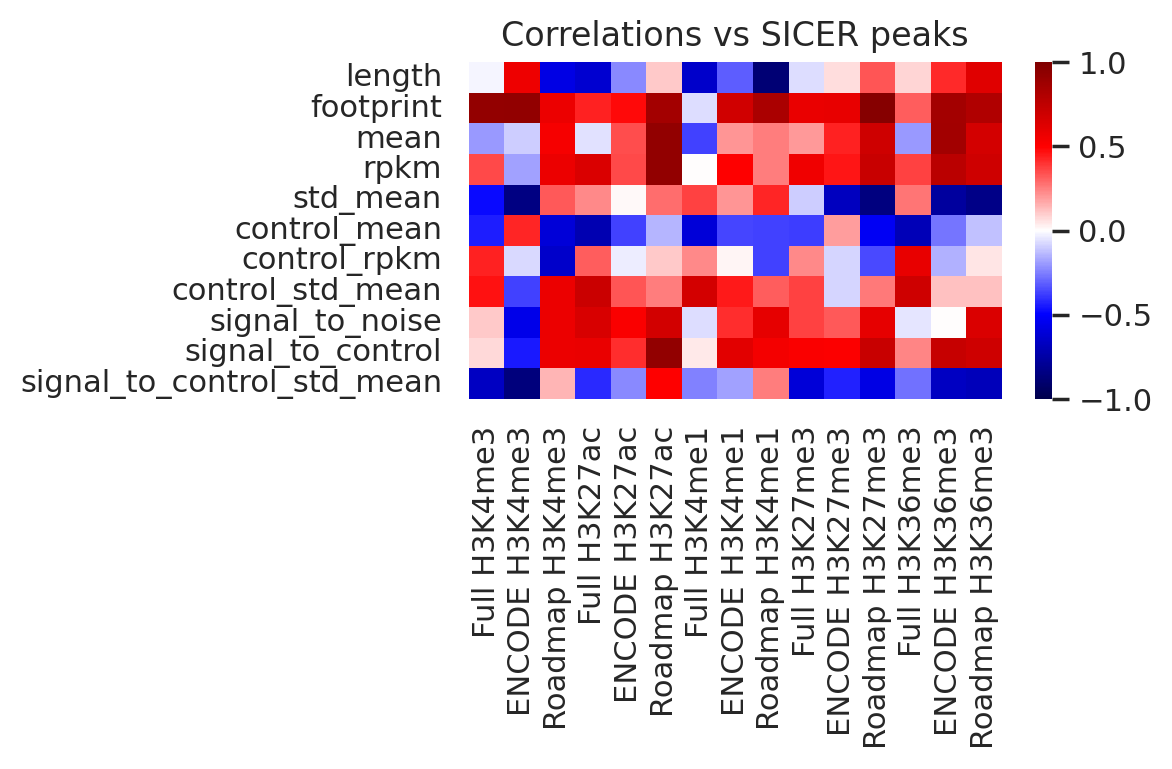

MACS2


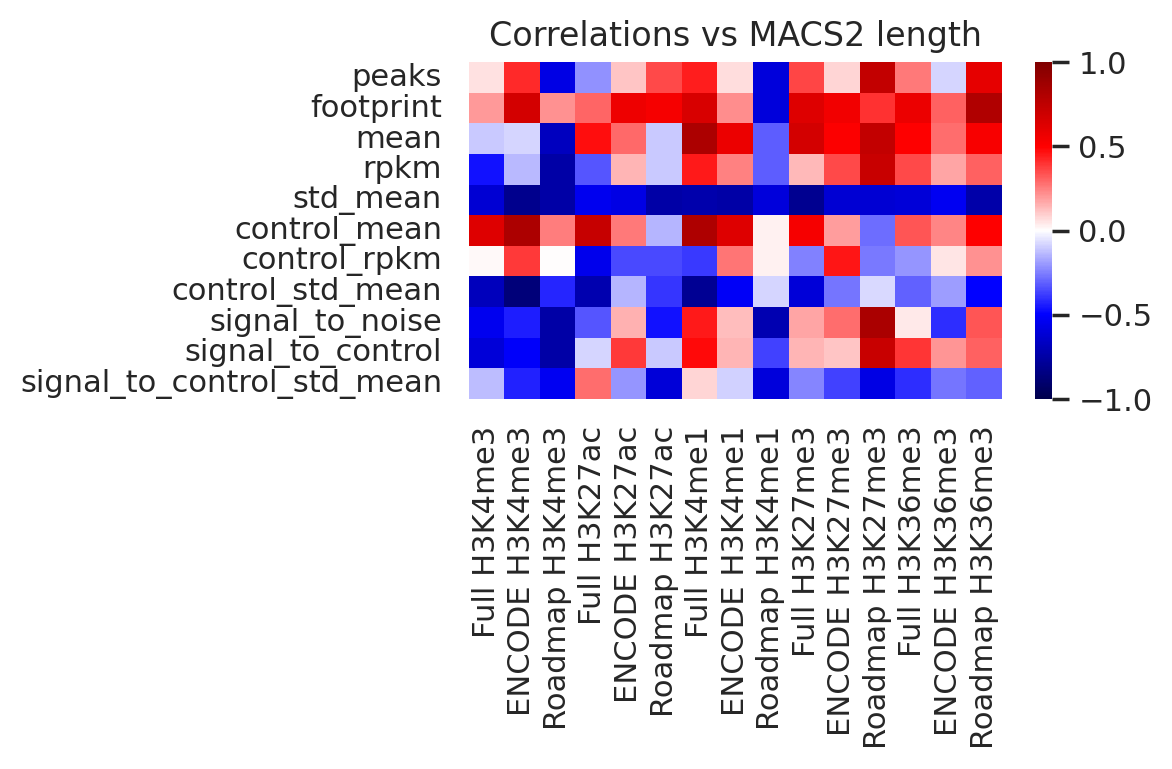

MACS2 broad


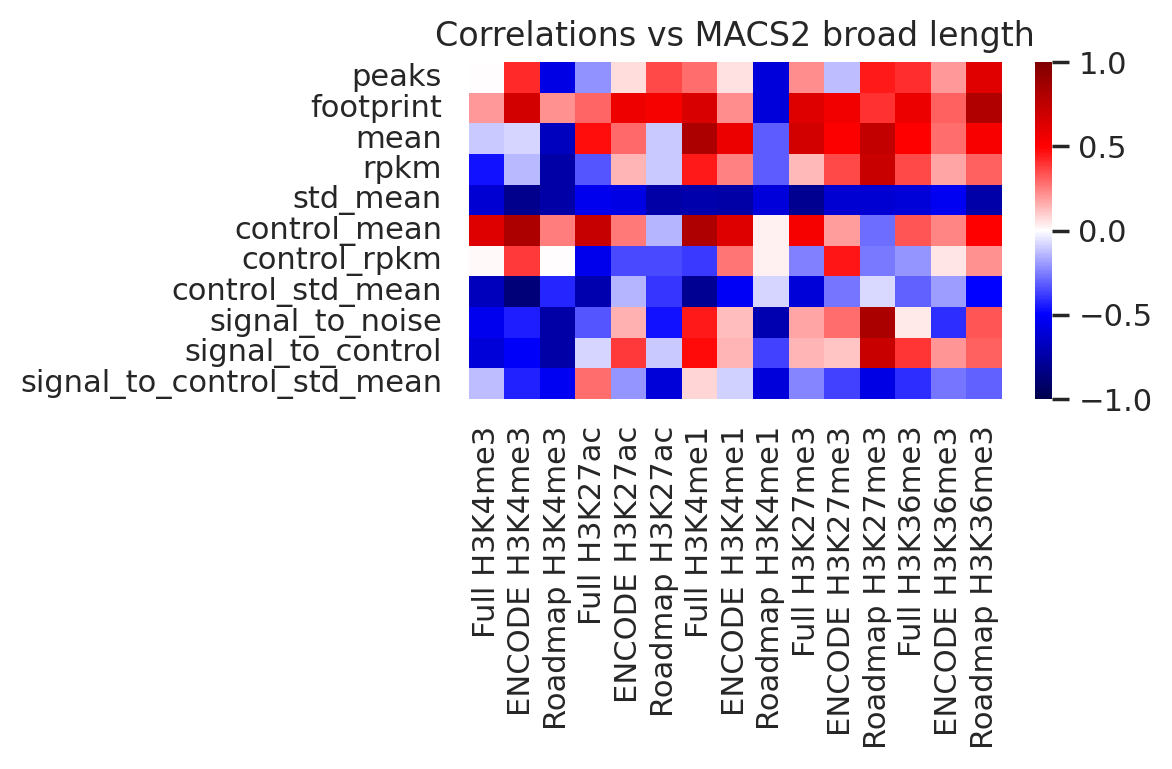

SPAN


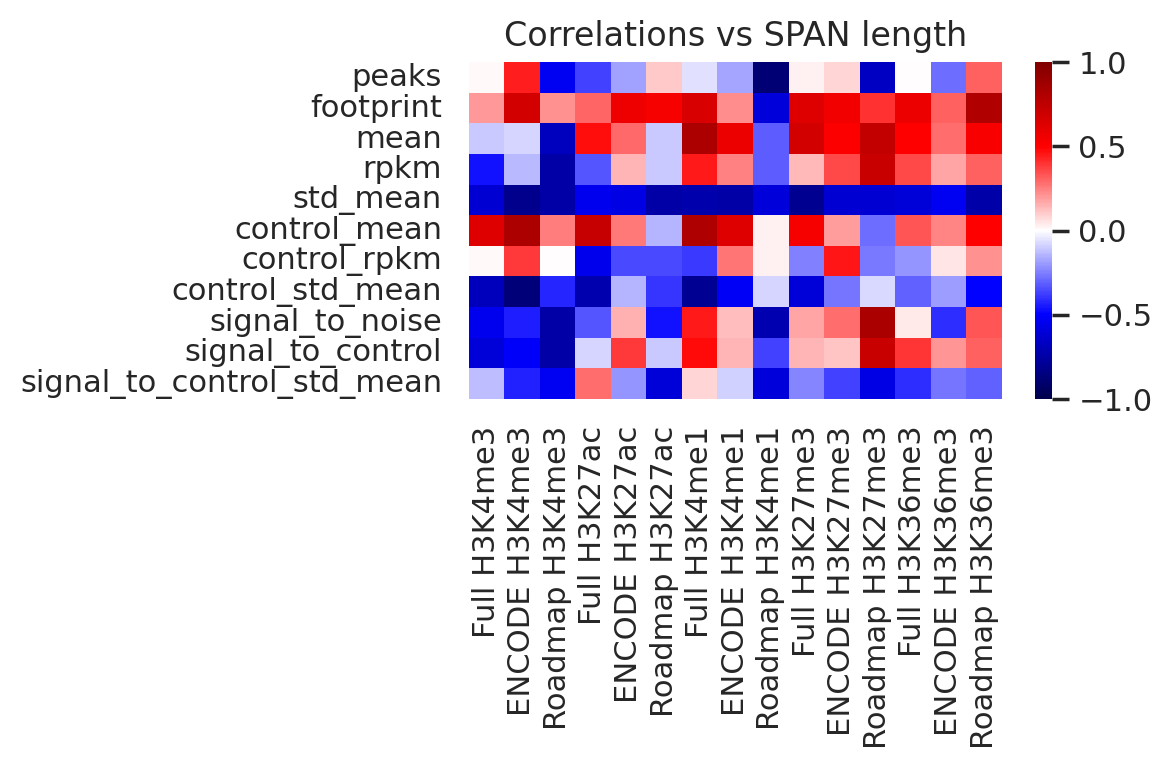

SICER


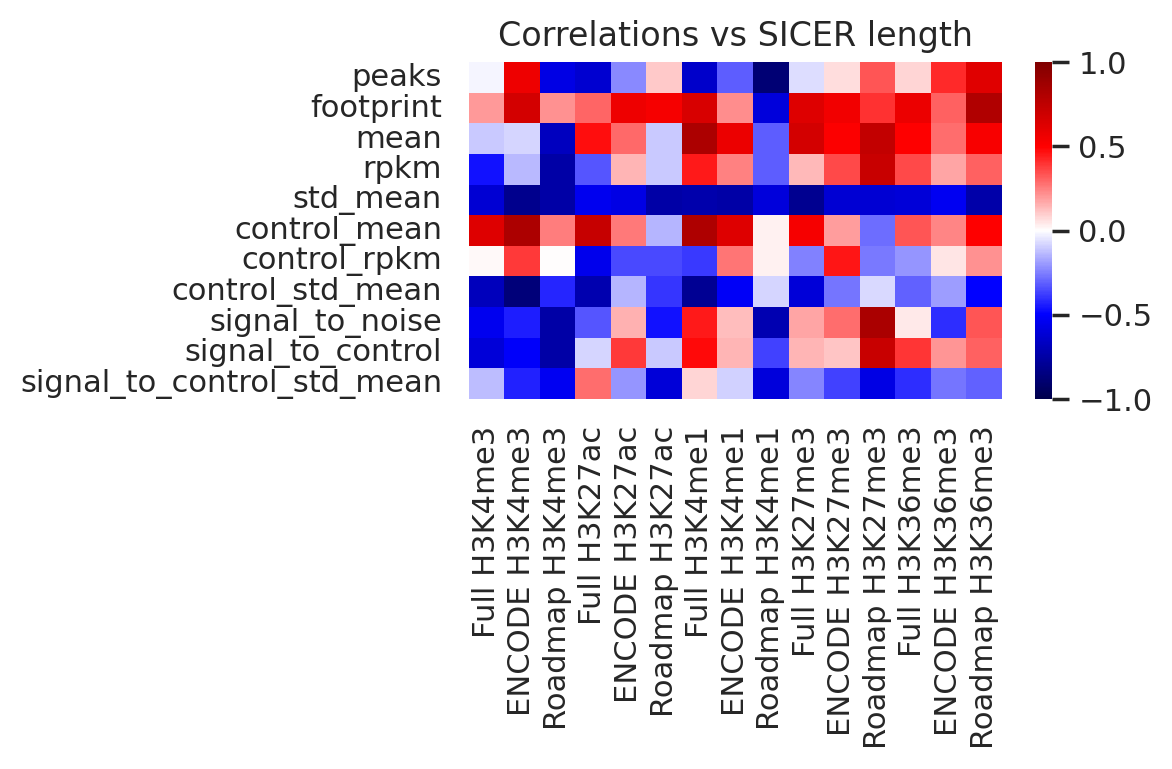

In [94]:
features = ['peaks', 'length', 'footprint',
            'mean', 'rpkm', 'std_mean',
            'control_mean', 'control_rpkm', 'control_std_mean',
            'signal_to_noise', 'signal_to_control', 'signal_to_control_std_mean']
for f in ['peaks', 'length']:
    for tool in TOOLS:
        print(tool)
        ts = []
        for m in MODIFICATIONS:
            tt = df_aggr[(df_aggr['modification'] == m) & (df_aggr['tool'] == tool)]
            ts.append(pd.DataFrame({f'Full {m}': tt[features].corr(method='spearman')[f],
                                    f'ENCODE {m}': tt[tt['dataset'] == 'ENCODE'][features].corr(method='spearman')[f],
                                    f'Roadmap {m}': tt[tt['dataset'] == 'Roadmap'][features].corr(method='spearman')[
                                        f]}))
        tt = pd.concat(ts, axis=1)
        tt.drop(f, axis=0, inplace=True)
        plt.figure(figsize=(6, 4))
        ax = plt.axes()
        sns.heatmap(tt, cmap=plt.cm.seismic, vmin=-1, vmax=1, ax=ax)
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_title(f'Correlations vs {tool} {f}')
        plt.tight_layout()
        plt.show()



peaks vs signal_to_noise
Correlation 0.8175438596491227, p 1.9166593666400625e-05


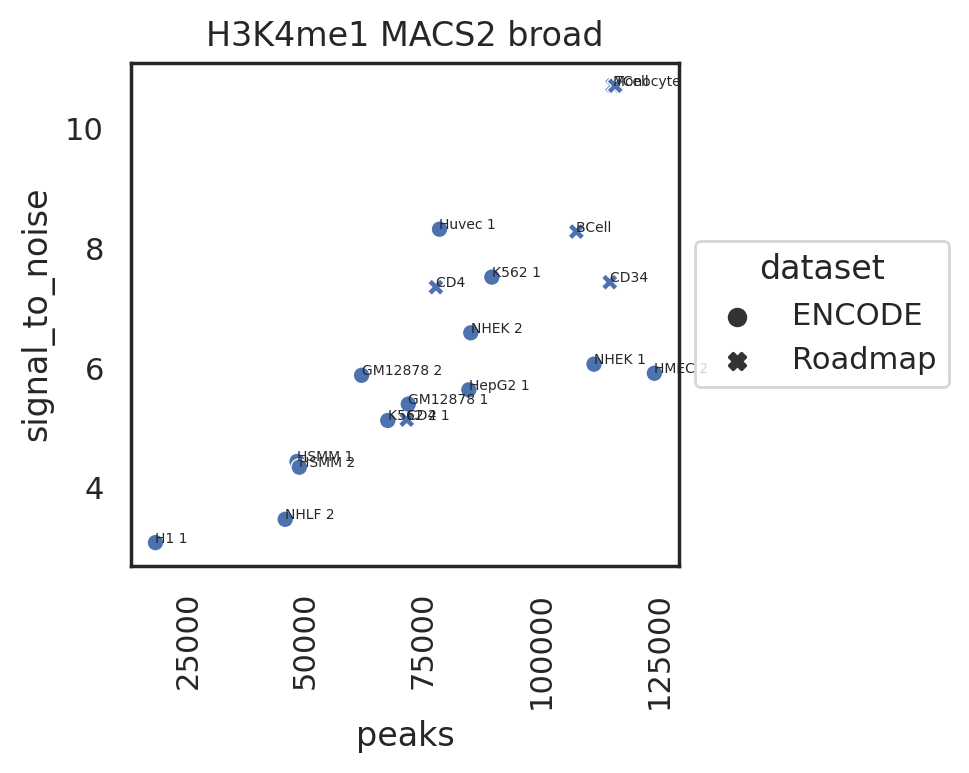



peaks vs signal_to_control
Correlation 0.8964912280701753, p 2.0523092236433137e-07


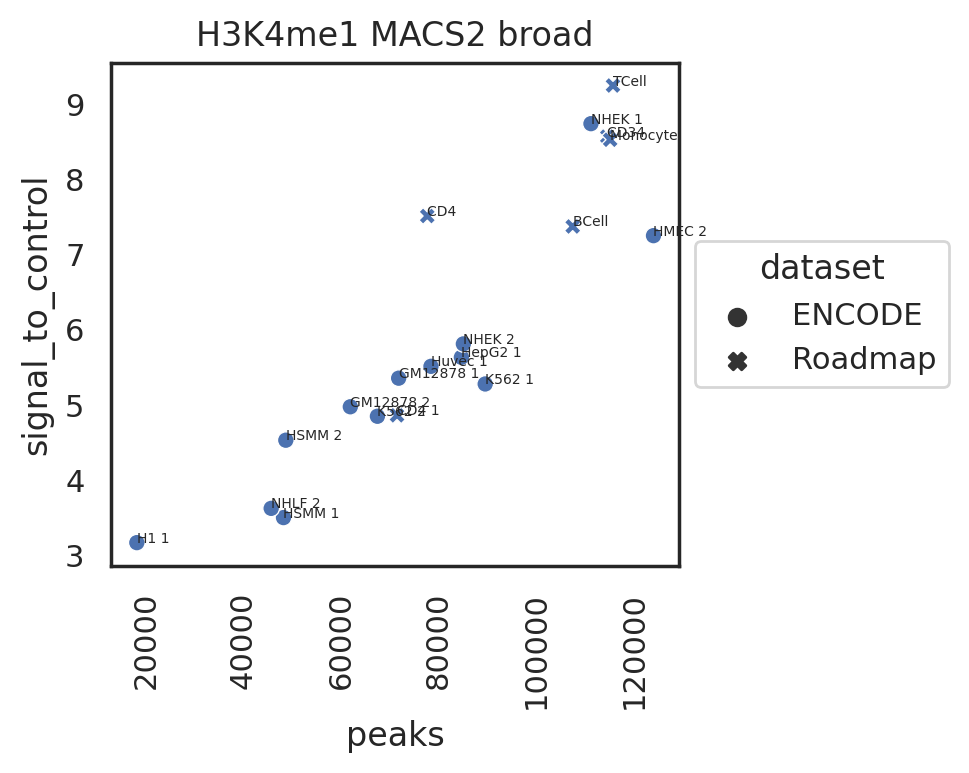

In [95]:
TOOL = 'MACS2 broad'
tt = df_aggr[(df_aggr['modification'] == 'H3K4me1') & (df_aggr['tool'] == TOOL)]

from scipy.stats import spearmanr

for x, y in [('peaks', 'signal_to_noise'), ('peaks', 'signal_to_control')]:
    print(f'\n\n{x} vs {y}')
    plt.figure(figsize=(5, 4))
    ax = plt.axes()
    tt = df_aggr[(df_aggr['modification'] == 'H3K4me1') & (df_aggr['tool'] == TOOL)].copy()
    sns.scatterplot(
        tt, x=x, y=y,
        style='dataset',
        ax=ax)
    for xv, yv, cell, rep in zip(tt[x], tt[y], tt['cell'], tt['replicate']):
        rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
        ax.text(xv, yv, f'{cell} {rep}', fontsize=5)
    corr, p = spearmanr(tt[x], tt[y])
    print(f'Correlation {corr}, p {p}')
    ax.title.set_text(f'H3K4me1 {TOOL}')
    sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if x != 'reads':
        ax.xaxis.set_tick_params(rotation=90)
    plt.tight_layout()
    plt.show()

# Difference in features between replicates

H3K4me3 MACS2 broad


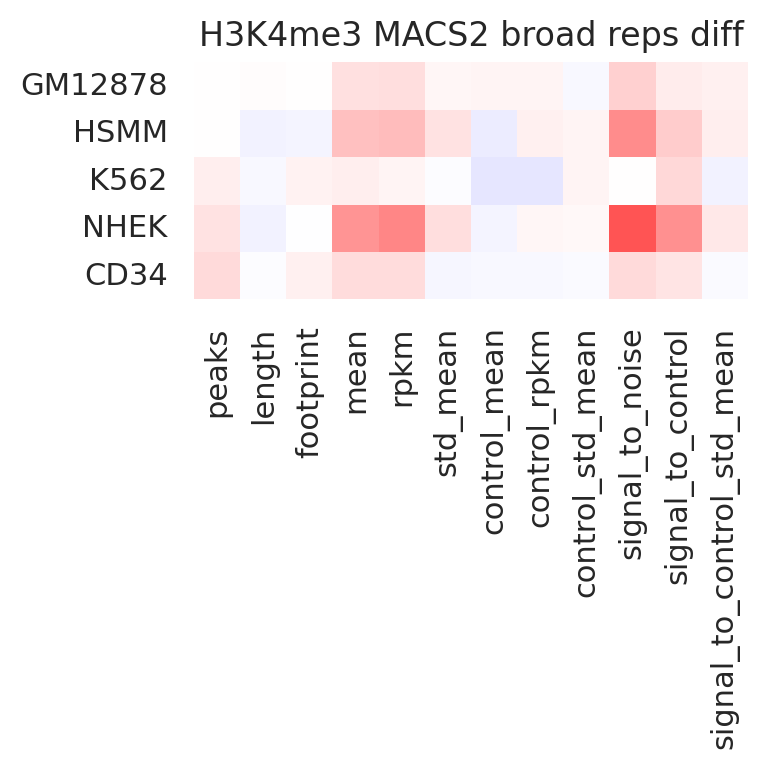

H3K27ac MACS2 broad


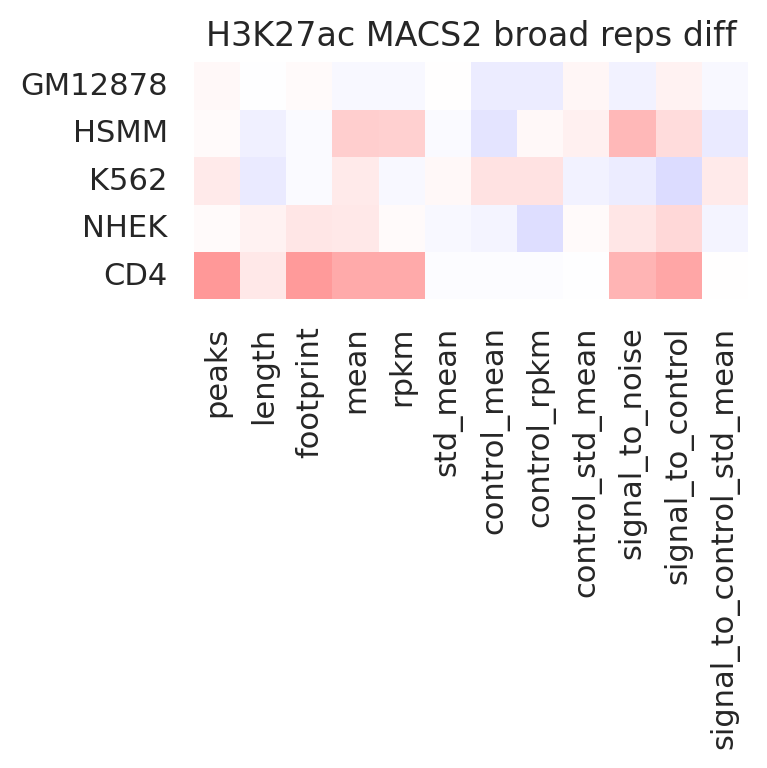

H3K4me1 MACS2 broad


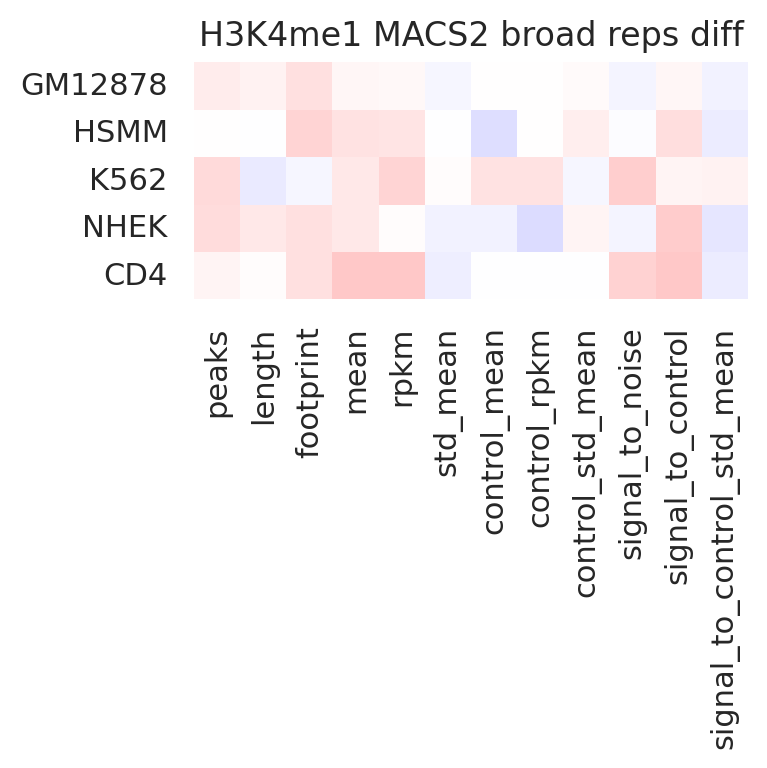

H3K27me3 MACS2 broad


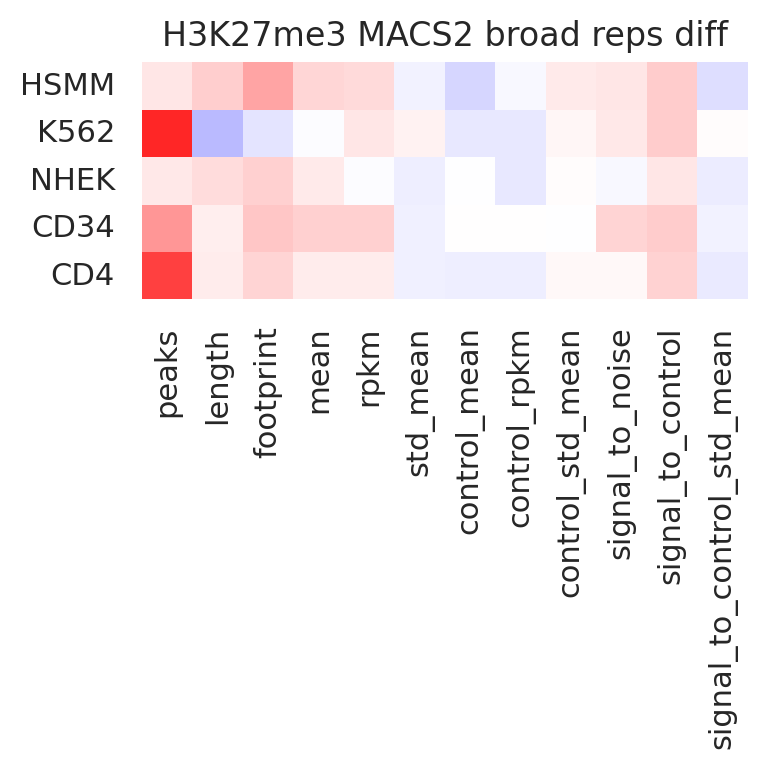

H3K36me3 MACS2 broad


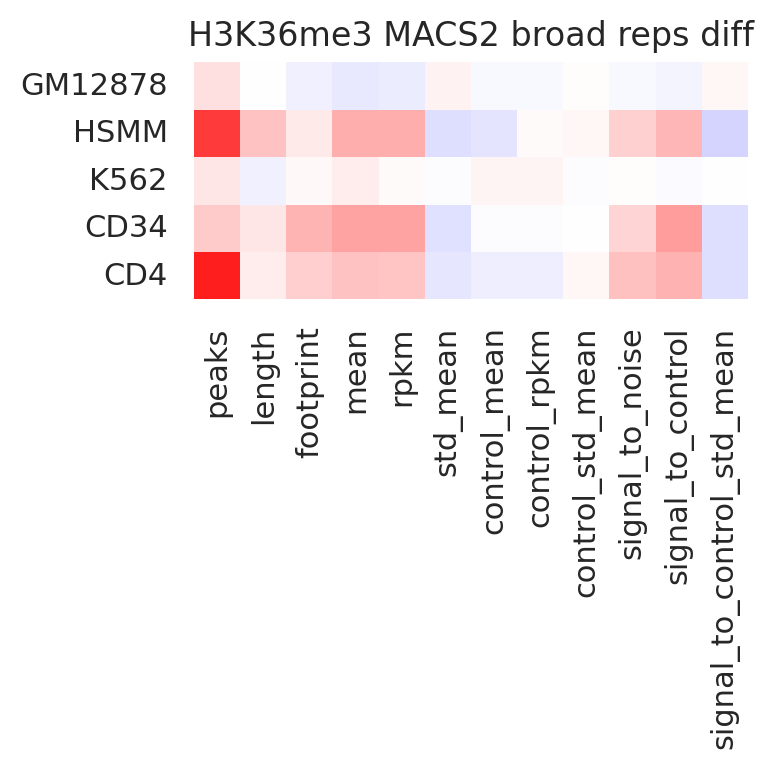

In [96]:
for m in MODIFICATIONS:
    print(m, TOOL)
    ts = []
    for cell in GSE26320_CELLS + IMMUNE_CELLS:
        tt = df_aggr[(df_aggr['modification'] == m) & (df_aggr['cell'] == cell) & (df_aggr['tool'] == TOOL)].copy()
        if len(tt) != 2:
            continue
        tt.sort_values(by=['peaks'], inplace=True)
        tt = pd.DataFrame(
            [[(tt[f].values[1] - tt[f].values[0]) / (tt[f].values[1] + tt[f].values[0]) for f in features]],
            columns=features)
        tt.index = [cell]
        ts.append(tt)
    df_diff_reps = pd.concat(ts)
    plt.figure(figsize=(4, 4))
    ax = plt.axes()
    sns.heatmap(df_diff_reps, cmap='bwr', vmin=-1, vmax=1, ax=ax, cbar=False)
    ax.xaxis.set_tick_params(rotation=90)
    ax.yaxis.set_tick_params(rotation=0)
    ax.set_title(f'{m} {TOOL} reps diff')
    plt.tight_layout()
    plt.show()